# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.7126824372833234 -2.9975146362651652
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [35]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:-0.0895 dloss:1.3013 dlossR:0.6112 dlossQ:0.6901
Episode:1 meanR:9.0000 rate:0.0180 gloss:-0.0349 dloss:1.3533 dlossR:0.6604 dlossQ:0.6929
Episode:2 meanR:19.3333 rate:0.0800 gloss:-0.0846 dloss:1.3027 dlossR:0.6150 dlossQ:0.6877
Episode:3 meanR:34.2500 rate:0.1580 gloss:0.0438 dloss:1.3580 dlossR:0.6625 dlossQ:0.6955
Episode:4 meanR:36.4000 rate:0.0900 gloss:-0.0318 dloss:1.3328 dlossR:0.6391 dlossQ:0.6937
Episode:5 meanR:35.8333 rate:0.0660 gloss:-0.0628 dloss:1.3188 dlossR:0.6263 dlossQ:0.6925
Episode:6 meanR:38.0000 rate:0.1020 gloss:-0.0451 dloss:1.3228 dlossR:0.6291 dlossQ:0.6937
Episode:7 meanR:39.8750 rate:0.1060 gloss:-0.0542 dloss:1.3171 dlossR:0.6235 dlossQ:0.6936
Episode:8 meanR:39.2222 rate:0.0680 gloss:-0.1100 dloss:1.2885 dlossR:0.5981 dlossQ:0.6904
Episode:9 meanR:38.4000 rate:0.0620 gloss:-0.1298 dloss:1.2764 dlossR:0.5875 dlossQ:0.6890
Episode:10 meanR:38.1818 rate:0.0720 gloss:-0.1414 dloss:1.2688 dlossR:0.5804 dlossQ:0.6884
E

Episode:97 meanR:28.8776 rate:0.0580 gloss:-1.4826 dloss:0.5925 dlossR:0.2304 dlossQ:0.3621
Episode:98 meanR:29.0202 rate:0.0860 gloss:-1.3821 dloss:0.6708 dlossR:0.2951 dlossQ:0.3757
Episode:99 meanR:29.1400 rate:0.0820 gloss:-1.4702 dloss:0.6469 dlossR:0.2859 dlossQ:0.3610
Episode:100 meanR:29.2700 rate:0.0440 gloss:-1.5356 dloss:0.5574 dlossR:0.1961 dlossQ:0.3613
Episode:101 meanR:29.4900 rate:0.0620 gloss:-1.3944 dloss:0.6184 dlossR:0.2428 dlossQ:0.3756
Episode:102 meanR:29.3500 rate:0.0520 gloss:-1.4086 dloss:0.5963 dlossR:0.2199 dlossQ:0.3764
Episode:103 meanR:28.7200 rate:0.0320 gloss:-1.4455 dloss:0.5458 dlossR:0.1702 dlossQ:0.3756
Episode:104 meanR:28.4600 rate:0.0380 gloss:-1.4855 dloss:0.5461 dlossR:0.1816 dlossQ:0.3645
Episode:105 meanR:28.2700 rate:0.0280 gloss:-1.5478 dloss:0.5158 dlossR:0.1519 dlossQ:0.3639
Episode:106 meanR:27.8700 rate:0.0220 gloss:-1.5584 dloss:0.5193 dlossR:0.1348 dlossQ:0.3845
Episode:107 meanR:27.4600 rate:0.0240 gloss:-1.7385 dloss:0.4723 dlossR:0

Episode:188 meanR:58.6900 rate:0.0420 gloss:-1.2034 dloss:0.6630 dlossR:0.2229 dlossQ:0.4400
Episode:189 meanR:58.7300 rate:0.0300 gloss:-1.3098 dloss:0.6114 dlossR:0.1864 dlossQ:0.4249
Episode:190 meanR:58.7600 rate:0.0260 gloss:-1.3153 dloss:0.6056 dlossR:0.1770 dlossQ:0.4287
Episode:191 meanR:58.5600 rate:0.0240 gloss:-1.3274 dloss:0.6098 dlossR:0.1719 dlossQ:0.4380
Episode:192 meanR:58.6100 rate:0.0360 gloss:-1.2723 dloss:0.6287 dlossR:0.2028 dlossQ:0.4258
Episode:193 meanR:58.6600 rate:0.0680 gloss:-1.1270 dloss:0.7387 dlossR:0.2791 dlossQ:0.4596
Episode:194 meanR:59.0400 rate:0.1220 gloss:-1.0881 dloss:0.8397 dlossR:0.3743 dlossQ:0.4654
Episode:195 meanR:63.8800 rate:1.0000 gloss:-0.4694 dloss:2.6067 dlossR:1.8677 dlossQ:0.7390
Episode:196 meanR:64.2300 rate:0.1640 gloss:-1.0529 dloss:0.9228 dlossR:0.4474 dlossQ:0.4754
Episode:197 meanR:66.9300 rate:0.5980 gloss:-0.6257 dloss:1.7445 dlossR:1.1085 dlossQ:0.6360
Episode:198 meanR:67.3100 rate:0.1620 gloss:-0.9896 dloss:0.9402 dloss

Episode:282 meanR:37.5800 rate:0.1020 gloss:-1.4908 dloss:0.6753 dlossR:0.3308 dlossQ:0.3445
Episode:283 meanR:38.0000 rate:0.1500 gloss:-1.5069 dloss:0.7845 dlossR:0.4463 dlossQ:0.3383
Episode:284 meanR:38.1400 rate:0.0480 gloss:-1.5326 dloss:0.5468 dlossR:0.2028 dlossQ:0.3440
Episode:285 meanR:37.7000 rate:0.0520 gloss:-1.5570 dloss:0.5494 dlossR:0.2115 dlossQ:0.3379
Episode:286 meanR:37.4400 rate:0.0320 gloss:-1.6024 dloss:0.5005 dlossR:0.1587 dlossQ:0.3418
Episode:287 meanR:37.2700 rate:0.0360 gloss:-1.6581 dloss:0.4990 dlossR:0.1669 dlossQ:0.3322
Episode:288 meanR:37.1400 rate:0.0160 gloss:-1.7669 dloss:0.5289 dlossR:0.1071 dlossQ:0.4218
Episode:289 meanR:37.1000 rate:0.0220 gloss:-1.7564 dloss:0.4717 dlossR:0.1235 dlossQ:0.3482
Episode:290 meanR:37.1300 rate:0.0320 gloss:-1.6588 dloss:0.4919 dlossR:0.1556 dlossQ:0.3363
Episode:291 meanR:37.1500 rate:0.0280 gloss:-1.5497 dloss:0.5101 dlossR:0.1517 dlossQ:0.3584
Episode:292 meanR:37.0800 rate:0.0220 gloss:-1.5702 dloss:0.5069 dloss

Episode:373 meanR:28.3200 rate:0.0420 gloss:-1.4457 dloss:0.5630 dlossR:0.1940 dlossQ:0.3690
Episode:374 meanR:28.3800 rate:0.0520 gloss:-1.4501 dloss:0.5789 dlossR:0.2168 dlossQ:0.3620
Episode:375 meanR:28.2300 rate:0.0520 gloss:-1.4303 dloss:0.5852 dlossR:0.2181 dlossQ:0.3671
Episode:376 meanR:28.1400 rate:0.0400 gloss:-1.4258 dloss:0.5633 dlossR:0.1909 dlossQ:0.3725
Episode:377 meanR:27.7300 rate:0.0360 gloss:-1.4142 dloss:0.5609 dlossR:0.1823 dlossQ:0.3786
Episode:378 meanR:27.4100 rate:0.0320 gloss:-1.4210 dloss:0.5520 dlossR:0.1719 dlossQ:0.3801
Episode:379 meanR:27.1900 rate:0.0280 gloss:-1.4118 dloss:0.5501 dlossR:0.1625 dlossQ:0.3876
Episode:380 meanR:27.0400 rate:0.0260 gloss:-1.3828 dloss:0.5561 dlossR:0.1601 dlossQ:0.3960
Episode:381 meanR:26.8100 rate:0.0240 gloss:-1.3876 dloss:0.5504 dlossR:0.1539 dlossQ:0.3965
Episode:382 meanR:26.4200 rate:0.0240 gloss:-1.4449 dloss:0.5315 dlossR:0.1480 dlossQ:0.3836
Episode:383 meanR:25.7800 rate:0.0220 gloss:-1.4649 dloss:0.5239 dloss

Episode:464 meanR:40.2000 rate:0.0540 gloss:-1.5241 dloss:0.5639 dlossR:0.2179 dlossQ:0.3460
Episode:465 meanR:40.3500 rate:0.0500 gloss:-1.5571 dloss:0.5448 dlossR:0.2067 dlossQ:0.3381
Episode:466 meanR:40.4000 rate:0.0340 gloss:-1.5993 dloss:0.5056 dlossR:0.1640 dlossQ:0.3416
Episode:467 meanR:40.4900 rate:0.0380 gloss:-1.6111 dloss:0.5076 dlossR:0.1737 dlossQ:0.3338
Episode:468 meanR:40.3400 rate:0.0380 gloss:-1.6222 dloss:0.5047 dlossR:0.1731 dlossQ:0.3316
Episode:469 meanR:40.0900 rate:0.0280 gloss:-1.6292 dloss:0.4895 dlossR:0.1460 dlossQ:0.3435
Episode:470 meanR:39.7200 rate:0.0180 gloss:-1.6289 dloss:0.5032 dlossR:0.1162 dlossQ:0.3871
Episode:471 meanR:39.2900 rate:0.0320 gloss:-1.6458 dloss:0.4875 dlossR:0.1558 dlossQ:0.3317
Episode:472 meanR:39.0000 rate:0.0240 gloss:-1.6201 dloss:0.4902 dlossR:0.1349 dlossQ:0.3552
Episode:473 meanR:39.0100 rate:0.0440 gloss:-1.8068 dloss:0.4987 dlossR:0.1868 dlossQ:0.3119
Episode:474 meanR:38.9000 rate:0.0300 gloss:-1.7324 dloss:0.5002 dloss

Episode:556 meanR:25.4600 rate:0.1360 gloss:-1.5634 dloss:0.7382 dlossR:0.4162 dlossQ:0.3220
Episode:557 meanR:25.9500 rate:0.1260 gloss:-1.5961 dloss:0.7074 dlossR:0.3938 dlossQ:0.3136
Episode:558 meanR:26.2300 rate:0.1060 gloss:-1.5948 dloss:0.6586 dlossR:0.3434 dlossQ:0.3153
Episode:559 meanR:26.4900 rate:0.0880 gloss:-1.6013 dloss:0.6146 dlossR:0.2987 dlossQ:0.3159
Episode:560 meanR:26.7800 rate:0.0880 gloss:-1.6025 dloss:0.6141 dlossR:0.2987 dlossQ:0.3154
Episode:561 meanR:27.4200 rate:0.1800 gloss:-1.5412 dloss:0.8514 dlossR:0.5243 dlossQ:0.3271
Episode:562 meanR:27.6100 rate:0.0760 gloss:-1.5987 dloss:0.5870 dlossR:0.2690 dlossQ:0.3180
Episode:563 meanR:27.6800 rate:0.0760 gloss:-1.5847 dloss:0.5906 dlossR:0.2691 dlossQ:0.3215
Episode:564 meanR:27.6000 rate:0.0380 gloss:-1.5799 dloss:0.5124 dlossR:0.1752 dlossQ:0.3373
Episode:565 meanR:27.6400 rate:0.0580 gloss:-1.5908 dloss:0.5492 dlossR:0.2248 dlossQ:0.3244
Episode:566 meanR:27.6700 rate:0.0400 gloss:-1.5785 dloss:0.5160 dloss

Episode:649 meanR:27.1900 rate:0.0240 gloss:-1.5822 dloss:0.4950 dlossR:0.1367 dlossQ:0.3583
Episode:650 meanR:27.1900 rate:0.0200 gloss:-1.5705 dloss:0.4976 dlossR:0.1254 dlossQ:0.3723
Episode:651 meanR:27.1300 rate:0.0300 gloss:-1.6160 dloss:0.4890 dlossR:0.1515 dlossQ:0.3375
Episode:652 meanR:27.0400 rate:0.0200 gloss:-1.6242 dloss:0.4840 dlossR:0.1211 dlossQ:0.3629
Episode:653 meanR:26.9000 rate:0.0160 gloss:-1.5719 dloss:0.5072 dlossR:0.1118 dlossQ:0.3954
Episode:654 meanR:26.7200 rate:0.0220 gloss:-1.6662 dloss:0.4719 dlossR:0.1245 dlossQ:0.3474
Episode:655 meanR:26.5300 rate:0.0200 gloss:-1.4215 dloss:0.5241 dlossR:0.1385 dlossQ:0.3856
Episode:656 meanR:25.9400 rate:0.0180 gloss:-1.4255 dloss:0.5219 dlossR:0.1322 dlossQ:0.3897
Episode:657 meanR:25.4100 rate:0.0200 gloss:-1.4260 dloss:0.5255 dlossR:0.1391 dlossQ:0.3864
Episode:658 meanR:24.9900 rate:0.0220 gloss:-1.5514 dloss:0.4990 dlossR:0.1334 dlossQ:0.3656
Episode:659 meanR:24.9100 rate:0.0720 gloss:-1.6760 dloss:0.5620 dloss

Episode:746 meanR:23.6900 rate:0.0440 gloss:-1.6278 dloss:0.5099 dlossR:0.1884 dlossQ:0.3215
Episode:747 meanR:23.9600 rate:0.0800 gloss:-1.6699 dloss:0.5787 dlossR:0.2801 dlossQ:0.2986
Episode:748 meanR:24.3400 rate:0.1080 gloss:-1.6337 dloss:0.6556 dlossR:0.3537 dlossQ:0.3018
Episode:749 meanR:24.4800 rate:0.0520 gloss:-1.6323 dloss:0.5273 dlossR:0.2093 dlossQ:0.3180
Episode:750 meanR:25.0000 rate:0.1240 gloss:-1.6837 dloss:0.6868 dlossR:0.3961 dlossQ:0.2907
Episode:751 meanR:25.1000 rate:0.0500 gloss:-1.5647 dloss:0.5377 dlossR:0.2136 dlossQ:0.3241
Episode:752 meanR:25.2900 rate:0.0580 gloss:-1.6244 dloss:0.5365 dlossR:0.2284 dlossQ:0.3081
Episode:753 meanR:25.4100 rate:0.0400 gloss:-1.5257 dloss:0.5265 dlossR:0.1894 dlossQ:0.3371
Episode:754 meanR:25.4600 rate:0.0320 gloss:-1.5545 dloss:0.5087 dlossR:0.1632 dlossQ:0.3455
Episode:755 meanR:25.5200 rate:0.0320 gloss:-1.5367 dloss:0.5127 dlossR:0.1651 dlossQ:0.3476
Episode:756 meanR:25.6400 rate:0.0420 gloss:-1.5977 dloss:0.5096 dloss

Episode:838 meanR:31.2400 rate:0.0260 gloss:-1.3219 dloss:0.5790 dlossR:0.1688 dlossQ:0.4102
Episode:839 meanR:31.1400 rate:0.0220 gloss:-1.2819 dloss:0.5873 dlossR:0.1629 dlossQ:0.4244
Episode:840 meanR:31.0100 rate:0.0180 gloss:-1.2276 dloss:0.6037 dlossR:0.1585 dlossQ:0.4452
Episode:841 meanR:30.9100 rate:0.0200 gloss:-1.2266 dloss:0.6021 dlossR:0.1687 dlossQ:0.4335
Episode:842 meanR:31.1600 rate:0.0900 gloss:-1.1350 dloss:0.7701 dlossR:0.3228 dlossQ:0.4473
Episode:843 meanR:32.3000 rate:0.2640 gloss:-1.1590 dloss:1.0999 dlossR:0.6558 dlossQ:0.4442
Episode:844 meanR:32.8500 rate:0.1760 gloss:-1.1125 dloss:0.9332 dlossR:0.4766 dlossQ:0.4566
Episode:845 meanR:33.1700 rate:0.1140 gloss:-1.0834 dloss:0.8323 dlossR:0.3691 dlossQ:0.4632
Episode:846 meanR:33.4800 rate:0.1060 gloss:-1.0791 dloss:0.8218 dlossR:0.3565 dlossQ:0.4653
Episode:847 meanR:33.5700 rate:0.0980 gloss:-1.0776 dloss:0.8100 dlossR:0.3445 dlossQ:0.4655
Episode:848 meanR:33.1200 rate:0.0180 gloss:-1.1350 dloss:0.6361 dloss

Episode:927 meanR:33.7400 rate:0.1060 gloss:-1.5723 dloss:0.6639 dlossR:0.3436 dlossQ:0.3204
Episode:928 meanR:33.5200 rate:0.1340 gloss:-1.5895 dloss:0.7286 dlossR:0.4140 dlossQ:0.3146
Episode:929 meanR:33.8600 rate:0.2420 gloss:-1.5696 dloss:1.0119 dlossR:0.6930 dlossQ:0.3188
Episode:930 meanR:33.9000 rate:0.0720 gloss:-1.6664 dloss:0.5568 dlossR:0.2601 dlossQ:0.2967
Episode:931 meanR:33.9200 rate:0.0620 gloss:-1.6733 dloss:0.5328 dlossR:0.2338 dlossQ:0.2990
Episode:932 meanR:33.8800 rate:0.0500 gloss:-1.6862 dloss:0.5029 dlossR:0.2019 dlossQ:0.3010
Episode:933 meanR:34.0500 rate:0.0540 gloss:-1.6835 dloss:0.5128 dlossR:0.2124 dlossQ:0.3003
Episode:934 meanR:32.5600 rate:0.0360 gloss:-1.6258 dloss:0.4894 dlossR:0.1685 dlossQ:0.3209
Episode:935 meanR:32.6800 rate:0.0500 gloss:-1.6526 dloss:0.5122 dlossR:0.2036 dlossQ:0.3087
Episode:936 meanR:32.8500 rate:0.0540 gloss:-1.6215 dloss:0.5299 dlossR:0.2150 dlossQ:0.3149
Episode:937 meanR:32.8300 rate:0.0500 gloss:-1.7134 dloss:0.5057 dloss

Episode:1019 meanR:53.1900 rate:0.0240 gloss:-0.7656 dloss:0.8447 dlossR:0.2834 dlossQ:0.5613
Episode:1020 meanR:53.0600 rate:0.0240 gloss:-0.8059 dloss:0.8224 dlossR:0.2712 dlossQ:0.5512
Episode:1021 meanR:52.8800 rate:0.0240 gloss:-0.7980 dloss:0.8270 dlossR:0.2739 dlossQ:0.5530
Episode:1022 meanR:52.8500 rate:0.0320 gloss:-0.8850 dloss:0.7935 dlossR:0.2649 dlossQ:0.5286
Episode:1023 meanR:52.8100 rate:0.0300 gloss:-0.8981 dloss:0.7844 dlossR:0.2585 dlossQ:0.5259
Episode:1024 meanR:52.7200 rate:0.0320 gloss:-0.9458 dloss:0.7638 dlossR:0.2508 dlossQ:0.5129
Episode:1025 meanR:52.7400 rate:0.0340 gloss:-0.9649 dloss:0.7565 dlossR:0.2493 dlossQ:0.5071
Episode:1026 meanR:53.1900 rate:0.1420 gloss:-0.8221 dloss:0.9698 dlossR:0.4232 dlossQ:0.5466
Episode:1027 meanR:53.1300 rate:0.0940 gloss:-0.9890 dloss:0.8327 dlossR:0.3374 dlossQ:0.4953
Episode:1028 meanR:52.5600 rate:0.0200 gloss:-0.9540 dloss:0.7370 dlossR:0.2220 dlossQ:0.5150
Episode:1029 meanR:51.5300 rate:0.0360 gloss:-1.0305 dloss:0

Episode:1108 meanR:73.1900 rate:0.0340 gloss:-1.0094 dloss:0.7346 dlossR:0.2399 dlossQ:0.4947
Episode:1109 meanR:73.2400 rate:0.0340 gloss:-1.0099 dloss:0.7339 dlossR:0.2400 dlossQ:0.4940
Episode:1110 meanR:73.2000 rate:0.0300 gloss:-1.0363 dloss:0.7156 dlossR:0.2277 dlossQ:0.4879
Episode:1111 meanR:73.2000 rate:0.0240 gloss:-1.0209 dloss:0.7149 dlossR:0.2181 dlossQ:0.4969
Episode:1112 meanR:72.6600 rate:0.0340 gloss:-1.0735 dloss:0.7037 dlossR:0.2285 dlossQ:0.4751
Episode:1113 meanR:71.1900 rate:0.0320 gloss:-1.0925 dloss:0.6925 dlossR:0.2214 dlossQ:0.4712
Episode:1114 meanR:66.9500 rate:0.0260 gloss:-1.0695 dloss:0.6937 dlossR:0.2131 dlossQ:0.4806
Episode:1115 meanR:66.2200 rate:0.0260 gloss:-1.0362 dloss:0.7114 dlossR:0.2190 dlossQ:0.4924
Episode:1116 meanR:65.7100 rate:0.0180 gloss:-1.1994 dloss:0.6480 dlossR:0.1743 dlossQ:0.4737
Episode:1117 meanR:65.5700 rate:0.0320 gloss:-1.1143 dloss:0.6960 dlossR:0.2192 dlossQ:0.4769
Episode:1118 meanR:65.1400 rate:0.0260 gloss:-1.2811 dloss:0

Episode:1197 meanR:52.1800 rate:0.4880 gloss:-0.9607 dloss:1.5884 dlossR:1.0676 dlossQ:0.5208
Episode:1198 meanR:51.5800 rate:0.0480 gloss:-1.2358 dloss:0.6536 dlossR:0.2295 dlossQ:0.4242
Episode:1199 meanR:50.7000 rate:0.0160 gloss:-1.3147 dloss:0.5806 dlossR:0.1452 dlossQ:0.4354
Episode:1200 meanR:51.2500 rate:0.2940 gloss:-1.0844 dloss:1.1665 dlossR:0.6968 dlossQ:0.4697
Episode:1201 meanR:48.8600 rate:0.0260 gloss:-1.2189 dloss:0.6228 dlossR:0.1848 dlossQ:0.4380
Episode:1202 meanR:48.6700 rate:0.0340 gloss:-1.2312 dloss:0.6312 dlossR:0.2010 dlossQ:0.4302
Episode:1203 meanR:46.6900 rate:0.0260 gloss:-1.2512 dloss:0.6099 dlossR:0.1805 dlossQ:0.4295
Episode:1204 meanR:45.7800 rate:0.0240 gloss:-1.2369 dloss:0.6127 dlossR:0.1776 dlossQ:0.4351
Episode:1205 meanR:45.3200 rate:0.0420 gloss:-1.2103 dloss:0.6546 dlossR:0.2204 dlossQ:0.4342
Episode:1206 meanR:45.4500 rate:0.1300 gloss:-1.0837 dloss:0.8537 dlossR:0.3889 dlossQ:0.4648
Episode:1207 meanR:45.2000 rate:0.1600 gloss:-1.0491 dloss:0

Episode:1288 meanR:35.0400 rate:0.0500 gloss:-1.4919 dloss:0.5598 dlossR:0.2107 dlossQ:0.3491
Episode:1289 meanR:35.1000 rate:0.0440 gloss:-1.4416 dloss:0.5621 dlossR:0.2012 dlossQ:0.3608
Episode:1290 meanR:35.2900 rate:0.0600 gloss:-1.5045 dloss:0.5747 dlossR:0.2338 dlossQ:0.3409
Episode:1291 meanR:35.4800 rate:0.0620 gloss:-1.4787 dloss:0.5884 dlossR:0.2397 dlossQ:0.3488
Episode:1292 meanR:36.4700 rate:0.2860 gloss:-1.4069 dloss:1.1305 dlossR:0.7641 dlossQ:0.3663
Episode:1293 meanR:36.3900 rate:0.1360 gloss:-1.4492 dloss:0.7613 dlossR:0.4086 dlossQ:0.3527
Episode:1294 meanR:36.5800 rate:0.0640 gloss:-1.4654 dloss:0.5979 dlossR:0.2445 dlossQ:0.3534
Episode:1295 meanR:36.8400 rate:0.0760 gloss:-1.4504 dloss:0.6290 dlossR:0.2733 dlossQ:0.3557
Episode:1296 meanR:36.8000 rate:0.0200 gloss:-1.4713 dloss:0.5196 dlossR:0.1358 dlossQ:0.3838
Episode:1297 meanR:35.4900 rate:0.2260 gloss:-1.4714 dloss:0.9753 dlossR:0.6283 dlossQ:0.3470
Episode:1298 meanR:35.3500 rate:0.0200 gloss:-1.3181 dloss:0

Episode:1377 meanR:48.1500 rate:0.2020 gloss:-1.1539 dloss:0.9692 dlossR:0.5241 dlossQ:0.4451
Episode:1378 meanR:48.3900 rate:0.1080 gloss:-1.2010 dloss:0.7753 dlossR:0.3455 dlossQ:0.4298
Episode:1379 meanR:48.6700 rate:0.0900 gloss:-1.2151 dloss:0.7377 dlossR:0.3111 dlossQ:0.4265
Episode:1380 meanR:48.7100 rate:0.0360 gloss:-1.3622 dloss:0.5826 dlossR:0.1899 dlossQ:0.3928
Episode:1381 meanR:48.7200 rate:0.0240 gloss:-1.3623 dloss:0.5649 dlossR:0.1615 dlossQ:0.4034
Episode:1382 meanR:48.6500 rate:0.0200 gloss:-1.3342 dloss:0.5728 dlossR:0.1543 dlossQ:0.4185
Episode:1383 meanR:48.4900 rate:0.0220 gloss:-1.3072 dloss:0.5871 dlossR:0.1629 dlossQ:0.4243
Episode:1384 meanR:48.5700 rate:0.0920 gloss:-1.1807 dloss:0.7536 dlossR:0.3171 dlossQ:0.4366
Episode:1385 meanR:48.2900 rate:0.0260 gloss:-1.2611 dloss:0.6020 dlossR:0.1796 dlossQ:0.4224
Episode:1386 meanR:47.9600 rate:0.0240 gloss:-1.3010 dloss:0.5841 dlossR:0.1687 dlossQ:0.4155
Episode:1387 meanR:47.7600 rate:0.0340 gloss:-1.3131 dloss:0

Episode:1473 meanR:40.4900 rate:0.0200 gloss:-1.2986 dloss:0.5764 dlossR:0.1576 dlossQ:0.4188
Episode:1474 meanR:40.2300 rate:0.0200 gloss:-1.3641 dloss:0.5547 dlossR:0.1503 dlossQ:0.4044
Episode:1475 meanR:39.8200 rate:0.0180 gloss:-1.4535 dloss:0.5311 dlossR:0.1337 dlossQ:0.3974
Episode:1476 meanR:39.0800 rate:0.0480 gloss:-1.4010 dloss:0.5886 dlossR:0.2126 dlossQ:0.3760
Episode:1477 meanR:38.8800 rate:0.1620 gloss:-1.2553 dloss:0.8630 dlossR:0.4527 dlossQ:0.4103
Episode:1478 meanR:39.2400 rate:0.1800 gloss:-1.2168 dloss:0.9095 dlossR:0.4871 dlossQ:0.4223
Episode:1479 meanR:39.2200 rate:0.0860 gloss:-1.2034 dloss:0.7319 dlossR:0.3057 dlossQ:0.4262
Episode:1480 meanR:39.4500 rate:0.0820 gloss:-1.2311 dloss:0.7146 dlossR:0.2965 dlossQ:0.4181
Episode:1481 meanR:39.6700 rate:0.0680 gloss:-1.2773 dloss:0.6730 dlossR:0.2657 dlossQ:0.4073
Episode:1482 meanR:39.7700 rate:0.0400 gloss:-1.2529 dloss:0.6287 dlossR:0.2114 dlossQ:0.4174
Episode:1483 meanR:39.8900 rate:0.0460 gloss:-1.3515 dloss:0

Episode:1564 meanR:36.4200 rate:0.0700 gloss:-1.2698 dloss:0.6794 dlossR:0.2746 dlossQ:0.4048
Episode:1565 meanR:36.4900 rate:0.0740 gloss:-1.2263 dloss:0.7113 dlossR:0.2945 dlossQ:0.4168
Episode:1566 meanR:36.3900 rate:0.0200 gloss:-1.3648 dloss:0.5528 dlossR:0.1504 dlossQ:0.4024
Episode:1567 meanR:37.3400 rate:0.2220 gloss:-1.3100 dloss:0.9846 dlossR:0.5911 dlossQ:0.3935
Episode:1568 meanR:37.8000 rate:0.1160 gloss:-1.3561 dloss:0.7424 dlossR:0.3613 dlossQ:0.3811
Episode:1569 meanR:37.7700 rate:0.0220 gloss:-1.2543 dloss:0.5937 dlossR:0.1701 dlossQ:0.4236
Episode:1570 meanR:37.7300 rate:0.0200 gloss:-1.2143 dloss:0.6067 dlossR:0.1710 dlossQ:0.4357
Episode:1571 meanR:37.7300 rate:0.0300 gloss:-1.3744 dloss:0.5604 dlossR:0.1757 dlossQ:0.3848
Episode:1572 meanR:37.7100 rate:0.0200 gloss:-1.3346 dloss:0.5573 dlossR:0.1549 dlossQ:0.4024
Episode:1573 meanR:37.8500 rate:0.0480 gloss:-1.3804 dloss:0.5935 dlossR:0.2159 dlossQ:0.3776
Episode:1574 meanR:40.1600 rate:0.4820 gloss:-1.1331 dloss:1

Episode:1654 meanR:55.5300 rate:0.0780 gloss:-1.3441 dloss:0.6666 dlossR:0.2804 dlossQ:0.3862
Episode:1655 meanR:54.4100 rate:0.0720 gloss:-1.3702 dloss:0.6466 dlossR:0.2676 dlossQ:0.3789
Episode:1656 meanR:54.8000 rate:0.0960 gloss:-1.3659 dloss:0.6960 dlossR:0.3187 dlossQ:0.3773
Episode:1657 meanR:54.6800 rate:0.0400 gloss:-1.4669 dloss:0.5500 dlossR:0.1891 dlossQ:0.3610
Episode:1658 meanR:54.2700 rate:0.0300 gloss:-1.4727 dloss:0.5304 dlossR:0.1640 dlossQ:0.3664
Episode:1659 meanR:54.0100 rate:0.0300 gloss:-1.5426 dloss:0.5099 dlossR:0.1585 dlossQ:0.3514
Episode:1660 meanR:53.8300 rate:0.0380 gloss:-1.5693 dloss:0.5174 dlossR:0.1769 dlossQ:0.3405
Episode:1661 meanR:53.3600 rate:0.0620 gloss:-1.4593 dloss:0.5957 dlossR:0.2419 dlossQ:0.3538
Episode:1662 meanR:52.9000 rate:0.0260 gloss:-1.5970 dloss:0.4901 dlossR:0.1435 dlossQ:0.3466
Episode:1663 meanR:52.6300 rate:0.0660 gloss:-1.4340 dloss:0.6138 dlossR:0.2530 dlossQ:0.3608
Episode:1664 meanR:52.5100 rate:0.0460 gloss:-1.5366 dloss:0

Episode:1747 meanR:41.3500 rate:0.1420 gloss:-1.2496 dloss:0.8276 dlossR:0.4163 dlossQ:0.4113
Episode:1748 meanR:41.0000 rate:0.0920 gloss:-1.3519 dloss:0.6924 dlossR:0.3098 dlossQ:0.3826
Episode:1749 meanR:41.4000 rate:0.1060 gloss:-1.3752 dloss:0.7146 dlossR:0.3410 dlossQ:0.3736
Episode:1750 meanR:41.7400 rate:0.0880 gloss:-1.4033 dloss:0.6671 dlossR:0.3019 dlossQ:0.3652
Episode:1751 meanR:41.8800 rate:0.0860 gloss:-1.4525 dloss:0.6475 dlossR:0.2959 dlossQ:0.3516
Episode:1752 meanR:42.0000 rate:0.0480 gloss:-1.5063 dloss:0.5505 dlossR:0.2055 dlossQ:0.3449
Episode:1753 meanR:42.0300 rate:0.0560 gloss:-1.5264 dloss:0.5597 dlossR:0.2259 dlossQ:0.3338
Episode:1754 meanR:41.7400 rate:0.0200 gloss:-1.4125 dloss:0.5361 dlossR:0.1438 dlossQ:0.3923
Episode:1755 meanR:41.5500 rate:0.0340 gloss:-1.4905 dloss:0.5265 dlossR:0.1743 dlossQ:0.3523
Episode:1756 meanR:41.1600 rate:0.0180 gloss:-1.5056 dloss:0.5049 dlossR:0.1280 dlossQ:0.3769
Episode:1757 meanR:41.0500 rate:0.0180 gloss:-1.3636 dloss:0

Episode:1835 meanR:40.2400 rate:0.1220 gloss:-1.3302 dloss:0.7608 dlossR:0.3743 dlossQ:0.3866
Episode:1836 meanR:40.5000 rate:0.0820 gloss:-1.3667 dloss:0.6663 dlossR:0.2898 dlossQ:0.3765
Episode:1837 meanR:40.6700 rate:0.1240 gloss:-1.2978 dloss:0.7741 dlossR:0.3778 dlossQ:0.3964
Episode:1838 meanR:40.5100 rate:0.0700 gloss:-1.3625 dloss:0.6430 dlossR:0.2650 dlossQ:0.3781
Episode:1839 meanR:40.2800 rate:0.1320 gloss:-1.3395 dloss:0.7816 dlossR:0.3990 dlossQ:0.3826
Episode:1840 meanR:40.4300 rate:0.1060 gloss:-1.3591 dloss:0.7218 dlossR:0.3442 dlossQ:0.3776
Episode:1841 meanR:40.7800 rate:0.1000 gloss:-1.4410 dloss:0.6821 dlossR:0.3279 dlossQ:0.3542
Episode:1842 meanR:40.9400 rate:0.0540 gloss:-1.4733 dloss:0.5737 dlossR:0.2216 dlossQ:0.3521
Episode:1843 meanR:40.9400 rate:0.0380 gloss:-1.4954 dloss:0.5323 dlossR:0.1835 dlossQ:0.3488
Episode:1844 meanR:40.6400 rate:0.0240 gloss:-1.4745 dloss:0.5163 dlossR:0.1486 dlossQ:0.3676
Episode:1845 meanR:40.4100 rate:0.0260 gloss:-1.4870 dloss:0

Episode:1931 meanR:29.6000 rate:0.0260 gloss:-1.6087 dloss:0.4789 dlossR:0.1439 dlossQ:0.3350
Episode:1932 meanR:29.6300 rate:0.1440 gloss:-1.5770 dloss:0.7554 dlossR:0.4391 dlossQ:0.3163
Episode:1933 meanR:29.3500 rate:0.0480 gloss:-1.5916 dloss:0.5240 dlossR:0.2039 dlossQ:0.3202
Episode:1934 meanR:29.2700 rate:0.0500 gloss:-1.6787 dloss:0.5029 dlossR:0.2057 dlossQ:0.2972
Episode:1935 meanR:28.8900 rate:0.0460 gloss:-1.6892 dloss:0.4909 dlossR:0.1944 dlossQ:0.2965
Episode:1936 meanR:28.7200 rate:0.0480 gloss:-1.6108 dloss:0.5200 dlossR:0.2014 dlossQ:0.3187
Episode:1937 meanR:28.6200 rate:0.1040 gloss:-1.5079 dloss:0.6787 dlossR:0.3425 dlossQ:0.3362
Episode:1938 meanR:28.8700 rate:0.1200 gloss:-1.5056 dloss:0.7141 dlossR:0.3770 dlossQ:0.3371
Episode:1939 meanR:28.8200 rate:0.1220 gloss:-1.5917 dloss:0.6970 dlossR:0.3853 dlossQ:0.3117
Episode:1940 meanR:29.1100 rate:0.1640 gloss:-1.4936 dloss:0.8203 dlossR:0.4815 dlossQ:0.3388
Episode:1941 meanR:28.8700 rate:0.0520 gloss:-1.5838 dloss:0

Episode:2020 meanR:39.8100 rate:0.1040 gloss:-1.2031 dloss:0.7706 dlossR:0.3457 dlossQ:0.4249
Episode:2021 meanR:40.0100 rate:0.0720 gloss:-1.2594 dloss:0.6891 dlossR:0.2802 dlossQ:0.4089
Episode:2022 meanR:40.1700 rate:0.0660 gloss:-1.3528 dloss:0.6425 dlossR:0.2600 dlossQ:0.3826
Episode:2023 meanR:40.0200 rate:0.0360 gloss:-1.5875 dloss:0.5017 dlossR:0.1711 dlossQ:0.3306
Episode:2024 meanR:39.5600 rate:0.0360 gloss:-1.6009 dloss:0.4975 dlossR:0.1705 dlossQ:0.3269
Episode:2025 meanR:39.5500 rate:0.0280 gloss:-1.5623 dloss:0.4958 dlossR:0.1519 dlossQ:0.3439
Episode:2026 meanR:39.5100 rate:0.0240 gloss:-1.4747 dloss:0.5170 dlossR:0.1488 dlossQ:0.3682
Episode:2027 meanR:39.5400 rate:0.0400 gloss:-1.5453 dloss:0.5218 dlossR:0.1849 dlossQ:0.3369
Episode:2028 meanR:39.3200 rate:0.0460 gloss:-1.5177 dloss:0.5419 dlossR:0.2012 dlossQ:0.3407
Episode:2029 meanR:39.3200 rate:0.0220 gloss:-1.5373 dloss:0.4949 dlossR:0.1375 dlossQ:0.3574
Episode:2030 meanR:39.3000 rate:0.0220 gloss:-1.5207 dloss:0

Episode:2114 meanR:35.7000 rate:0.0940 gloss:-1.3957 dloss:0.6813 dlossR:0.3145 dlossQ:0.3667
Episode:2115 meanR:36.4500 rate:0.1820 gloss:-1.2482 dloss:0.9089 dlossR:0.4970 dlossQ:0.4119
Episode:2116 meanR:36.7500 rate:0.1060 gloss:-1.3687 dloss:0.7154 dlossR:0.3401 dlossQ:0.3753
Episode:2117 meanR:36.4500 rate:0.0220 gloss:-1.3829 dloss:0.5434 dlossR:0.1562 dlossQ:0.3872
Episode:2118 meanR:36.3800 rate:0.0820 gloss:-1.3599 dloss:0.6685 dlossR:0.2908 dlossQ:0.3776
Episode:2119 meanR:35.7800 rate:0.0220 gloss:-1.3659 dloss:0.5504 dlossR:0.1604 dlossQ:0.3900
Episode:2120 meanR:36.3900 rate:0.2260 gloss:-1.2533 dloss:1.0035 dlossR:0.5914 dlossQ:0.4120
Episode:2121 meanR:36.4300 rate:0.0800 gloss:-1.3364 dloss:0.6749 dlossR:0.2907 dlossQ:0.3842
Episode:2122 meanR:36.2000 rate:0.0200 gloss:-1.4214 dloss:0.5286 dlossR:0.1455 dlossQ:0.3831
Episode:2123 meanR:36.4000 rate:0.0760 gloss:-1.2087 dloss:0.7156 dlossR:0.2931 dlossQ:0.4225
Episode:2124 meanR:36.8300 rate:0.1220 gloss:-1.0782 dloss:0

Episode:2206 meanR:42.9800 rate:0.0340 gloss:-1.5018 dloss:0.5251 dlossR:0.1729 dlossQ:0.3522
Episode:2207 meanR:42.4800 rate:0.0860 gloss:-1.3103 dloss:0.6997 dlossR:0.3071 dlossQ:0.3926
Episode:2208 meanR:42.6300 rate:0.1480 gloss:-1.2456 dloss:0.8439 dlossR:0.4315 dlossQ:0.4124
Episode:2209 meanR:42.9300 rate:0.0900 gloss:-1.4106 dloss:0.6694 dlossR:0.3068 dlossQ:0.3626
Episode:2210 meanR:42.9400 rate:0.0240 gloss:-1.3691 dloss:0.5496 dlossR:0.1623 dlossQ:0.3873
Episode:2211 meanR:43.0600 rate:0.1220 gloss:-1.4314 dloss:0.7332 dlossR:0.3765 dlossQ:0.3567
Episode:2212 meanR:42.9300 rate:0.0720 gloss:-1.4469 dloss:0.6193 dlossR:0.2646 dlossQ:0.3547
Episode:2213 meanR:42.7900 rate:0.0220 gloss:-1.4273 dloss:0.5303 dlossR:0.1506 dlossQ:0.3797
Episode:2214 meanR:42.5700 rate:0.0500 gloss:-1.5340 dloss:0.5455 dlossR:0.2101 dlossQ:0.3354
Episode:2215 meanR:42.1300 rate:0.0940 gloss:-1.4536 dloss:0.6663 dlossR:0.3143 dlossQ:0.3520
Episode:2216 meanR:41.7000 rate:0.0200 gloss:-1.4061 dloss:0

Episode:2294 meanR:42.8000 rate:0.1400 gloss:-1.4495 dloss:0.7709 dlossR:0.4185 dlossQ:0.3525
Episode:2295 meanR:43.0100 rate:0.0640 gloss:-1.5851 dloss:0.5617 dlossR:0.2407 dlossQ:0.3210
Episode:2296 meanR:43.0400 rate:0.0260 gloss:-1.6054 dloss:0.4785 dlossR:0.1445 dlossQ:0.3340
Episode:2297 meanR:43.1400 rate:0.0800 gloss:-1.4851 dloss:0.6254 dlossR:0.2819 dlossQ:0.3435
Episode:2298 meanR:43.4900 rate:0.1760 gloss:-1.2932 dloss:0.8902 dlossR:0.4896 dlossQ:0.4007
Episode:2299 meanR:43.8300 rate:0.2900 gloss:-1.2675 dloss:1.1480 dlossR:0.7372 dlossQ:0.4109
Episode:2300 meanR:43.8600 rate:0.0820 gloss:-1.4215 dloss:0.6512 dlossR:0.2895 dlossQ:0.3618
Episode:2301 meanR:43.7500 rate:0.0200 gloss:-1.5500 dloss:0.4875 dlossR:0.1321 dlossQ:0.3555
Episode:2302 meanR:44.1300 rate:0.1120 gloss:-1.4004 dloss:0.7212 dlossR:0.3535 dlossQ:0.3677
Episode:2303 meanR:44.1200 rate:0.0300 gloss:-1.4955 dloss:0.5172 dlossR:0.1640 dlossQ:0.3532
Episode:2304 meanR:44.1200 rate:0.0240 gloss:-1.4851 dloss:0

Episode:2384 meanR:43.2600 rate:0.0620 gloss:-1.5018 dloss:0.5804 dlossR:0.2400 dlossQ:0.3404
Episode:2385 meanR:43.1200 rate:0.0280 gloss:-1.6258 dloss:0.4777 dlossR:0.1495 dlossQ:0.3282
Episode:2386 meanR:43.4900 rate:0.1600 gloss:-1.4736 dloss:0.8135 dlossR:0.4678 dlossQ:0.3457
Episode:2387 meanR:44.4400 rate:0.2080 gloss:-1.3681 dloss:0.9428 dlossR:0.5666 dlossQ:0.3761
Episode:2388 meanR:45.3400 rate:0.2520 gloss:-1.2633 dloss:1.0588 dlossR:0.6493 dlossQ:0.4095
Episode:2389 meanR:45.7500 rate:0.1340 gloss:-1.2304 dloss:0.8187 dlossR:0.3991 dlossQ:0.4197
Episode:2390 meanR:46.2000 rate:0.1480 gloss:-1.2091 dloss:0.8505 dlossR:0.4262 dlossQ:0.4243
Episode:2391 meanR:46.6700 rate:0.1120 gloss:-1.2230 dloss:0.7785 dlossR:0.3598 dlossQ:0.4188
Episode:2392 meanR:46.7200 rate:0.0520 gloss:-1.3913 dloss:0.5985 dlossR:0.2249 dlossQ:0.3735
Episode:2393 meanR:46.5900 rate:0.0480 gloss:-1.3892 dloss:0.5894 dlossR:0.2157 dlossQ:0.3736
Episode:2394 meanR:46.0800 rate:0.0380 gloss:-1.3545 dloss:0

Episode:2473 meanR:41.7600 rate:0.2240 gloss:-0.9638 dloss:1.0515 dlossR:0.5471 dlossQ:0.5044
Episode:2474 meanR:42.2200 rate:0.1320 gloss:-1.0503 dloss:0.8685 dlossR:0.3942 dlossQ:0.4743
Episode:2475 meanR:43.2800 rate:0.2440 gloss:-1.0577 dloss:1.0685 dlossR:0.5931 dlossQ:0.4754
Episode:2476 meanR:43.7700 rate:0.1280 gloss:-1.1296 dloss:0.8339 dlossR:0.3844 dlossQ:0.4495
Episode:2477 meanR:44.4200 rate:0.2060 gloss:-1.0390 dloss:1.0013 dlossR:0.5220 dlossQ:0.4793
Episode:2478 meanR:44.2700 rate:0.0220 gloss:-1.2171 dloss:0.6126 dlossR:0.1791 dlossQ:0.4335
Episode:2479 meanR:44.2100 rate:0.0180 gloss:-1.0127 dloss:0.6977 dlossR:0.2068 dlossQ:0.4908
Episode:2480 meanR:44.4800 rate:0.1080 gloss:-0.9878 dloss:0.8560 dlossR:0.3618 dlossQ:0.4942
Episode:2481 meanR:44.6600 rate:0.0600 gloss:-1.0267 dloss:0.7628 dlossR:0.2819 dlossQ:0.4809
Episode:2482 meanR:44.9800 rate:0.0880 gloss:-1.0101 dloss:0.8169 dlossR:0.3307 dlossQ:0.4862
Episode:2483 meanR:45.3600 rate:0.0920 gloss:-0.9945 dloss:0

Episode:2567 meanR:50.2800 rate:0.1500 gloss:-1.2320 dloss:0.8445 dlossR:0.4278 dlossQ:0.4167
Episode:2568 meanR:50.3100 rate:0.1200 gloss:-1.2729 dloss:0.7733 dlossR:0.3697 dlossQ:0.4036
Episode:2569 meanR:50.5100 rate:0.1080 gloss:-1.2457 dloss:0.7629 dlossR:0.3493 dlossQ:0.4136
Episode:2570 meanR:49.8100 rate:0.0320 gloss:-1.5325 dloss:0.5112 dlossR:0.1658 dlossQ:0.3454
Episode:2571 meanR:49.8200 rate:0.0320 gloss:-1.5386 dloss:0.5082 dlossR:0.1653 dlossQ:0.3429
Episode:2572 meanR:49.7300 rate:0.0320 gloss:-1.5509 dloss:0.5043 dlossR:0.1646 dlossQ:0.3397
Episode:2573 meanR:49.1400 rate:0.1060 gloss:-1.3235 dloss:0.7360 dlossR:0.3493 dlossQ:0.3867
Episode:2574 meanR:48.8500 rate:0.0740 gloss:-1.3539 dloss:0.6569 dlossR:0.2793 dlossQ:0.3776
Episode:2575 meanR:47.7800 rate:0.0300 gloss:-1.4541 dloss:0.5337 dlossR:0.1696 dlossQ:0.3641
Episode:2576 meanR:47.2300 rate:0.0180 gloss:-1.3244 dloss:0.5589 dlossR:0.1548 dlossQ:0.4040
Episode:2577 meanR:46.2900 rate:0.0180 gloss:-1.4632 dloss:0

Episode:2655 meanR:34.2300 rate:0.2720 gloss:-1.4279 dloss:1.0996 dlossR:0.7398 dlossQ:0.3598
Episode:2656 meanR:34.6100 rate:0.0940 gloss:-1.4892 dloss:0.6586 dlossR:0.3165 dlossQ:0.3421
Episode:2657 meanR:34.9100 rate:0.0860 gloss:-1.4236 dloss:0.6614 dlossR:0.3017 dlossQ:0.3598
Episode:2658 meanR:35.5300 rate:0.1560 gloss:-1.2617 dloss:0.8594 dlossR:0.4466 dlossQ:0.4127
Episode:2659 meanR:35.0600 rate:0.1200 gloss:-1.3212 dloss:0.7670 dlossR:0.3744 dlossQ:0.3926
Episode:2660 meanR:34.6400 rate:0.0380 gloss:-1.5380 dloss:0.5195 dlossR:0.1853 dlossQ:0.3342
Episode:2661 meanR:34.7100 rate:0.0380 gloss:-1.4976 dloss:0.5303 dlossR:0.1856 dlossQ:0.3447
Episode:2662 meanR:34.8300 rate:0.0840 gloss:-1.5172 dloss:0.6255 dlossR:0.2917 dlossQ:0.3338
Episode:2663 meanR:34.5700 rate:0.0280 gloss:-1.4758 dloss:0.5213 dlossR:0.1657 dlossQ:0.3556
Episode:2664 meanR:34.2700 rate:0.0320 gloss:-1.4788 dloss:0.5273 dlossR:0.1758 dlossQ:0.3515
Episode:2665 meanR:34.4300 rate:0.0760 gloss:-1.3989 dloss:0

Episode:2744 meanR:42.4200 rate:0.1120 gloss:-1.2964 dloss:0.7506 dlossR:0.3518 dlossQ:0.3989
Episode:2745 meanR:42.4700 rate:0.0300 gloss:-1.4586 dloss:0.5354 dlossR:0.1681 dlossQ:0.3673
Episode:2746 meanR:42.4000 rate:0.0480 gloss:-1.3550 dloss:0.6038 dlossR:0.2174 dlossQ:0.3864
Episode:2747 meanR:42.7100 rate:0.1240 gloss:-1.3279 dloss:0.7667 dlossR:0.3770 dlossQ:0.3897
Episode:2748 meanR:42.8200 rate:0.0460 gloss:-1.3291 dloss:0.6106 dlossR:0.2213 dlossQ:0.3893
Episode:2749 meanR:42.8100 rate:0.0260 gloss:-1.4833 dloss:0.5154 dlossR:0.1571 dlossQ:0.3583
Episode:2750 meanR:43.1500 rate:0.1100 gloss:-1.3459 dloss:0.7318 dlossR:0.3481 dlossQ:0.3837
Episode:2751 meanR:42.8900 rate:0.0240 gloss:-1.5118 dloss:0.5073 dlossR:0.1488 dlossQ:0.3585
Episode:2752 meanR:43.2800 rate:0.1660 gloss:-1.1749 dloss:0.8950 dlossR:0.4590 dlossQ:0.4360
Episode:2753 meanR:44.1900 rate:0.3220 gloss:-1.1666 dloss:1.2256 dlossR:0.7809 dlossQ:0.4447
Episode:2754 meanR:44.1800 rate:0.1580 gloss:-1.1100 dloss:0

Episode:2835 meanR:41.1300 rate:0.0800 gloss:-1.4879 dloss:0.6272 dlossR:0.2819 dlossQ:0.3453
Episode:2836 meanR:41.0900 rate:0.0240 gloss:-1.5166 dloss:0.5014 dlossR:0.1478 dlossQ:0.3536
Episode:2837 meanR:40.8600 rate:0.0200 gloss:-1.4184 dloss:0.5329 dlossR:0.1490 dlossQ:0.3839
Episode:2838 meanR:40.4200 rate:0.0220 gloss:-1.5941 dloss:0.4768 dlossR:0.1340 dlossQ:0.3428
Episode:2839 meanR:40.2800 rate:0.0700 gloss:-1.4384 dloss:0.6213 dlossR:0.2637 dlossQ:0.3576
Episode:2840 meanR:39.1000 rate:0.0220 gloss:-1.6102 dloss:0.4721 dlossR:0.1356 dlossQ:0.3365
Episode:2841 meanR:38.6700 rate:0.0240 gloss:-1.5882 dloss:0.4816 dlossR:0.1466 dlossQ:0.3350
Episode:2842 meanR:38.8300 rate:0.0560 gloss:-1.4686 dloss:0.5812 dlossR:0.2302 dlossQ:0.3510
Episode:2843 meanR:39.4800 rate:0.1760 gloss:-1.4451 dloss:0.8567 dlossR:0.5046 dlossQ:0.3522
Episode:2844 meanR:39.5200 rate:0.1200 gloss:-1.3973 dloss:0.7394 dlossR:0.3719 dlossQ:0.3675
Episode:2845 meanR:40.1300 rate:0.1520 gloss:-1.4615 dloss:0

Episode:2928 meanR:30.6400 rate:0.0560 gloss:-1.6993 dloss:0.5186 dlossR:0.2286 dlossQ:0.2900
Episode:2929 meanR:30.5500 rate:0.0200 gloss:-1.3878 dloss:0.5542 dlossR:0.1670 dlossQ:0.3872
Episode:2930 meanR:30.5200 rate:0.0180 gloss:-1.4687 dloss:0.5188 dlossR:0.1497 dlossQ:0.3691
Episode:2931 meanR:30.6500 rate:0.0620 gloss:-1.4571 dloss:0.5987 dlossR:0.2479 dlossQ:0.3508
Episode:2932 meanR:30.6000 rate:0.0220 gloss:-1.4662 dloss:0.5240 dlossR:0.1590 dlossQ:0.3650
Episode:2933 meanR:30.7700 rate:0.0740 gloss:-1.5996 dloss:0.5805 dlossR:0.2678 dlossQ:0.3127
Episode:2934 meanR:31.3300 rate:0.1280 gloss:-1.4024 dloss:0.7609 dlossR:0.3943 dlossQ:0.3667
Episode:2935 meanR:31.7200 rate:0.1580 gloss:-1.4281 dloss:0.8241 dlossR:0.4643 dlossQ:0.3598
Episode:2936 meanR:32.0400 rate:0.0880 gloss:-1.4505 dloss:0.6631 dlossR:0.3079 dlossQ:0.3552
Episode:2937 meanR:32.1600 rate:0.0440 gloss:-1.6485 dloss:0.5045 dlossR:0.1923 dlossQ:0.3122
Episode:2938 meanR:32.1700 rate:0.0240 gloss:-1.6162 dloss:0

Episode:3016 meanR:46.7800 rate:0.1240 gloss:-1.1417 dloss:0.8370 dlossR:0.3884 dlossQ:0.4485
Episode:3017 meanR:46.6800 rate:0.0600 gloss:-1.3511 dloss:0.6317 dlossR:0.2445 dlossQ:0.3872
Episode:3018 meanR:46.6500 rate:0.0860 gloss:-1.2945 dloss:0.7012 dlossR:0.3013 dlossQ:0.3999
Episode:3019 meanR:46.8300 rate:0.1080 gloss:-1.3703 dloss:0.7213 dlossR:0.3443 dlossQ:0.3771
Episode:3020 meanR:46.7800 rate:0.1980 gloss:-1.4010 dloss:0.9171 dlossR:0.5485 dlossQ:0.3686
Episode:3021 meanR:46.6900 rate:0.0880 gloss:-1.5229 dloss:0.6384 dlossR:0.3001 dlossQ:0.3382
Episode:3022 meanR:46.3500 rate:0.0360 gloss:-1.5977 dloss:0.5092 dlossR:0.1729 dlossQ:0.3362
Episode:3023 meanR:46.0200 rate:0.0160 gloss:-1.6358 dloss:0.4867 dlossR:0.1132 dlossQ:0.3735
Episode:3024 meanR:45.7300 rate:0.0180 gloss:-1.6703 dloss:0.4714 dlossR:0.1168 dlossQ:0.3546
Episode:3025 meanR:45.9700 rate:0.0780 gloss:-1.3932 dloss:0.6508 dlossR:0.2794 dlossQ:0.3713
Episode:3026 meanR:46.9200 rate:0.2140 gloss:-0.8892 dloss:1

Episode:3113 meanR:36.0800 rate:0.0480 gloss:-1.5724 dloss:0.5305 dlossR:0.2034 dlossQ:0.3271
Episode:3114 meanR:36.0900 rate:0.0280 gloss:-1.6313 dloss:0.4722 dlossR:0.1487 dlossQ:0.3235
Episode:3115 meanR:36.1800 rate:0.0420 gloss:-1.5821 dloss:0.5130 dlossR:0.1882 dlossQ:0.3248
Episode:3116 meanR:35.7600 rate:0.0400 gloss:-1.5368 dloss:0.5251 dlossR:0.1860 dlossQ:0.3391
Episode:3117 meanR:35.5800 rate:0.0240 gloss:-1.5065 dloss:0.5034 dlossR:0.1485 dlossQ:0.3549
Episode:3118 meanR:35.4300 rate:0.0560 gloss:-1.5355 dloss:0.5581 dlossR:0.2245 dlossQ:0.3336
Episode:3119 meanR:35.3300 rate:0.0880 gloss:-1.4148 dloss:0.6650 dlossR:0.3033 dlossQ:0.3617
Episode:3120 meanR:34.4700 rate:0.0260 gloss:-1.6311 dloss:0.4711 dlossR:0.1476 dlossQ:0.3236
Episode:3121 meanR:34.7900 rate:0.1520 gloss:-1.4379 dloss:0.8013 dlossR:0.4466 dlossQ:0.3548
Episode:3122 meanR:35.3000 rate:0.1380 gloss:-1.4292 dloss:0.7700 dlossR:0.4137 dlossQ:0.3563
Episode:3123 meanR:35.6200 rate:0.0800 gloss:-1.4702 dloss:0

Episode:3201 meanR:46.9500 rate:0.1120 gloss:-0.9959 dloss:0.8619 dlossR:0.3729 dlossQ:0.4890
Episode:3202 meanR:46.7000 rate:0.0220 gloss:-1.2119 dloss:0.6150 dlossR:0.1836 dlossQ:0.4314
Episode:3203 meanR:46.4400 rate:0.0220 gloss:-1.2577 dloss:0.5962 dlossR:0.1757 dlossQ:0.4205
Episode:3204 meanR:46.9700 rate:0.1380 gloss:-0.9837 dloss:0.9080 dlossR:0.4148 dlossQ:0.4932
Episode:3205 meanR:47.6400 rate:0.1540 gloss:-1.1011 dloss:0.8927 dlossR:0.4335 dlossQ:0.4591
Episode:3206 meanR:47.1700 rate:0.0520 gloss:-1.1244 dloss:0.7068 dlossR:0.2560 dlossQ:0.4508
Episode:3207 meanR:47.2000 rate:0.0220 gloss:-1.2094 dloss:0.6153 dlossR:0.1850 dlossQ:0.4303
Episode:3208 meanR:48.0800 rate:0.2020 gloss:-0.9570 dloss:1.0182 dlossR:0.5133 dlossQ:0.5049
Episode:3209 meanR:48.3400 rate:0.0800 gloss:-1.0880 dloss:0.7697 dlossR:0.3066 dlossQ:0.4630
Episode:3210 meanR:48.5500 rate:0.0720 gloss:-1.0278 dloss:0.7869 dlossR:0.3083 dlossQ:0.4786
Episode:3211 meanR:48.2100 rate:0.0200 gloss:-1.2975 dloss:0

Episode:3291 meanR:63.0100 rate:0.2320 gloss:-0.8421 dloss:1.1030 dlossR:0.5724 dlossQ:0.5307
Episode:3292 meanR:61.9500 rate:0.1500 gloss:-1.0900 dloss:0.8891 dlossR:0.4253 dlossQ:0.4638
Episode:3293 meanR:61.6400 rate:0.1120 gloss:-1.1995 dloss:0.7836 dlossR:0.3562 dlossQ:0.4274
Episode:3294 meanR:61.4800 rate:0.0820 gloss:-1.2884 dloss:0.6955 dlossR:0.2937 dlossQ:0.4018
Episode:3295 meanR:61.3200 rate:0.0440 gloss:-1.4387 dloss:0.5664 dlossR:0.2021 dlossQ:0.3643
Episode:3296 meanR:61.2000 rate:0.0240 gloss:-1.7015 dloss:0.4628 dlossR:0.1338 dlossQ:0.3289
Episode:3297 meanR:61.3300 rate:0.0760 gloss:-1.3911 dloss:0.6503 dlossR:0.2782 dlossQ:0.3721
Episode:3298 meanR:60.0000 rate:0.0180 gloss:-1.5677 dloss:0.4960 dlossR:0.1265 dlossQ:0.3695
Episode:3299 meanR:58.4700 rate:0.0200 gloss:-1.5510 dloss:0.4934 dlossR:0.1339 dlossQ:0.3596
Episode:3300 meanR:57.7300 rate:0.0260 gloss:-1.6193 dloss:0.4768 dlossR:0.1464 dlossQ:0.3303
Episode:3301 meanR:57.5500 rate:0.0760 gloss:-1.3453 dloss:0

Episode:3380 meanR:34.1500 rate:1.0000 gloss:-0.8010 dloss:2.9197 dlossR:2.2918 dlossQ:0.6279
Episode:3381 meanR:34.8100 rate:0.2020 gloss:-1.3525 dloss:0.9387 dlossR:0.5596 dlossQ:0.3791
Episode:3382 meanR:34.7500 rate:0.0220 gloss:-1.4171 dloss:0.5499 dlossR:0.1754 dlossQ:0.3745
Episode:3383 meanR:35.7400 rate:0.2260 gloss:-1.2525 dloss:1.0087 dlossR:0.5963 dlossQ:0.4124
Episode:3384 meanR:35.6600 rate:0.0180 gloss:-1.1627 dloss:0.6342 dlossR:0.1894 dlossQ:0.4448
Episode:3385 meanR:35.5300 rate:0.0240 gloss:-1.3103 dloss:0.5792 dlossR:0.1795 dlossQ:0.3996
Episode:3386 meanR:36.5200 rate:0.2960 gloss:-0.6655 dloss:1.2323 dlossR:0.6601 dlossQ:0.5723
Episode:3387 meanR:36.9400 rate:0.1760 gloss:-0.7611 dloss:1.0540 dlossR:0.5098 dlossQ:0.5442
Episode:3388 meanR:36.3500 rate:0.0300 gloss:-1.2712 dloss:0.6059 dlossR:0.1991 dlossQ:0.4069
Episode:3389 meanR:35.8300 rate:0.0240 gloss:-1.1957 dloss:0.6275 dlossR:0.1952 dlossQ:0.4323
Episode:3390 meanR:35.4000 rate:0.0280 gloss:-1.2395 dloss:0

Episode:3471 meanR:54.3400 rate:0.0240 gloss:-1.3582 dloss:0.5598 dlossR:0.1682 dlossQ:0.3916
Episode:3472 meanR:54.2400 rate:0.1140 gloss:-1.0934 dloss:0.8228 dlossR:0.3622 dlossQ:0.4606
Episode:3473 meanR:54.1900 rate:0.0800 gloss:-1.1356 dloss:0.7515 dlossR:0.3056 dlossQ:0.4459
Episode:3474 meanR:53.9900 rate:0.0320 gloss:-1.4026 dloss:0.5554 dlossR:0.1774 dlossQ:0.3780
Episode:3475 meanR:53.9400 rate:0.0220 gloss:-1.2698 dloss:0.5890 dlossR:0.1716 dlossQ:0.4174
Episode:3476 meanR:53.7700 rate:0.0200 gloss:-1.3361 dloss:0.5609 dlossR:0.1561 dlossQ:0.4049
Episode:3477 meanR:54.1000 rate:0.0940 gloss:-1.1607 dloss:0.7675 dlossR:0.3294 dlossQ:0.4380
Episode:3478 meanR:54.9500 rate:0.1940 gloss:-1.0516 dloss:0.9805 dlossR:0.5036 dlossQ:0.4769
Episode:3479 meanR:55.7700 rate:0.2680 gloss:-1.1681 dloss:1.1036 dlossR:0.6637 dlossQ:0.4399
Episode:3480 meanR:51.3400 rate:0.1140 gloss:-1.1764 dloss:0.7960 dlossR:0.3618 dlossQ:0.4342
Episode:3481 meanR:50.7800 rate:0.0900 gloss:-1.3246 dloss:0

Episode:3561 meanR:59.0600 rate:0.1840 gloss:-0.6792 dloss:1.0778 dlossR:0.4897 dlossQ:0.5881
Episode:3562 meanR:59.5300 rate:0.1740 gloss:-0.7287 dloss:1.0469 dlossR:0.4727 dlossQ:0.5742
Episode:3563 meanR:59.5200 rate:0.1120 gloss:-0.7216 dloss:0.9768 dlossR:0.4034 dlossQ:0.5734
Episode:3564 meanR:58.9700 rate:0.0680 gloss:-0.7614 dloss:0.9079 dlossR:0.3476 dlossQ:0.5602
Episode:3565 meanR:59.0700 rate:0.0500 gloss:-0.7953 dloss:0.8681 dlossR:0.3180 dlossQ:0.5501
Episode:3566 meanR:59.1400 rate:0.0400 gloss:-0.8333 dloss:0.8340 dlossR:0.2955 dlossQ:0.5385
Episode:3567 meanR:58.8300 rate:0.0340 gloss:-0.9336 dloss:0.7704 dlossR:0.2606 dlossQ:0.5098
Episode:3568 meanR:59.0000 rate:0.0540 gloss:-0.8095 dloss:0.8660 dlossR:0.3189 dlossQ:0.5471
Episode:3569 meanR:59.1500 rate:0.1020 gloss:-0.7899 dloss:0.9339 dlossR:0.3795 dlossQ:0.5544
Episode:3570 meanR:59.8300 rate:0.1880 gloss:-0.7368 dloss:1.0618 dlossR:0.4881 dlossQ:0.5737
Episode:3571 meanR:60.6400 rate:0.1860 gloss:-0.7904 dloss:1

Episode:3651 meanR:51.0900 rate:0.0460 gloss:-1.5985 dloss:0.5200 dlossR:0.1960 dlossQ:0.3240
Episode:3652 meanR:50.9900 rate:0.0400 gloss:-1.5851 dloss:0.5104 dlossR:0.1823 dlossQ:0.3281
Episode:3653 meanR:50.5900 rate:0.0440 gloss:-1.6268 dloss:0.5067 dlossR:0.1901 dlossQ:0.3166
Episode:3654 meanR:49.6200 rate:0.0480 gloss:-1.4637 dloss:0.5654 dlossR:0.2091 dlossQ:0.3563
Episode:3655 meanR:44.8900 rate:0.0540 gloss:-1.4000 dloss:0.6001 dlossR:0.2274 dlossQ:0.3727
Episode:3656 meanR:43.4900 rate:0.0340 gloss:-1.6354 dloss:0.4868 dlossR:0.1634 dlossQ:0.3235
Episode:3657 meanR:43.4000 rate:0.0340 gloss:-1.6649 dloss:0.4756 dlossR:0.1626 dlossQ:0.3129
Episode:3658 meanR:43.4800 rate:0.0380 gloss:-1.6021 dloss:0.5066 dlossR:0.1815 dlossQ:0.3251
Episode:3659 meanR:43.5300 rate:0.0300 gloss:-1.5784 dloss:0.4943 dlossR:0.1594 dlossQ:0.3349
Episode:3660 meanR:43.3100 rate:0.0240 gloss:-1.6856 dloss:0.4585 dlossR:0.1341 dlossQ:0.3244
Episode:3661 meanR:42.5300 rate:0.0280 gloss:-1.6321 dloss:0

Episode:3739 meanR:31.4900 rate:0.1900 gloss:-0.9962 dloss:0.9964 dlossR:0.5069 dlossQ:0.4894
Episode:3740 meanR:32.0700 rate:0.1580 gloss:-1.2085 dloss:0.8754 dlossR:0.4545 dlossQ:0.4210
Episode:3741 meanR:31.8500 rate:0.0280 gloss:-1.5688 dloss:0.4919 dlossR:0.1565 dlossQ:0.3353
Episode:3742 meanR:31.6100 rate:0.0260 gloss:-1.4161 dloss:0.5448 dlossR:0.1727 dlossQ:0.3721
Episode:3743 meanR:31.1400 rate:0.0220 gloss:-1.3650 dloss:0.5566 dlossR:0.1685 dlossQ:0.3881
Episode:3744 meanR:31.0300 rate:0.2080 gloss:-1.0805 dloss:1.0101 dlossR:0.5485 dlossQ:0.4617
Episode:3745 meanR:30.6200 rate:0.0220 gloss:-1.5433 dloss:0.5009 dlossR:0.1527 dlossQ:0.3482
Episode:3746 meanR:30.6600 rate:0.0960 gloss:-1.3972 dloss:0.6936 dlossR:0.3261 dlossQ:0.3675
Episode:3747 meanR:30.9100 rate:0.1560 gloss:-1.1016 dloss:0.9051 dlossR:0.4509 dlossQ:0.4542
Episode:3748 meanR:32.8500 rate:0.4480 gloss:-0.8701 dloss:1.4961 dlossR:0.9589 dlossQ:0.5372
Episode:3749 meanR:34.0300 rate:0.3060 gloss:-1.2388 dloss:1

Episode:3837 meanR:60.1100 rate:0.1060 gloss:-1.1101 dloss:0.8098 dlossR:0.3526 dlossQ:0.4572
Episode:3838 meanR:60.5900 rate:0.1520 gloss:-1.0261 dloss:0.9154 dlossR:0.4311 dlossQ:0.4843
Episode:3839 meanR:60.6000 rate:0.1920 gloss:-1.0454 dloss:0.9798 dlossR:0.5003 dlossQ:0.4795
Episode:3840 meanR:61.0800 rate:0.2540 gloss:-1.0047 dloss:1.1000 dlossR:0.6057 dlossQ:0.4943
Episode:3841 meanR:61.8200 rate:0.1760 gloss:-1.0284 dloss:0.9530 dlossR:0.4697 dlossQ:0.4833
Episode:3842 meanR:62.2700 rate:0.1160 gloss:-1.1761 dloss:0.7990 dlossR:0.3627 dlossQ:0.4363
Episode:3843 meanR:62.6300 rate:0.0940 gloss:-1.2761 dloss:0.7228 dlossR:0.3163 dlossQ:0.4065
Episode:3844 meanR:61.7500 rate:0.0320 gloss:-1.2223 dloss:0.6269 dlossR:0.2015 dlossQ:0.4254
Episode:3845 meanR:61.7800 rate:0.0280 gloss:-1.3045 dloss:0.5845 dlossR:0.1831 dlossQ:0.4014
Episode:3846 meanR:61.4000 rate:0.0200 gloss:-1.2820 dloss:0.5830 dlossR:0.1654 dlossQ:0.4175
Episode:3847 meanR:60.7200 rate:0.0200 gloss:-1.2366 dloss:0

Episode:3928 meanR:47.2500 rate:0.1400 gloss:-1.0382 dloss:0.8894 dlossR:0.4117 dlossQ:0.4777
Episode:3929 meanR:47.6200 rate:0.1160 gloss:-1.0401 dloss:0.8489 dlossR:0.3723 dlossQ:0.4767
Episode:3930 meanR:47.8600 rate:0.0780 gloss:-1.1732 dloss:0.7321 dlossR:0.2949 dlossQ:0.4372
Episode:3931 meanR:48.2200 rate:0.1040 gloss:-1.1912 dloss:0.7792 dlossR:0.3427 dlossQ:0.4365
Episode:3932 meanR:48.5000 rate:0.0860 gloss:-1.1875 dloss:0.7417 dlossR:0.3080 dlossQ:0.4337
Episode:3933 meanR:49.0300 rate:0.1440 gloss:-1.1423 dloss:0.8635 dlossR:0.4155 dlossQ:0.4480
Episode:3934 meanR:50.5600 rate:0.3680 gloss:-1.0146 dloss:1.3273 dlossR:0.8304 dlossQ:0.4969
Episode:3935 meanR:50.8100 rate:0.1060 gloss:-1.1622 dloss:0.7889 dlossR:0.3495 dlossQ:0.4394
Episode:3936 meanR:50.5000 rate:0.0200 gloss:-1.3996 dloss:0.5438 dlossR:0.1590 dlossQ:0.3849
Episode:3937 meanR:50.5400 rate:0.1140 gloss:-1.2229 dloss:0.7808 dlossR:0.3590 dlossQ:0.4217
Episode:3938 meanR:49.8800 rate:0.0200 gloss:-1.4188 dloss:0

Episode:4021 meanR:45.8100 rate:0.1040 gloss:-1.2511 dloss:0.7511 dlossR:0.3406 dlossQ:0.4105
Episode:4022 meanR:45.9400 rate:0.1820 gloss:-1.1829 dloss:0.9247 dlossR:0.4904 dlossQ:0.4343
Episode:4023 meanR:46.2600 rate:0.0900 gloss:-1.2897 dloss:0.7130 dlossR:0.3135 dlossQ:0.3995
Episode:4024 meanR:46.1600 rate:0.0180 gloss:-1.3745 dloss:0.5476 dlossR:0.1518 dlossQ:0.3959
Episode:4025 meanR:46.4000 rate:0.1440 gloss:-1.2532 dloss:0.8302 dlossR:0.4174 dlossQ:0.4128
Episode:4026 meanR:46.0000 rate:0.0240 gloss:-1.5771 dloss:0.4893 dlossR:0.1493 dlossQ:0.3400
Episode:4027 meanR:45.5500 rate:0.0260 gloss:-1.5669 dloss:0.4936 dlossR:0.1531 dlossQ:0.3405
Episode:4028 meanR:45.2700 rate:0.0840 gloss:-1.3486 dloss:0.6798 dlossR:0.2979 dlossQ:0.3818
Episode:4029 meanR:45.7700 rate:0.2160 gloss:-1.0142 dloss:1.0326 dlossR:0.5442 dlossQ:0.4884
Episode:4030 meanR:45.9000 rate:0.1040 gloss:-1.2212 dloss:0.7640 dlossR:0.3428 dlossQ:0.4212
Episode:4031 meanR:45.5100 rate:0.0260 gloss:-1.4813 dloss:0

Episode:4109 meanR:58.8900 rate:0.2180 gloss:-0.3772 dloss:1.2156 dlossR:0.5748 dlossQ:0.6408
Episode:4110 meanR:59.4800 rate:0.1460 gloss:-0.6330 dloss:1.0584 dlossR:0.4701 dlossQ:0.5883
Episode:4111 meanR:60.0300 rate:0.1700 gloss:-0.4848 dloss:1.1439 dlossR:0.5337 dlossQ:0.6102
Episode:4112 meanR:60.1000 rate:0.1120 gloss:-0.7800 dloss:0.9558 dlossR:0.4058 dlossQ:0.5499
Episode:4113 meanR:58.2700 rate:0.0300 gloss:-0.9426 dloss:0.7607 dlossR:0.2559 dlossQ:0.5048
Episode:4114 meanR:57.4700 rate:0.0260 gloss:-1.0241 dloss:0.7116 dlossR:0.2308 dlossQ:0.4808
Episode:4115 meanR:57.1900 rate:0.0280 gloss:-1.0625 dloss:0.6976 dlossR:0.2284 dlossQ:0.4692
Episode:4116 meanR:57.1900 rate:0.0440 gloss:-1.0759 dloss:0.7175 dlossR:0.2496 dlossQ:0.4678
Episode:4117 meanR:57.5200 rate:0.1220 gloss:-0.6935 dloss:1.0050 dlossR:0.4272 dlossQ:0.5778
Episode:4118 meanR:58.3900 rate:0.1980 gloss:-0.6931 dloss:1.0908 dlossR:0.5077 dlossQ:0.5832
Episode:4119 meanR:59.4800 rate:0.2500 gloss:-0.5013 dloss:1

Episode:4203 meanR:48.4500 rate:0.1200 gloss:-1.1688 dloss:0.8088 dlossR:0.3713 dlossQ:0.4375
Episode:4204 meanR:48.7400 rate:0.1480 gloss:-1.2617 dloss:0.8364 dlossR:0.4269 dlossQ:0.4095
Episode:4205 meanR:48.7400 rate:0.1160 gloss:-1.2824 dloss:0.7653 dlossR:0.3626 dlossQ:0.4027
Episode:4206 meanR:47.3200 rate:0.0680 gloss:-1.3081 dloss:0.6618 dlossR:0.2652 dlossQ:0.3966
Episode:4207 meanR:46.2200 rate:0.0760 gloss:-1.3965 dloss:0.6488 dlossR:0.2792 dlossQ:0.3696
Episode:4208 meanR:45.4100 rate:0.0780 gloss:-1.3999 dloss:0.6502 dlossR:0.2819 dlossQ:0.3683
Episode:4209 meanR:44.4700 rate:0.0300 gloss:-1.8236 dloss:0.4335 dlossR:0.1452 dlossQ:0.2884
Episode:4210 meanR:44.0200 rate:0.0560 gloss:-1.5706 dloss:0.5501 dlossR:0.2229 dlossQ:0.3273
Episode:4211 meanR:43.4300 rate:0.0520 gloss:-1.6621 dloss:0.5133 dlossR:0.2129 dlossQ:0.3003
Episode:4212 meanR:42.9900 rate:0.0240 gloss:-1.6274 dloss:0.4726 dlossR:0.1426 dlossQ:0.3300
Episode:4213 meanR:43.0000 rate:0.0320 gloss:-1.7045 dloss:0

Episode:4297 meanR:40.2000 rate:0.1180 gloss:-1.1328 dloss:0.8199 dlossR:0.3723 dlossQ:0.4476
Episode:4298 meanR:40.7200 rate:0.1260 gloss:-1.0271 dloss:0.8686 dlossR:0.3880 dlossQ:0.4806
Episode:4299 meanR:41.1600 rate:0.1080 gloss:-1.3037 dloss:0.7391 dlossR:0.3441 dlossQ:0.3950
Episode:4300 meanR:41.1600 rate:0.0660 gloss:-1.3512 dloss:0.6388 dlossR:0.2563 dlossQ:0.3826
Episode:4301 meanR:41.5000 rate:0.1140 gloss:-1.3383 dloss:0.7417 dlossR:0.3577 dlossQ:0.3841
Episode:4302 meanR:41.6200 rate:0.0860 gloss:-1.2466 dloss:0.7156 dlossR:0.3029 dlossQ:0.4127
Episode:4303 meanR:41.3100 rate:0.0580 gloss:-1.3388 dloss:0.6313 dlossR:0.2422 dlossQ:0.3891
Episode:4304 meanR:40.7900 rate:0.0440 gloss:-1.3877 dloss:0.5895 dlossR:0.2078 dlossQ:0.3817
Episode:4305 meanR:40.8400 rate:0.1260 gloss:-1.4042 dloss:0.7512 dlossR:0.3856 dlossQ:0.3656
Episode:4306 meanR:40.6100 rate:0.0220 gloss:-1.3909 dloss:0.5457 dlossR:0.1624 dlossQ:0.3833
Episode:4307 meanR:40.3500 rate:0.0240 gloss:-1.6321 dloss:0

Episode:4389 meanR:44.2300 rate:0.0220 gloss:-1.3646 dloss:0.5599 dlossR:0.1629 dlossQ:0.3970
Episode:4390 meanR:43.8600 rate:0.0260 gloss:-1.3631 dloss:0.5625 dlossR:0.1719 dlossQ:0.3906
Episode:4391 meanR:43.9500 rate:0.0840 gloss:-1.1089 dloss:0.7688 dlossR:0.3127 dlossQ:0.4561
Episode:4392 meanR:44.8000 rate:0.2020 gloss:-0.9633 dloss:1.0155 dlossR:0.5114 dlossQ:0.5041
Episode:4393 meanR:44.8400 rate:0.0400 gloss:-1.3150 dloss:0.6133 dlossR:0.2086 dlossQ:0.4048
Episode:4394 meanR:45.4400 rate:0.1440 gloss:-1.1591 dloss:0.8585 dlossR:0.4150 dlossQ:0.4436
Episode:4395 meanR:46.1500 rate:0.1760 gloss:-0.9945 dloss:0.9622 dlossR:0.4684 dlossQ:0.4938
Episode:4396 meanR:46.2400 rate:0.0680 gloss:-1.0778 dloss:0.7533 dlossR:0.2880 dlossQ:0.4653
Episode:4397 meanR:45.9200 rate:0.0540 gloss:-1.2227 dloss:0.6677 dlossR:0.2447 dlossQ:0.4230
Episode:4398 meanR:45.4900 rate:0.0400 gloss:-1.2702 dloss:0.6219 dlossR:0.2109 dlossQ:0.4110
Episode:4399 meanR:45.2000 rate:0.0500 gloss:-1.2751 dloss:0

Episode:4477 meanR:42.4800 rate:0.0280 gloss:-1.4911 dloss:0.5213 dlossR:0.1683 dlossQ:0.3530
Episode:4478 meanR:43.0400 rate:0.1460 gloss:-1.0398 dloss:0.9048 dlossR:0.4325 dlossQ:0.4724
Episode:4479 meanR:44.1400 rate:0.2460 gloss:-0.8713 dloss:1.1203 dlossR:0.6036 dlossQ:0.5167
Episode:4480 meanR:48.7400 rate:1.0000 gloss:-0.3852 dloss:2.5205 dlossR:1.7739 dlossQ:0.7467
Episode:4481 meanR:49.6100 rate:0.2380 gloss:-0.9787 dloss:1.0785 dlossR:0.5794 dlossQ:0.4990
Episode:4482 meanR:50.0600 rate:0.1260 gloss:-1.0048 dloss:0.8782 dlossR:0.3896 dlossQ:0.4886
Episode:4483 meanR:50.4900 rate:0.1180 gloss:-1.1646 dloss:0.8070 dlossR:0.3684 dlossQ:0.4386
Episode:4484 meanR:50.7500 rate:0.0900 gloss:-1.1788 dloss:0.7498 dlossR:0.3142 dlossQ:0.4356
Episode:4485 meanR:50.9000 rate:0.0480 gloss:-1.2546 dloss:0.6443 dlossR:0.2285 dlossQ:0.4157
Episode:4486 meanR:51.0900 rate:0.0720 gloss:-1.2898 dloss:0.6764 dlossR:0.2728 dlossQ:0.4036
Episode:4487 meanR:51.1500 rate:0.0380 gloss:-1.3255 dloss:0

Episode:4566 meanR:68.9300 rate:0.0800 gloss:-0.6519 dloss:0.9830 dlossR:0.3879 dlossQ:0.5951
Episode:4567 meanR:69.3100 rate:0.1560 gloss:-0.5533 dloss:1.0970 dlossR:0.4749 dlossQ:0.6220
Episode:4568 meanR:69.9000 rate:0.1500 gloss:-0.5773 dloss:1.0814 dlossR:0.4653 dlossQ:0.6160
Episode:4569 meanR:70.7600 rate:0.2220 gloss:-0.5133 dloss:1.1733 dlossR:0.5383 dlossQ:0.6350
Episode:4570 meanR:71.4300 rate:0.1940 gloss:-0.5492 dloss:1.1346 dlossR:0.5093 dlossQ:0.6253
Episode:4571 meanR:72.6100 rate:0.2580 gloss:-0.4787 dloss:1.2195 dlossR:0.5742 dlossQ:0.6453
Episode:4572 meanR:73.0800 rate:0.1940 gloss:-0.5383 dloss:1.1387 dlossR:0.5105 dlossQ:0.6281
Episode:4573 meanR:73.2400 rate:0.1420 gloss:-0.5661 dloss:1.0785 dlossR:0.4604 dlossQ:0.6182
Episode:4574 meanR:72.9300 rate:0.0880 gloss:-0.7013 dloss:0.9658 dlossR:0.3830 dlossQ:0.5827
Episode:4575 meanR:73.1500 rate:0.0640 gloss:-0.7371 dloss:0.9222 dlossR:0.3503 dlossQ:0.5720
Episode:4576 meanR:73.5700 rate:0.1020 gloss:-0.6678 dloss:0

Episode:4654 meanR:64.9800 rate:0.4180 gloss:-0.4518 dloss:1.4115 dlossR:0.7667 dlossQ:0.6447
Episode:4655 meanR:65.0900 rate:0.0920 gloss:-1.3072 dloss:0.7083 dlossR:0.3134 dlossQ:0.3950
Episode:4656 meanR:65.0700 rate:0.0200 gloss:-1.4994 dloss:0.5119 dlossR:0.1455 dlossQ:0.3664
Episode:4657 meanR:65.6300 rate:0.2160 gloss:-1.0854 dloss:1.0096 dlossR:0.5448 dlossQ:0.4648
Episode:4658 meanR:65.6900 rate:0.1640 gloss:-0.5853 dloss:1.1086 dlossR:0.5322 dlossQ:0.5764
Episode:4659 meanR:64.3800 rate:0.0320 gloss:-1.5594 dloss:0.5092 dlossR:0.1697 dlossQ:0.3396
Episode:4660 meanR:61.2600 rate:0.0280 gloss:-1.5667 dloss:0.4973 dlossR:0.1608 dlossQ:0.3366
Episode:4661 meanR:59.6700 rate:0.0500 gloss:-1.3926 dloss:0.5994 dlossR:0.2225 dlossQ:0.3769
Episode:4662 meanR:58.5500 rate:0.0880 gloss:-1.2640 dloss:0.7206 dlossR:0.3132 dlossQ:0.4075
Episode:4663 meanR:58.1400 rate:0.1100 gloss:-1.1902 dloss:0.7890 dlossR:0.3583 dlossQ:0.4307
Episode:4664 meanR:58.0900 rate:0.1300 gloss:-1.0512 dloss:0

Episode:4743 meanR:65.4100 rate:0.2620 gloss:-0.5277 dloss:1.2124 dlossR:0.5836 dlossQ:0.6288
Episode:4744 meanR:66.0500 rate:0.1500 gloss:-0.5928 dloss:1.0755 dlossR:0.4662 dlossQ:0.6093
Episode:4745 meanR:66.4100 rate:0.1020 gloss:-0.6954 dloss:0.9823 dlossR:0.4007 dlossQ:0.5816
Episode:4746 meanR:65.9800 rate:0.0660 gloss:-0.9055 dloss:0.8345 dlossR:0.3142 dlossQ:0.5203
Episode:4747 meanR:64.6900 rate:0.0280 gloss:-1.0767 dloss:0.6958 dlossR:0.2260 dlossQ:0.4698
Episode:4748 meanR:64.2300 rate:0.0200 gloss:-1.0254 dloss:0.7049 dlossR:0.2201 dlossQ:0.4848
Episode:4749 meanR:63.8400 rate:0.0240 gloss:-1.0860 dloss:0.6841 dlossR:0.2154 dlossQ:0.4687
Episode:4750 meanR:63.8600 rate:0.0940 gloss:-0.8618 dloss:0.8923 dlossR:0.3580 dlossQ:0.5343
Episode:4751 meanR:64.5600 rate:0.1620 gloss:-0.5929 dloss:1.0879 dlossR:0.4757 dlossQ:0.6123
Episode:4752 meanR:65.8000 rate:0.2820 gloss:-0.7166 dloss:1.1985 dlossR:0.6135 dlossQ:0.5849
Episode:4753 meanR:65.1200 rate:0.0760 gloss:-0.9301 dloss:0

Episode:4833 meanR:64.2200 rate:0.1080 gloss:-0.7494 dloss:0.9652 dlossR:0.4072 dlossQ:0.5579
Episode:4834 meanR:64.8600 rate:0.2800 gloss:-0.5410 dloss:1.2292 dlossR:0.6047 dlossQ:0.6245
Episode:4835 meanR:66.3100 rate:0.4600 gloss:-0.3338 dloss:1.4565 dlossR:0.7709 dlossQ:0.6856
Episode:4836 meanR:66.3700 rate:0.1600 gloss:-0.6747 dloss:1.0511 dlossR:0.4603 dlossQ:0.5907
Episode:4837 meanR:65.6700 rate:0.0660 gloss:-0.8047 dloss:0.8836 dlossR:0.3354 dlossQ:0.5482
Episode:4838 meanR:65.3800 rate:0.0580 gloss:-0.9021 dloss:0.8234 dlossR:0.3052 dlossQ:0.5182
Episode:4839 meanR:64.8600 rate:0.0320 gloss:-0.9200 dloss:0.7794 dlossR:0.2680 dlossQ:0.5114
Episode:4840 meanR:63.8600 rate:0.0320 gloss:-0.9645 dloss:0.7552 dlossR:0.2559 dlossQ:0.4993
Episode:4841 meanR:62.4400 rate:0.0360 gloss:-1.0338 dloss:0.7261 dlossR:0.2453 dlossQ:0.4808
Episode:4842 meanR:60.9800 rate:0.0800 gloss:-0.9174 dloss:0.8465 dlossR:0.3301 dlossQ:0.5164
Episode:4843 meanR:60.6100 rate:0.1880 gloss:-0.7435 dloss:1

Episode:4922 meanR:49.5100 rate:0.0620 gloss:-1.4637 dloss:0.5948 dlossR:0.2441 dlossQ:0.3507
Episode:4923 meanR:44.8900 rate:0.0760 gloss:-1.5512 dloss:0.6010 dlossR:0.2735 dlossQ:0.3275
Episode:4924 meanR:42.1000 rate:0.0220 gloss:-1.4908 dloss:0.5153 dlossR:0.1483 dlossQ:0.3670
Episode:4925 meanR:41.8200 rate:0.0340 gloss:-1.5949 dloss:0.4983 dlossR:0.1731 dlossQ:0.3252
Episode:4926 meanR:41.5700 rate:0.0420 gloss:-1.5423 dloss:0.5281 dlossR:0.1935 dlossQ:0.3346
Episode:4927 meanR:41.4100 rate:0.0740 gloss:-1.5128 dloss:0.6106 dlossR:0.2733 dlossQ:0.3373
Episode:4928 meanR:41.6800 rate:0.0820 gloss:-1.4323 dloss:0.6493 dlossR:0.2912 dlossQ:0.3580
Episode:4929 meanR:42.1100 rate:0.1140 gloss:-1.3351 dloss:0.7489 dlossR:0.3641 dlossQ:0.3848
Episode:4930 meanR:42.5700 rate:0.1160 gloss:-1.3098 dloss:0.7579 dlossR:0.3639 dlossQ:0.3939
Episode:4931 meanR:43.0100 rate:0.1200 gloss:-0.9967 dloss:0.8711 dlossR:0.3799 dlossQ:0.4912
Episode:4932 meanR:43.4400 rate:0.1260 gloss:-1.2392 dloss:0

Episode:5013 meanR:43.6700 rate:0.2240 gloss:-1.1722 dloss:1.0134 dlossR:0.5728 dlossQ:0.4405
Episode:5014 meanR:43.6900 rate:0.0240 gloss:-1.4889 dloss:0.5171 dlossR:0.1580 dlossQ:0.3592
Episode:5015 meanR:42.9500 rate:0.0260 gloss:-1.5421 dloss:0.5005 dlossR:0.1568 dlossQ:0.3437
Episode:5016 meanR:43.9700 rate:0.2200 gloss:-1.1076 dloss:1.0178 dlossR:0.5566 dlossQ:0.4611
Episode:5017 meanR:45.2400 rate:0.2980 gloss:-0.4901 dloss:1.2650 dlossR:0.6424 dlossQ:0.6227
Episode:5018 meanR:46.2100 rate:0.2120 gloss:-0.5320 dloss:1.1709 dlossR:0.5702 dlossQ:0.6007
Episode:5019 meanR:45.9900 rate:0.0200 gloss:-1.3493 dloss:0.5737 dlossR:0.1779 dlossQ:0.3958
Episode:5020 meanR:46.4500 rate:0.2740 gloss:-0.6465 dloss:1.2081 dlossR:0.6185 dlossQ:0.5896
Episode:5021 meanR:47.4900 rate:0.3140 gloss:-0.8339 dloss:1.2331 dlossR:0.6881 dlossQ:0.5450
Episode:5022 meanR:47.8400 rate:0.1320 gloss:-1.0677 dloss:0.8718 dlossR:0.4001 dlossQ:0.4717
Episode:5023 meanR:47.5700 rate:0.0220 gloss:-1.3734 dloss:0

Episode:5102 meanR:100.5900 rate:0.1080 gloss:-0.8487 dloss:0.9220 dlossR:0.3806 dlossQ:0.5414
Episode:5103 meanR:99.6600 rate:0.0220 gloss:-1.2425 dloss:0.6481 dlossR:0.2009 dlossQ:0.4472
Episode:5104 meanR:98.8700 rate:0.0220 gloss:-1.3946 dloss:0.5901 dlossR:0.1816 dlossQ:0.4085
Episode:5105 meanR:99.0700 rate:0.1480 gloss:-0.7454 dloss:1.0187 dlossR:0.4440 dlossQ:0.5746
Episode:5106 meanR:100.6200 rate:0.4380 gloss:-0.2478 dloss:1.4255 dlossR:0.7294 dlossQ:0.6961
Episode:5107 meanR:101.4300 rate:0.1900 gloss:-0.6506 dloss:1.0964 dlossR:0.5003 dlossQ:0.5961
Episode:5108 meanR:102.1600 rate:0.1680 gloss:-0.9088 dloss:0.9802 dlossR:0.4602 dlossQ:0.5199
Episode:5109 meanR:102.2400 rate:0.0340 gloss:-1.2398 dloss:0.6458 dlossR:0.2118 dlossQ:0.4340
Episode:5110 meanR:102.0000 rate:0.0300 gloss:-1.3015 dloss:0.6138 dlossR:0.1954 dlossQ:0.4183
Episode:5111 meanR:102.0500 rate:0.0340 gloss:-1.2714 dloss:0.6300 dlossR:0.2060 dlossQ:0.4240
Episode:5112 meanR:102.3400 rate:0.0860 gloss:-1.2655

Episode:5192 meanR:76.1700 rate:0.1860 gloss:-0.8218 dloss:1.0328 dlossR:0.4826 dlossQ:0.5502
Episode:5193 meanR:74.1200 rate:0.1760 gloss:-0.7865 dloss:1.0308 dlossR:0.4700 dlossQ:0.5609
Episode:5194 meanR:74.0400 rate:0.1600 gloss:-0.9033 dloss:0.9690 dlossR:0.4444 dlossQ:0.5247
Episode:5195 meanR:74.2100 rate:0.1860 gloss:-0.8482 dloss:1.0285 dlossR:0.4950 dlossQ:0.5335
Episode:5196 meanR:74.1700 rate:0.0800 gloss:-1.1775 dloss:0.7380 dlossR:0.2978 dlossQ:0.4403
Episode:5197 meanR:74.1900 rate:0.0840 gloss:-1.1829 dloss:0.7438 dlossR:0.3059 dlossQ:0.4379
Episode:5198 meanR:74.1000 rate:0.0760 gloss:-1.2813 dloss:0.6924 dlossR:0.2830 dlossQ:0.4094
Episode:5199 meanR:73.8700 rate:0.0760 gloss:-1.2342 dloss:0.7083 dlossR:0.2861 dlossQ:0.4222
Episode:5200 meanR:73.8300 rate:0.1320 gloss:-0.8512 dloss:0.9516 dlossR:0.4115 dlossQ:0.5402
Episode:5201 meanR:74.8300 rate:0.3740 gloss:-0.3587 dloss:1.3617 dlossR:0.6918 dlossQ:0.6700
Episode:5202 meanR:76.7500 rate:0.4920 gloss:-0.5195 dloss:1

Episode:5281 meanR:63.7900 rate:0.2740 gloss:-0.6925 dloss:1.1931 dlossR:0.6019 dlossQ:0.5912
Episode:5282 meanR:65.8300 rate:0.4320 gloss:-0.1781 dloss:1.4174 dlossR:0.7204 dlossQ:0.6969
Episode:5283 meanR:66.2700 rate:0.1200 gloss:-0.7632 dloss:0.9714 dlossR:0.4078 dlossQ:0.5636
Episode:5284 meanR:66.8100 rate:0.1560 gloss:-0.7105 dloss:1.0428 dlossR:0.4722 dlossQ:0.5706
Episode:5285 meanR:66.4100 rate:0.0200 gloss:-1.1587 dloss:0.6475 dlossR:0.1971 dlossQ:0.4504
Episode:5286 meanR:66.0400 rate:0.0240 gloss:-1.2399 dloss:0.6278 dlossR:0.1983 dlossQ:0.4295
Episode:5287 meanR:65.8900 rate:0.0760 gloss:-1.0700 dloss:0.7749 dlossR:0.3084 dlossQ:0.4665
Episode:5288 meanR:65.6600 rate:0.0800 gloss:-1.0100 dloss:0.8097 dlossR:0.3241 dlossQ:0.4856
Episode:5289 meanR:65.5200 rate:0.1020 gloss:-1.1659 dloss:0.7885 dlossR:0.3504 dlossQ:0.4381
Episode:5290 meanR:64.9400 rate:0.0220 gloss:-1.3049 dloss:0.5976 dlossR:0.1827 dlossQ:0.4149
Episode:5291 meanR:64.2400 rate:0.0200 gloss:-1.3036 dloss:0

Episode:5370 meanR:82.8500 rate:0.0760 gloss:-1.1159 dloss:0.7617 dlossR:0.2999 dlossQ:0.4618
Episode:5371 meanR:82.8100 rate:0.1880 gloss:-0.8203 dloss:1.0456 dlossR:0.4888 dlossQ:0.5568
Episode:5372 meanR:82.5900 rate:0.0760 gloss:-1.0506 dloss:0.8026 dlossR:0.3134 dlossQ:0.4892
Episode:5373 meanR:83.0600 rate:0.1740 gloss:-0.9272 dloss:0.9972 dlossR:0.4714 dlossQ:0.5258
Episode:5374 meanR:84.1000 rate:0.2320 gloss:-0.9042 dloss:1.0883 dlossR:0.5569 dlossQ:0.5314
Episode:5375 meanR:83.9800 rate:0.0600 gloss:-1.1846 dloss:0.7174 dlossR:0.2685 dlossQ:0.4489
Episode:5376 meanR:82.5000 rate:0.0960 gloss:-1.1391 dloss:0.7936 dlossR:0.3347 dlossQ:0.4588
Episode:5377 meanR:82.5200 rate:0.0220 gloss:-1.6499 dloss:0.5065 dlossR:0.1513 dlossQ:0.3552
Episode:5378 meanR:81.6500 rate:0.0180 gloss:-1.6690 dloss:0.5074 dlossR:0.1341 dlossQ:0.3733
Episode:5379 meanR:82.0300 rate:0.1000 gloss:-0.9917 dloss:0.8471 dlossR:0.3489 dlossQ:0.4982
Episode:5380 meanR:82.2800 rate:0.0760 gloss:-1.1821 dloss:0

Episode:5463 meanR:71.3300 rate:0.0920 gloss:-0.8210 dloss:0.9089 dlossR:0.3615 dlossQ:0.5474
Episode:5464 meanR:71.5000 rate:0.1220 gloss:-0.7592 dloss:0.9741 dlossR:0.4085 dlossQ:0.5656
Episode:5465 meanR:71.8200 rate:0.1480 gloss:-0.7851 dloss:1.0005 dlossR:0.4426 dlossQ:0.5580
Episode:5466 meanR:71.5800 rate:0.1100 gloss:-0.9258 dloss:0.8885 dlossR:0.3720 dlossQ:0.5165
Episode:5467 meanR:72.0500 rate:0.2080 gloss:-0.7134 dloss:1.1060 dlossR:0.5360 dlossQ:0.5700
Episode:5468 meanR:72.2700 rate:0.1340 gloss:-1.1547 dloss:0.8474 dlossR:0.4006 dlossQ:0.4468
Episode:5469 meanR:72.0700 rate:0.0280 gloss:-1.3155 dloss:0.6047 dlossR:0.1907 dlossQ:0.4140
Episode:5470 meanR:71.8300 rate:0.0280 gloss:-1.3855 dloss:0.5822 dlossR:0.1881 dlossQ:0.3941
Episode:5471 meanR:71.2500 rate:0.0720 gloss:-1.4277 dloss:0.6348 dlossR:0.2720 dlossQ:0.3627
Episode:5472 meanR:71.0000 rate:0.0260 gloss:-1.4135 dloss:0.5689 dlossR:0.1776 dlossQ:0.3914
Episode:5473 meanR:70.5500 rate:0.0840 gloss:-1.4680 dloss:0

Episode:5551 meanR:55.6100 rate:0.1880 gloss:-1.1609 dloss:0.9394 dlossR:0.4974 dlossQ:0.4420
Episode:5552 meanR:50.9100 rate:0.0600 gloss:-1.4608 dloss:0.5975 dlossR:0.2454 dlossQ:0.3522
Episode:5553 meanR:50.9300 rate:0.0240 gloss:-1.6998 dloss:0.4647 dlossR:0.1439 dlossQ:0.3208
Episode:5554 meanR:50.4300 rate:0.0440 gloss:-1.6113 dloss:0.5223 dlossR:0.2051 dlossQ:0.3172
Episode:5555 meanR:50.6200 rate:0.0580 gloss:-1.4244 dloss:0.6016 dlossR:0.2385 dlossQ:0.3631
Episode:5556 meanR:51.1200 rate:0.1260 gloss:-1.0509 dloss:0.8601 dlossR:0.3851 dlossQ:0.4750
Episode:5557 meanR:51.4000 rate:0.3060 gloss:-0.9519 dloss:1.2061 dlossR:0.6946 dlossQ:0.5115
Episode:5558 meanR:51.7600 rate:0.2440 gloss:-1.0465 dloss:1.0821 dlossR:0.6003 dlossQ:0.4818
Episode:5559 meanR:52.6800 rate:0.2120 gloss:-1.0668 dloss:1.0252 dlossR:0.5510 dlossQ:0.4742
Episode:5560 meanR:52.6500 rate:0.0260 gloss:-1.6731 dloss:0.4654 dlossR:0.1445 dlossQ:0.3210
Episode:5561 meanR:52.2700 rate:0.0260 gloss:-1.6105 dloss:0

Episode:5642 meanR:41.6300 rate:0.1580 gloss:-1.2973 dloss:0.8535 dlossR:0.4575 dlossQ:0.3960
Episode:5643 meanR:42.3000 rate:0.1800 gloss:-1.0149 dloss:0.9649 dlossR:0.4754 dlossQ:0.4895
Episode:5644 meanR:42.7200 rate:0.1080 gloss:-1.2348 dloss:0.7672 dlossR:0.3493 dlossQ:0.4178
Episode:5645 meanR:42.7000 rate:0.0180 gloss:-1.4554 dloss:0.5336 dlossR:0.1494 dlossQ:0.3842
Episode:5646 meanR:43.1700 rate:0.1160 gloss:-1.2463 dloss:0.7811 dlossR:0.3641 dlossQ:0.4170
Episode:5647 meanR:43.6800 rate:0.1780 gloss:-1.0023 dloss:0.9635 dlossR:0.4716 dlossQ:0.4919
Episode:5648 meanR:45.8700 rate:0.5260 gloss:-0.5769 dloss:1.5966 dlossR:0.9571 dlossQ:0.6395
Episode:5649 meanR:46.8800 rate:0.2200 gloss:-1.1027 dloss:1.0187 dlossR:0.5568 dlossQ:0.4619
Episode:5650 meanR:47.0200 rate:0.0960 gloss:-1.2496 dloss:0.7368 dlossR:0.3245 dlossQ:0.4123
Episode:5651 meanR:46.4600 rate:0.0760 gloss:-1.4582 dloss:0.6335 dlossR:0.2787 dlossQ:0.3548
Episode:5652 meanR:46.3000 rate:0.0280 gloss:-1.5004 dloss:0

Episode:5730 meanR:70.8200 rate:0.2520 gloss:-0.5118 dloss:1.2061 dlossR:0.5725 dlossQ:0.6336
Episode:5731 meanR:71.6800 rate:0.2200 gloss:-0.2559 dloss:1.2564 dlossR:0.5769 dlossQ:0.6796
Episode:5732 meanR:73.1600 rate:0.3900 gloss:-0.4495 dloss:1.3746 dlossR:0.7143 dlossQ:0.6603
Episode:5733 meanR:73.3700 rate:0.1780 gloss:-0.6519 dloss:1.0849 dlossR:0.4863 dlossQ:0.5986
Episode:5734 meanR:73.2400 rate:0.0200 gloss:-1.2923 dloss:0.6036 dlossR:0.1824 dlossQ:0.4213
Episode:5735 meanR:72.8600 rate:0.0180 gloss:-1.2674 dloss:0.6091 dlossR:0.1802 dlossQ:0.4289
Episode:5736 meanR:72.2700 rate:0.0640 gloss:-1.1701 dloss:0.7128 dlossR:0.2736 dlossQ:0.4391
Episode:5737 meanR:71.9300 rate:0.0900 gloss:-1.0315 dloss:0.8110 dlossR:0.3282 dlossQ:0.4828
Episode:5738 meanR:72.5700 rate:0.1460 gloss:-0.8982 dloss:0.9488 dlossR:0.4255 dlossQ:0.5233
Episode:5739 meanR:73.1300 rate:0.1700 gloss:-0.6433 dloss:1.0772 dlossR:0.4775 dlossQ:0.5997
Episode:5740 meanR:75.4700 rate:0.4900 gloss:-0.1080 dloss:1

Episode:5820 meanR:68.7500 rate:0.4380 gloss:-0.4935 dloss:1.4440 dlossR:0.7886 dlossQ:0.6554
Episode:5821 meanR:66.9700 rate:0.1160 gloss:-1.0990 dloss:0.8266 dlossR:0.3677 dlossQ:0.4589
Episode:5822 meanR:65.9600 rate:0.0800 gloss:-1.2589 dloss:0.7052 dlossR:0.2963 dlossQ:0.4089
Episode:5823 meanR:65.5500 rate:0.0640 gloss:-1.4034 dloss:0.6262 dlossR:0.2543 dlossQ:0.3719
Episode:5824 meanR:65.3500 rate:0.0540 gloss:-1.5016 dloss:0.5725 dlossR:0.2287 dlossQ:0.3438
Episode:5825 meanR:65.1100 rate:0.0340 gloss:-1.5139 dloss:0.5257 dlossR:0.1831 dlossQ:0.3426
Episode:5826 meanR:65.0500 rate:0.0460 gloss:-1.5997 dloss:0.5303 dlossR:0.2098 dlossQ:0.3205
Episode:5827 meanR:64.9000 rate:0.0240 gloss:-1.5381 dloss:0.5121 dlossR:0.1577 dlossQ:0.3544
Episode:5828 meanR:64.7100 rate:0.0480 gloss:-1.5954 dloss:0.5376 dlossR:0.2167 dlossQ:0.3209
Episode:5829 meanR:64.4000 rate:0.0760 gloss:-1.5090 dloss:0.6241 dlossR:0.2841 dlossQ:0.3400
Episode:5830 meanR:63.4900 rate:0.0700 gloss:-1.4021 dloss:0

Episode:5908 meanR:61.4100 rate:0.0300 gloss:-1.3325 dloss:0.5950 dlossR:0.1933 dlossQ:0.4017
Episode:5909 meanR:61.6500 rate:0.0920 gloss:-0.9877 dloss:0.8375 dlossR:0.3411 dlossQ:0.4963
Episode:5910 meanR:62.1100 rate:0.1180 gloss:-0.7489 dloss:0.9753 dlossR:0.4071 dlossQ:0.5682
Episode:5911 meanR:63.8300 rate:0.3640 gloss:-0.2117 dloss:1.3639 dlossR:0.6872 dlossQ:0.6767
Episode:5912 meanR:66.3000 rate:0.5220 gloss:-0.0511 dloss:1.4829 dlossR:0.7699 dlossQ:0.7130
Episode:5913 meanR:68.7700 rate:0.5700 gloss:-0.0983 dloss:1.5415 dlossR:0.8207 dlossQ:0.7208
Episode:5914 meanR:69.6000 rate:0.1860 gloss:-0.4988 dloss:1.1465 dlossR:0.5116 dlossQ:0.6349
Episode:5915 meanR:69.2100 rate:0.1140 gloss:-0.7126 dloss:0.9906 dlossR:0.4113 dlossQ:0.5794
Episode:5916 meanR:69.0600 rate:0.0220 gloss:-1.0154 dloss:0.7305 dlossR:0.2398 dlossQ:0.4907
Episode:5917 meanR:70.1000 rate:0.2340 gloss:-0.2686 dloss:1.2591 dlossR:0.5812 dlossQ:0.6779
Episode:5918 meanR:71.8800 rate:0.4080 gloss:-0.2493 dloss:1

Episode:5996 meanR:85.1600 rate:0.0940 gloss:-1.1890 dloss:0.7719 dlossR:0.3373 dlossQ:0.4346
Episode:5997 meanR:85.3100 rate:0.1020 gloss:-1.1156 dloss:0.8074 dlossR:0.3476 dlossQ:0.4598
Episode:5998 meanR:85.7500 rate:0.1140 gloss:-1.0301 dloss:0.8592 dlossR:0.3727 dlossQ:0.4865
Episode:5999 meanR:85.2400 rate:0.1240 gloss:-0.9866 dloss:0.8886 dlossR:0.3868 dlossQ:0.5018
Episode:6000 meanR:84.8800 rate:0.1980 gloss:-0.7858 dloss:1.0643 dlossR:0.5027 dlossQ:0.5616
Episode:6001 meanR:85.8300 rate:0.2160 gloss:-0.6986 dloss:1.1190 dlossR:0.5300 dlossQ:0.5891
Episode:6002 meanR:88.5300 rate:0.6940 gloss:0.1211 dloss:1.5829 dlossR:0.8367 dlossQ:0.7462
Episode:6003 meanR:84.4000 rate:0.1740 gloss:-0.7134 dloss:1.0591 dlossR:0.4787 dlossQ:0.5804
Episode:6004 meanR:84.1000 rate:0.1900 gloss:-0.7978 dloss:1.0507 dlossR:0.4913 dlossQ:0.5594
Episode:6005 meanR:84.2400 rate:0.1440 gloss:-0.9034 dloss:0.9511 dlossR:0.4233 dlossQ:0.5278
Episode:6006 meanR:84.2600 rate:0.0840 gloss:-1.0288 dloss:0.

Episode:6084 meanR:119.8300 rate:0.8780 gloss:0.4498 dloss:1.5229 dlossR:0.7883 dlossQ:0.7347
Episode:6085 meanR:123.3200 rate:0.8020 gloss:0.4019 dloss:1.4978 dlossR:0.7671 dlossQ:0.7306
Episode:6086 meanR:124.2900 rate:0.2160 gloss:0.0125 dloss:1.3410 dlossR:0.6445 dlossQ:0.6966
Episode:6087 meanR:125.6300 rate:0.3360 gloss:0.1407 dloss:1.3761 dlossR:0.6772 dlossQ:0.6989
Episode:6088 meanR:127.7200 rate:0.4500 gloss:0.2081 dloss:1.3959 dlossR:0.6917 dlossQ:0.7042
Episode:6089 meanR:129.8800 rate:0.4620 gloss:0.1999 dloss:1.4001 dlossR:0.6936 dlossQ:0.7065
Episode:6090 meanR:131.4100 rate:0.3940 gloss:0.1406 dloss:1.3852 dlossR:0.6813 dlossQ:0.7039
Episode:6091 meanR:132.6400 rate:0.2720 gloss:0.0952 dloss:1.3648 dlossR:0.6651 dlossQ:0.6997
Episode:6092 meanR:133.3900 rate:0.2680 gloss:0.0124 dloss:1.3454 dlossR:0.6488 dlossQ:0.6966
Episode:6093 meanR:132.8100 rate:0.1580 gloss:-0.2043 dloss:1.2494 dlossR:0.5671 dlossQ:0.6823
Episode:6094 meanR:133.3700 rate:0.1480 gloss:-0.2574 dloss

Episode:6172 meanR:105.1100 rate:0.2360 gloss:-0.8276 dloss:1.1030 dlossR:0.5558 dlossQ:0.5471
Episode:6173 meanR:103.4600 rate:0.0600 gloss:-1.2553 dloss:0.6738 dlossR:0.2545 dlossQ:0.4193
Episode:6174 meanR:100.0600 rate:0.0340 gloss:-1.1483 dloss:0.6770 dlossR:0.2311 dlossQ:0.4459
Episode:6175 meanR:97.1400 rate:0.0200 gloss:-1.0936 dloss:0.6724 dlossR:0.2096 dlossQ:0.4628
Episode:6176 meanR:96.1100 rate:0.0200 gloss:-1.0485 dloss:0.6958 dlossR:0.2214 dlossQ:0.4744
Episode:6177 meanR:94.9100 rate:0.0260 gloss:-1.1935 dloss:0.6377 dlossR:0.2016 dlossQ:0.4361
Episode:6178 meanR:94.1000 rate:0.1020 gloss:-1.3084 dloss:0.7377 dlossR:0.3378 dlossQ:0.4000
Episode:6179 meanR:93.6300 rate:0.1340 gloss:-1.0400 dloss:0.8771 dlossR:0.4004 dlossQ:0.4767
Episode:6180 meanR:93.6500 rate:0.2300 gloss:-0.5817 dloss:1.1608 dlossR:0.5453 dlossQ:0.6155
Episode:6181 meanR:93.0400 rate:0.1180 gloss:-0.8278 dloss:0.9437 dlossR:0.3940 dlossQ:0.5497
Episode:6182 meanR:92.1700 rate:0.0680 gloss:-1.0916 dlos

Episode:6262 meanR:48.8900 rate:0.1800 gloss:-0.8998 dloss:1.0000 dlossR:0.4777 dlossQ:0.5223
Episode:6263 meanR:49.7200 rate:0.2460 gloss:-0.7355 dloss:1.1464 dlossR:0.5675 dlossQ:0.5790
Episode:6264 meanR:50.5900 rate:0.1900 gloss:-0.9677 dloss:0.9983 dlossR:0.4956 dlossQ:0.5027
Episode:6265 meanR:50.6200 rate:0.1060 gloss:-1.2259 dloss:0.7665 dlossR:0.3460 dlossQ:0.4206
Episode:6266 meanR:46.5000 rate:0.0460 gloss:-1.1650 dloss:0.6805 dlossR:0.2440 dlossQ:0.4365
Episode:6267 meanR:46.5200 rate:0.1220 gloss:-1.2403 dloss:0.7954 dlossR:0.3780 dlossQ:0.4174
Episode:6268 meanR:47.4400 rate:0.2300 gloss:-1.0773 dloss:1.0493 dlossR:0.5772 dlossQ:0.4721
Episode:6269 meanR:48.5600 rate:0.2780 gloss:-0.8372 dloss:1.1812 dlossR:0.6346 dlossQ:0.5465
Episode:6270 meanR:51.4700 rate:0.6060 gloss:-0.8099 dloss:1.8358 dlossR:1.2545 dlossQ:0.5813
Episode:6271 meanR:52.4300 rate:0.2440 gloss:-0.9480 dloss:1.1041 dlossR:0.5901 dlossQ:0.5139
Episode:6272 meanR:51.3500 rate:0.0200 gloss:-1.0474 dloss:0

Episode:6351 meanR:76.3200 rate:0.1820 gloss:-0.7091 dloss:1.0664 dlossR:0.4835 dlossQ:0.5829
Episode:6352 meanR:75.9300 rate:0.0840 gloss:-0.9287 dloss:0.8490 dlossR:0.3331 dlossQ:0.5159
Episode:6353 meanR:76.1400 rate:0.1000 gloss:-0.9786 dloss:0.8505 dlossR:0.3499 dlossQ:0.5006
Episode:6354 meanR:76.3200 rate:0.1040 gloss:-1.0273 dloss:0.8403 dlossR:0.3537 dlossQ:0.4866
Episode:6355 meanR:76.9700 rate:0.1960 gloss:-0.7644 dloss:1.0676 dlossR:0.4989 dlossQ:0.5687
Episode:6356 meanR:78.0700 rate:0.3240 gloss:-0.5757 dloss:1.2811 dlossR:0.6555 dlossQ:0.6256
Episode:6357 meanR:82.2200 rate:1.0000 gloss:-0.2097 dloss:2.3514 dlossR:1.5609 dlossQ:0.7905
Episode:6358 meanR:82.2700 rate:0.2840 gloss:-0.7089 dloss:1.2034 dlossR:0.6185 dlossQ:0.5849
Episode:6359 meanR:82.2700 rate:0.1200 gloss:-0.9963 dloss:0.8707 dlossR:0.3781 dlossQ:0.4926
Episode:6360 meanR:81.7400 rate:0.0200 gloss:-1.5856 dloss:0.5289 dlossR:0.1526 dlossQ:0.3763
Episode:6361 meanR:81.4000 rate:0.0180 gloss:-1.3457 dloss:0

Episode:6439 meanR:153.9600 rate:0.3340 gloss:-0.0875 dloss:1.3489 dlossR:0.6453 dlossQ:0.7036
Episode:6440 meanR:154.2400 rate:0.1780 gloss:-0.3085 dloss:1.2132 dlossR:0.5427 dlossQ:0.6705
Episode:6441 meanR:153.6900 rate:0.1480 gloss:-0.3859 dloss:1.1651 dlossR:0.5108 dlossQ:0.6543
Episode:6442 meanR:153.5700 rate:0.1420 gloss:-0.4193 dloss:1.1485 dlossR:0.5074 dlossQ:0.6411
Episode:6443 meanR:153.8700 rate:0.1460 gloss:-0.5406 dloss:1.0982 dlossR:0.4804 dlossQ:0.6177
Episode:6444 meanR:154.0200 rate:0.0900 gloss:-0.7042 dloss:0.9749 dlossR:0.3970 dlossQ:0.5779
Episode:6445 meanR:153.9500 rate:0.0700 gloss:-0.7629 dloss:0.9269 dlossR:0.3648 dlossQ:0.5621
Episode:6446 meanR:152.8300 rate:0.0820 gloss:-0.8106 dloss:0.9171 dlossR:0.3682 dlossQ:0.5489
Episode:6447 meanR:152.6000 rate:0.0400 gloss:-0.9193 dloss:0.8136 dlossR:0.2902 dlossQ:0.5235
Episode:6448 meanR:152.3300 rate:0.0380 gloss:-0.9138 dloss:0.8191 dlossR:0.2918 dlossQ:0.5273
Episode:6449 meanR:152.0200 rate:0.0300 gloss:-0.9

Episode:6526 meanR:68.7000 rate:0.0460 gloss:-1.4713 dloss:0.5691 dlossR:0.2127 dlossQ:0.3564
Episode:6527 meanR:67.5300 rate:0.1660 gloss:-0.7575 dloss:1.0306 dlossR:0.4623 dlossQ:0.5684
Episode:6528 meanR:66.5700 rate:0.0520 gloss:-1.0729 dloss:0.7317 dlossR:0.2628 dlossQ:0.4689
Episode:6529 meanR:64.8300 rate:0.0220 gloss:-1.3406 dloss:0.5931 dlossR:0.1794 dlossQ:0.4136
Episode:6530 meanR:66.6700 rate:0.6380 gloss:-0.3912 dloss:1.7392 dlossR:1.0378 dlossQ:0.7014
Episode:6531 meanR:66.0100 rate:0.0780 gloss:-1.2963 dloss:0.6933 dlossR:0.2864 dlossQ:0.4069
Episode:6532 meanR:62.2800 rate:0.0380 gloss:-1.5001 dloss:0.5590 dlossR:0.1930 dlossQ:0.3660
Episode:6533 meanR:60.9800 rate:0.0260 gloss:-1.4566 dloss:0.5514 dlossR:0.1766 dlossQ:0.3748
Episode:6534 meanR:59.7200 rate:0.0300 gloss:-1.3996 dloss:0.5752 dlossR:0.1908 dlossQ:0.3844
Episode:6535 meanR:57.4900 rate:0.0320 gloss:-1.4726 dloss:0.5528 dlossR:0.1832 dlossQ:0.3696
Episode:6536 meanR:56.9300 rate:0.0500 gloss:-1.4725 dloss:0

Episode:6614 meanR:58.6300 rate:0.5560 gloss:-0.1321 dloss:1.5397 dlossR:0.8171 dlossQ:0.7226
Episode:6615 meanR:59.1000 rate:0.1480 gloss:-0.9048 dloss:0.9481 dlossR:0.4263 dlossQ:0.5218
Episode:6616 meanR:59.5400 rate:0.1260 gloss:-1.1990 dloss:0.8140 dlossR:0.3824 dlossQ:0.4317
Episode:6617 meanR:59.6800 rate:0.0640 gloss:-1.5692 dloss:0.5772 dlossR:0.2505 dlossQ:0.3267
Episode:6618 meanR:59.6300 rate:0.0260 gloss:-1.4094 dloss:0.5695 dlossR:0.1793 dlossQ:0.3902
Episode:6619 meanR:59.6000 rate:0.0220 gloss:-1.5475 dloss:0.5107 dlossR:0.1494 dlossQ:0.3613
Episode:6620 meanR:59.3200 rate:0.0620 gloss:-1.5246 dloss:0.5850 dlossR:0.2490 dlossQ:0.3360
Episode:6621 meanR:58.5400 rate:0.1380 gloss:-1.0725 dloss:0.8750 dlossR:0.4060 dlossQ:0.4691
Episode:6622 meanR:58.4300 rate:0.1960 gloss:-0.7268 dloss:1.0754 dlossR:0.4978 dlossQ:0.5776
Episode:6623 meanR:58.8000 rate:0.2040 gloss:-0.6793 dloss:1.1054 dlossR:0.5138 dlossQ:0.5915
Episode:6624 meanR:58.9000 rate:0.1080 gloss:-1.1217 dloss:0

Episode:6704 meanR:75.5300 rate:0.0480 gloss:-1.1849 dloss:0.6854 dlossR:0.2426 dlossQ:0.4428
Episode:6705 meanR:75.3000 rate:0.0620 gloss:-1.2108 dloss:0.7049 dlossR:0.2659 dlossQ:0.4390
Episode:6706 meanR:75.3100 rate:0.0620 gloss:-1.0972 dloss:0.7521 dlossR:0.2821 dlossQ:0.4700
Episode:6707 meanR:76.1800 rate:0.2340 gloss:-0.5323 dloss:1.1827 dlossR:0.5496 dlossQ:0.6330
Episode:6708 meanR:76.4700 rate:0.0960 gloss:-1.0211 dloss:0.8349 dlossR:0.3455 dlossQ:0.4894
Episode:6709 meanR:76.5700 rate:0.0520 gloss:-1.3101 dloss:0.6396 dlossR:0.2399 dlossQ:0.3998
Episode:6710 meanR:76.7100 rate:0.0700 gloss:-1.0143 dloss:0.7955 dlossR:0.3045 dlossQ:0.4909
Episode:6711 meanR:78.9600 rate:0.4980 gloss:-0.4606 dloss:1.5296 dlossR:0.8582 dlossQ:0.6714
Episode:6712 meanR:78.9000 rate:0.0520 gloss:-1.2521 dloss:0.6790 dlossR:0.2477 dlossQ:0.4313
Episode:6713 meanR:78.5100 rate:0.0440 gloss:-1.4357 dloss:0.5977 dlossR:0.2145 dlossQ:0.3832
Episode:6714 meanR:76.1900 rate:0.0920 gloss:-1.0450 dloss:0

Episode:6795 meanR:93.7000 rate:0.2300 gloss:-0.2598 dloss:1.2606 dlossR:0.5809 dlossQ:0.6797
Episode:6796 meanR:98.4800 rate:0.9920 gloss:0.3834 dloss:1.7143 dlossR:0.9372 dlossQ:0.7771
Episode:6797 meanR:103.2400 rate:1.0000 gloss:0.8164 dloss:1.2619 dlossR:0.6167 dlossQ:0.6452
Episode:6798 meanR:102.2600 rate:0.1160 gloss:-0.2542 dloss:1.2170 dlossR:0.5507 dlossQ:0.6664
Episode:6799 meanR:102.0300 rate:0.0160 gloss:-0.9876 dloss:0.7613 dlossR:0.2473 dlossQ:0.5141
Episode:6800 meanR:102.6000 rate:0.1760 gloss:-0.3034 dloss:1.2178 dlossR:0.5522 dlossQ:0.6656
Episode:6801 meanR:102.4600 rate:0.0200 gloss:-0.7673 dloss:0.8938 dlossR:0.3314 dlossQ:0.5624
Episode:6802 meanR:101.5300 rate:0.0180 gloss:-0.7995 dloss:0.8781 dlossR:0.3204 dlossQ:0.5577
Episode:6803 meanR:100.8700 rate:0.0200 gloss:-0.8614 dloss:0.8448 dlossR:0.3027 dlossQ:0.5420
Episode:6804 meanR:105.6300 rate:1.0000 gloss:0.5128 dloss:1.5810 dlossR:0.8328 dlossQ:0.7482
Episode:6805 meanR:105.5400 rate:0.0440 gloss:-0.7962 d

Episode:6884 meanR:172.5800 rate:0.0620 gloss:-1.2705 dloss:0.8119 dlossR:0.3272 dlossQ:0.4847
Episode:6885 meanR:172.4600 rate:0.0800 gloss:-1.2700 dloss:0.7939 dlossR:0.3438 dlossQ:0.4501
Episode:6886 meanR:172.5800 rate:0.1520 gloss:-0.9772 dloss:0.9857 dlossR:0.4689 dlossQ:0.5168
Episode:6887 meanR:172.1800 rate:0.1720 gloss:-0.1039 dloss:1.2966 dlossR:0.6216 dlossQ:0.6750
Episode:6888 meanR:168.6300 rate:0.0440 gloss:-0.5346 dloss:1.0332 dlossR:0.4119 dlossQ:0.6214
Episode:6889 meanR:163.8000 rate:0.0340 gloss:-0.8336 dloss:0.8735 dlossR:0.3171 dlossQ:0.5564
Episode:6890 meanR:158.9700 rate:0.0340 gloss:-0.9012 dloss:0.8346 dlossR:0.2963 dlossQ:0.5383
Episode:6891 meanR:156.2200 rate:0.0220 gloss:-1.1104 dloss:0.7025 dlossR:0.2222 dlossQ:0.4804
Episode:6892 meanR:155.3500 rate:0.0400 gloss:-1.0149 dloss:0.7742 dlossR:0.2692 dlossQ:0.5050
Episode:6893 meanR:154.7300 rate:0.0360 gloss:-1.0198 dloss:0.7675 dlossR:0.2662 dlossQ:0.5013
Episode:6894 meanR:154.8500 rate:0.0520 gloss:-0.7

Episode:6972 meanR:63.9500 rate:0.2020 gloss:-0.7011 dloss:1.0953 dlossR:0.5102 dlossQ:0.5852
Episode:6973 meanR:64.6600 rate:0.1900 gloss:-0.6585 dloss:1.0935 dlossR:0.4987 dlossQ:0.5948
Episode:6974 meanR:65.4100 rate:0.2020 gloss:-0.6349 dloss:1.1168 dlossR:0.5147 dlossQ:0.6022
Episode:6975 meanR:66.2100 rate:0.1940 gloss:-0.6893 dloss:1.0912 dlossR:0.5039 dlossQ:0.5873
Episode:6976 meanR:66.8200 rate:0.1560 gloss:-0.7794 dloss:1.0105 dlossR:0.4469 dlossQ:0.5636
Episode:6977 meanR:67.5900 rate:0.1900 gloss:-0.7659 dloss:1.0626 dlossR:0.4935 dlossQ:0.5691
Episode:6978 meanR:69.0600 rate:0.3240 gloss:-0.5582 dloss:1.2863 dlossR:0.6543 dlossQ:0.6320
Episode:6979 meanR:70.1200 rate:0.2400 gloss:-0.6769 dloss:1.1553 dlossR:0.5610 dlossQ:0.5943
Episode:6980 meanR:70.7000 rate:0.1500 gloss:-0.8865 dloss:0.9716 dlossR:0.4411 dlossQ:0.5304
Episode:6981 meanR:70.7600 rate:0.0480 gloss:-1.2066 dloss:0.6893 dlossR:0.2459 dlossQ:0.4434
Episode:6982 meanR:72.9500 rate:0.4740 gloss:-0.5141 dloss:1

Episode:7062 meanR:64.4800 rate:0.2980 gloss:-0.7122 dloss:1.2364 dlossR:0.6433 dlossQ:0.5932
Episode:7063 meanR:64.5100 rate:0.0260 gloss:-1.4589 dloss:0.5471 dlossR:0.1728 dlossQ:0.3743
Episode:7064 meanR:65.2100 rate:0.1680 gloss:-0.7665 dloss:1.0424 dlossR:0.4740 dlossQ:0.5684
Episode:7065 meanR:65.1800 rate:0.0240 gloss:-1.3534 dloss:0.5840 dlossR:0.1833 dlossQ:0.4008
Episode:7066 meanR:65.8000 rate:0.1940 gloss:-0.8656 dloss:1.0412 dlossR:0.5007 dlossQ:0.5406
Episode:7067 meanR:67.3500 rate:0.3740 gloss:-0.6143 dloss:1.3564 dlossR:0.7325 dlossQ:0.6238
Episode:7068 meanR:67.3500 rate:0.1640 gloss:-0.8710 dloss:0.9936 dlossR:0.4593 dlossQ:0.5342
Episode:7069 meanR:67.0900 rate:0.0760 gloss:-1.3426 dloss:0.6854 dlossR:0.2923 dlossQ:0.3931
Episode:7070 meanR:66.5900 rate:0.0280 gloss:-1.4188 dloss:0.5711 dlossR:0.1881 dlossQ:0.3830
Episode:7071 meanR:66.5000 rate:0.1520 gloss:-0.9093 dloss:0.9625 dlossR:0.4395 dlossQ:0.5230
Episode:7072 meanR:65.6000 rate:0.0220 gloss:-1.2029 dloss:0

Episode:7150 meanR:85.7800 rate:0.3360 gloss:-0.0386 dloss:1.3566 dlossR:0.6612 dlossQ:0.6954
Episode:7151 meanR:85.1600 rate:0.0180 gloss:-1.4214 dloss:0.6059 dlossR:0.1781 dlossQ:0.4278
Episode:7152 meanR:84.6100 rate:0.0240 gloss:-1.3945 dloss:0.6071 dlossR:0.1971 dlossQ:0.4099
Episode:7153 meanR:84.9800 rate:0.4180 gloss:0.0673 dloss:1.3990 dlossR:0.7017 dlossQ:0.6973
Episode:7154 meanR:85.0900 rate:0.2620 gloss:-0.4126 dloss:1.2402 dlossR:0.5876 dlossQ:0.6526
Episode:7155 meanR:85.4300 rate:0.1480 gloss:-1.1565 dloss:0.8739 dlossR:0.4290 dlossQ:0.4448
Episode:7156 meanR:85.2800 rate:0.0280 gloss:-1.2923 dloss:0.6315 dlossR:0.2076 dlossQ:0.4239
Episode:7157 meanR:85.0600 rate:0.0240 gloss:-1.3860 dloss:0.5835 dlossR:0.1858 dlossQ:0.3978
Episode:7158 meanR:85.0600 rate:0.0240 gloss:-1.3256 dloss:0.6186 dlossR:0.2028 dlossQ:0.4158
Episode:7159 meanR:84.3200 rate:0.0260 gloss:-1.3820 dloss:0.6056 dlossR:0.2025 dlossQ:0.4031
Episode:7160 meanR:84.3300 rate:0.0240 gloss:-1.3461 dloss:0.

Episode:7240 meanR:156.0600 rate:0.0800 gloss:0.0862 dloss:1.4170 dlossR:0.7466 dlossQ:0.6704
Episode:7241 meanR:156.2600 rate:0.0780 gloss:0.0744 dloss:1.4074 dlossR:0.7262 dlossQ:0.6812
Episode:7242 meanR:155.5900 rate:0.0600 gloss:-0.1227 dloss:1.2981 dlossR:0.6220 dlossQ:0.6761
Episode:7243 meanR:153.2500 rate:0.0740 gloss:-0.1509 dloss:1.2749 dlossR:0.5989 dlossQ:0.6761
Episode:7244 meanR:151.6000 rate:0.0980 gloss:-0.1550 dloss:1.2773 dlossR:0.6246 dlossQ:0.6527
Episode:7245 meanR:150.4500 rate:0.0920 gloss:-0.2504 dloss:1.2198 dlossR:0.5594 dlossQ:0.6604
Episode:7246 meanR:150.6200 rate:0.2260 gloss:-0.0898 dloss:1.3127 dlossR:0.6451 dlossQ:0.6676
Episode:7247 meanR:150.7600 rate:0.1660 gloss:-0.1272 dloss:1.2917 dlossR:0.6304 dlossQ:0.6613
Episode:7248 meanR:150.9300 rate:0.1240 gloss:-0.0821 dloss:1.3047 dlossR:0.6125 dlossQ:0.6923
Episode:7249 meanR:151.5800 rate:0.1460 gloss:-0.0616 dloss:1.3125 dlossR:0.6182 dlossQ:0.6942
Episode:7250 meanR:152.3300 rate:0.4860 gloss:0.4429

Episode:7335 meanR:197.7300 rate:0.0300 gloss:-1.1063 dloss:0.7352 dlossR:0.2490 dlossQ:0.4862
Episode:7336 meanR:197.0100 rate:0.0240 gloss:-1.5115 dloss:0.6490 dlossR:0.2401 dlossQ:0.4090
Episode:7337 meanR:196.7800 rate:0.0260 gloss:-1.6269 dloss:0.6143 dlossR:0.2236 dlossQ:0.3908
Episode:7338 meanR:196.3600 rate:0.0200 gloss:-1.7762 dloss:0.5296 dlossR:0.1591 dlossQ:0.3705
Episode:7339 meanR:196.0500 rate:0.0260 gloss:-1.8156 dloss:0.4997 dlossR:0.1648 dlossQ:0.3349
Episode:7340 meanR:195.9100 rate:0.0520 gloss:-1.5037 dloss:0.6449 dlossR:0.2499 dlossQ:0.3950
Episode:7341 meanR:196.0800 rate:0.1120 gloss:-1.0604 dloss:0.9031 dlossR:0.4144 dlossQ:0.4887
Episode:7342 meanR:197.5400 rate:0.3520 gloss:0.1443 dloss:1.4010 dlossR:0.7135 dlossQ:0.6875
Episode:7343 meanR:197.8200 rate:0.1300 gloss:-1.8431 dloss:0.7537 dlossR:0.4481 dlossQ:0.3056
Episode:7344 meanR:197.7700 rate:0.0880 gloss:-2.0221 dloss:0.6945 dlossR:0.3662 dlossQ:0.3282
Episode:7345 meanR:197.6300 rate:0.0640 gloss:-2.08

Episode:7423 meanR:165.9700 rate:1.0000 gloss:1.0746 dloss:1.0012 dlossR:0.4515 dlossQ:0.5497
Episode:7424 meanR:166.5500 rate:0.1960 gloss:-0.1444 dloss:1.2865 dlossR:0.6165 dlossQ:0.6701
Episode:7425 meanR:166.6100 rate:0.2100 gloss:0.1130 dloss:1.3841 dlossR:0.7570 dlossQ:0.6271
Episode:7426 meanR:163.8100 rate:0.1500 gloss:-0.2898 dloss:1.2174 dlossR:0.5843 dlossQ:0.6331
Episode:7427 meanR:163.7800 rate:0.0960 gloss:0.2710 dloss:1.5123 dlossR:0.8683 dlossQ:0.6440
Episode:7428 meanR:163.9000 rate:0.1040 gloss:-0.1885 dloss:1.2618 dlossR:0.6336 dlossQ:0.6282
Episode:7429 meanR:163.8400 rate:0.0680 gloss:-0.4552 dloss:1.1092 dlossR:0.4930 dlossQ:0.6163
Episode:7430 meanR:163.9300 rate:0.0640 gloss:-0.6422 dloss:0.9890 dlossR:0.3975 dlossQ:0.5915
Episode:7431 meanR:164.0600 rate:0.0620 gloss:-0.4460 dloss:1.1178 dlossR:0.5057 dlossQ:0.6121
Episode:7432 meanR:164.1500 rate:0.0460 gloss:-0.2568 dloss:1.2392 dlossR:0.5842 dlossQ:0.6550
Episode:7433 meanR:164.2200 rate:0.0460 gloss:-0.8625

Episode:7510 meanR:116.9100 rate:0.5380 gloss:0.2140 dloss:1.4333 dlossR:0.7304 dlossQ:0.7029
Episode:7511 meanR:116.4200 rate:0.4840 gloss:0.0541 dloss:1.4339 dlossR:0.7163 dlossQ:0.7176
Episode:7512 meanR:115.4800 rate:0.3740 gloss:0.6436 dloss:1.4281 dlossR:0.8340 dlossQ:0.5941
Episode:7513 meanR:116.0700 rate:0.5540 gloss:0.1074 dloss:1.4693 dlossR:0.7465 dlossQ:0.7227
Episode:7514 meanR:115.0500 rate:0.4180 gloss:-0.0802 dloss:1.4015 dlossR:0.7107 dlossQ:0.6908
Episode:7515 meanR:113.2800 rate:0.1500 gloss:-0.8441 dloss:0.9878 dlossR:0.4473 dlossQ:0.5405
Episode:7516 meanR:112.7500 rate:0.1320 gloss:-0.8160 dloss:0.9810 dlossR:0.4330 dlossQ:0.5480
Episode:7517 meanR:108.1600 rate:0.0820 gloss:-1.1147 dloss:0.7819 dlossR:0.3192 dlossQ:0.4627
Episode:7518 meanR:107.8500 rate:0.0960 gloss:-0.9749 dloss:0.8872 dlossR:0.3898 dlossQ:0.4974
Episode:7519 meanR:103.3000 rate:0.0900 gloss:-0.9663 dloss:0.8811 dlossR:0.3731 dlossQ:0.5080
Episode:7520 meanR:101.6200 rate:0.0780 gloss:-1.0161 

Episode:7597 meanR:167.9900 rate:0.1900 gloss:-0.3365 dloss:1.2144 dlossR:0.5624 dlossQ:0.6520
Episode:7598 meanR:169.1700 rate:0.3720 gloss:0.2074 dloss:1.3874 dlossR:0.7206 dlossQ:0.6668
Episode:7599 meanR:169.6200 rate:0.1660 gloss:0.0580 dloss:1.3763 dlossR:0.7111 dlossQ:0.6652
Episode:7600 meanR:172.7500 rate:0.6800 gloss:0.7167 dloss:1.2828 dlossR:0.6736 dlossQ:0.6093
Episode:7601 meanR:174.5800 rate:0.4100 gloss:0.2203 dloss:1.4040 dlossR:0.7905 dlossQ:0.6136
Episode:7602 meanR:179.1200 rate:1.0000 gloss:0.8210 dloss:1.2598 dlossR:0.6144 dlossQ:0.6455
Episode:7603 meanR:177.6800 rate:0.5200 gloss:0.6469 dloss:1.3398 dlossR:0.7300 dlossQ:0.6098
Episode:7604 meanR:176.9400 rate:0.1640 gloss:-0.2197 dloss:1.2473 dlossR:0.5689 dlossQ:0.6784
Episode:7605 meanR:175.4800 rate:0.2340 gloss:-0.3076 dloss:1.2498 dlossR:0.6020 dlossQ:0.6478
Episode:7606 meanR:173.2200 rate:0.1460 gloss:-0.5585 dloss:1.0970 dlossR:0.4987 dlossQ:0.5983
Episode:7607 meanR:171.7700 rate:0.0880 gloss:-0.6974 dl

Episode:7688 meanR:155.5500 rate:0.0280 gloss:-1.5264 dloss:0.5597 dlossR:0.1821 dlossQ:0.3776
Episode:7689 meanR:154.8500 rate:0.0260 gloss:-1.5240 dloss:0.5717 dlossR:0.1908 dlossQ:0.3809
Episode:7690 meanR:154.4400 rate:0.0340 gloss:-1.5494 dloss:0.5605 dlossR:0.1987 dlossQ:0.3618
Episode:7691 meanR:154.2600 rate:0.0620 gloss:-1.0125 dloss:0.8334 dlossR:0.3189 dlossQ:0.5145
Episode:7692 meanR:154.1600 rate:0.0660 gloss:-1.3413 dloss:0.6482 dlossR:0.2593 dlossQ:0.3889
Episode:7693 meanR:154.5100 rate:0.1880 gloss:-0.5293 dloss:1.1352 dlossR:0.5099 dlossQ:0.6253
Episode:7694 meanR:154.3600 rate:0.0560 gloss:-1.3454 dloss:0.7211 dlossR:0.2698 dlossQ:0.4513
Episode:7695 meanR:153.5200 rate:0.0220 gloss:-1.8608 dloss:0.5685 dlossR:0.1784 dlossQ:0.3901
Episode:7696 meanR:153.2100 rate:0.0520 gloss:-1.4609 dloss:0.6436 dlossR:0.2383 dlossQ:0.4053
Episode:7697 meanR:157.2600 rate:1.0000 gloss:0.1567 dloss:1.9800 dlossR:1.1629 dlossQ:0.8171
Episode:7698 meanR:155.9000 rate:0.1000 gloss:-1.03

Episode:7777 meanR:94.7400 rate:0.7400 gloss:0.7257 dloss:1.2711 dlossR:0.6543 dlossQ:0.6168
Episode:7778 meanR:96.0000 rate:0.3760 gloss:0.2687 dloss:1.3896 dlossR:0.7112 dlossQ:0.6785
Episode:7779 meanR:97.1700 rate:0.3060 gloss:0.0182 dloss:1.3545 dlossR:0.6641 dlossQ:0.6903
Episode:7780 meanR:98.2700 rate:0.2780 gloss:-0.1187 dloss:1.3180 dlossR:0.6310 dlossQ:0.6871
Episode:7781 meanR:99.4200 rate:0.2700 gloss:-0.2326 dloss:1.2887 dlossR:0.6079 dlossQ:0.6808
Episode:7782 meanR:99.8300 rate:0.1120 gloss:-0.7517 dloss:0.9634 dlossR:0.3962 dlossQ:0.5672
Episode:7783 meanR:101.2200 rate:0.3020 gloss:-0.1393 dloss:1.3249 dlossR:0.6429 dlossQ:0.6821
Episode:7784 meanR:102.3500 rate:0.2540 gloss:-0.2508 dloss:1.2741 dlossR:0.5990 dlossQ:0.6750
Episode:7785 meanR:103.2300 rate:0.1980 gloss:-0.4624 dloss:1.1680 dlossR:0.5252 dlossQ:0.6428
Episode:7786 meanR:105.1900 rate:0.4120 gloss:0.0053 dloss:1.3937 dlossR:0.6945 dlossQ:0.6992
Episode:7787 meanR:110.0600 rate:1.0000 gloss:0.8073 dloss:1

Episode:7864 meanR:141.2200 rate:1.0000 gloss:0.7912 dloss:1.2887 dlossR:0.6320 dlossQ:0.6567
Episode:7865 meanR:145.6000 rate:0.9320 gloss:1.0161 dloss:1.0807 dlossR:0.5239 dlossQ:0.5568
Episode:7866 meanR:150.1900 rate:1.0000 gloss:0.8479 dloss:1.2405 dlossR:0.6073 dlossQ:0.6332
Episode:7867 meanR:154.8200 rate:1.0000 gloss:1.2084 dloss:0.8979 dlossR:0.3978 dlossQ:0.5001
Episode:7868 meanR:156.5600 rate:0.4200 gloss:0.4464 dloss:1.3976 dlossR:0.7753 dlossQ:0.6223
Episode:7869 meanR:161.2300 rate:1.0000 gloss:0.9112 dloss:1.1947 dlossR:0.5987 dlossQ:0.5960
Episode:7870 meanR:165.6500 rate:1.0000 gloss:1.1590 dloss:0.9466 dlossR:0.4296 dlossQ:0.5170
Episode:7871 meanR:166.8900 rate:0.3400 gloss:0.3281 dloss:1.4118 dlossR:0.7632 dlossQ:0.6485
Episode:7872 meanR:167.0600 rate:0.2380 gloss:-0.2363 dloss:1.2715 dlossR:0.6046 dlossQ:0.6669
Episode:7873 meanR:166.5100 rate:0.2120 gloss:-0.3828 dloss:1.2076 dlossR:0.5545 dlossQ:0.6531
Episode:7874 meanR:166.2700 rate:0.2360 gloss:-0.3752 dlos

Episode:7953 meanR:95.6400 rate:0.0720 gloss:-1.3161 dloss:0.6762 dlossR:0.2809 dlossQ:0.3953
Episode:7954 meanR:94.2800 rate:0.1160 gloss:-0.9776 dloss:0.8855 dlossR:0.3855 dlossQ:0.5000
Episode:7955 meanR:94.5900 rate:0.1420 gloss:-0.6500 dloss:1.0464 dlossR:0.4550 dlossQ:0.5914
Episode:7956 meanR:95.6500 rate:0.2300 gloss:-0.2786 dloss:1.2525 dlossR:0.5723 dlossQ:0.6803
Episode:7957 meanR:96.4600 rate:0.2040 gloss:-0.1749 dloss:1.2752 dlossR:0.5873 dlossQ:0.6879
Episode:7958 meanR:97.5800 rate:0.2580 gloss:-0.6216 dloss:1.1950 dlossR:0.5830 dlossQ:0.6120
Episode:7959 meanR:98.6200 rate:0.2880 gloss:-0.5800 dloss:1.2461 dlossR:0.6209 dlossQ:0.6253
Episode:7960 meanR:98.4000 rate:0.0920 gloss:-1.1063 dloss:0.7865 dlossR:0.3271 dlossQ:0.4593
Episode:7961 meanR:98.1800 rate:0.0700 gloss:-1.0553 dloss:0.7757 dlossR:0.2995 dlossQ:0.4762
Episode:7962 meanR:97.1500 rate:0.1160 gloss:-0.8706 dloss:0.9216 dlossR:0.3883 dlossQ:0.5333
Episode:7963 meanR:97.2000 rate:0.2080 gloss:-0.4432 dloss:1

Episode:8041 meanR:96.0900 rate:0.2700 gloss:-0.5141 dloss:1.2240 dlossR:0.5888 dlossQ:0.6352
Episode:8042 meanR:96.1800 rate:0.1240 gloss:-1.0247 dloss:0.8658 dlossR:0.3837 dlossQ:0.4821
Episode:8043 meanR:94.4000 rate:0.1000 gloss:-1.1463 dloss:0.7791 dlossR:0.3368 dlossQ:0.4423
Episode:8044 meanR:94.8500 rate:0.1360 gloss:-0.9374 dloss:0.9366 dlossR:0.4291 dlossQ:0.5075
Episode:8045 meanR:93.6800 rate:0.1360 gloss:-0.9080 dloss:0.9490 dlossR:0.4325 dlossQ:0.5165
Episode:8046 meanR:92.9800 rate:0.0540 gloss:-1.3663 dloss:0.6202 dlossR:0.2391 dlossQ:0.3811
Episode:8047 meanR:92.3700 rate:0.0460 gloss:-1.3115 dloss:0.6197 dlossR:0.2239 dlossQ:0.3958
Episode:8048 meanR:92.3800 rate:0.1040 gloss:-1.1225 dloss:0.7990 dlossR:0.3487 dlossQ:0.4503
Episode:8049 meanR:92.8900 rate:0.1520 gloss:-0.8929 dloss:0.9664 dlossR:0.4411 dlossQ:0.5253
Episode:8050 meanR:94.0800 rate:0.2580 gloss:-0.4284 dloss:1.2337 dlossR:0.5826 dlossQ:0.6511
Episode:8051 meanR:95.3200 rate:0.2660 gloss:-0.2536 dloss:1

Episode:8128 meanR:138.7800 rate:0.3300 gloss:0.3119 dloss:1.4135 dlossR:0.7585 dlossQ:0.6550
Episode:8129 meanR:137.0100 rate:0.2800 gloss:-0.4348 dloss:1.2529 dlossR:0.6058 dlossQ:0.6471
Episode:8130 meanR:138.4700 rate:0.3900 gloss:-0.3137 dloss:1.3759 dlossR:0.7005 dlossQ:0.6753
Episode:8131 meanR:139.2000 rate:0.1640 gloss:-0.7478 dloss:1.0316 dlossR:0.4656 dlossQ:0.5660
Episode:8132 meanR:139.9700 rate:0.2600 gloss:-0.5572 dloss:1.2068 dlossR:0.5936 dlossQ:0.6131
Episode:8133 meanR:137.8000 rate:0.1840 gloss:-0.8005 dloss:1.0394 dlossR:0.4872 dlossQ:0.5521
Episode:8134 meanR:137.8100 rate:0.1520 gloss:-0.9305 dloss:0.9480 dlossR:0.4350 dlossQ:0.5130
Episode:8135 meanR:138.0600 rate:0.1000 gloss:-1.0766 dloss:0.8149 dlossR:0.3457 dlossQ:0.4692
Episode:8136 meanR:138.4200 rate:0.1180 gloss:-1.0578 dloss:0.8554 dlossR:0.3813 dlossQ:0.4741
Episode:8137 meanR:138.9000 rate:0.1540 gloss:-0.8738 dloss:0.9913 dlossR:0.4706 dlossQ:0.5207
Episode:8138 meanR:138.2200 rate:0.0620 gloss:-1.33

Episode:8215 meanR:72.7200 rate:0.6620 gloss:-0.3580 dloss:1.7654 dlossR:1.0679 dlossQ:0.6974
Episode:8216 meanR:73.4300 rate:0.1660 gloss:-1.0167 dloss:0.9529 dlossR:0.4693 dlossQ:0.4836
Episode:8217 meanR:73.4700 rate:0.1260 gloss:-1.2946 dloss:0.7980 dlossR:0.3981 dlossQ:0.3999
Episode:8218 meanR:72.9000 rate:0.0820 gloss:-1.5498 dloss:0.6339 dlossR:0.3022 dlossQ:0.3317
Episode:8219 meanR:72.0400 rate:0.0440 gloss:-1.4445 dloss:0.5895 dlossR:0.2126 dlossQ:0.3770
Episode:8220 meanR:71.1500 rate:0.0220 gloss:-1.2650 dloss:0.6035 dlossR:0.1868 dlossQ:0.4168
Episode:8221 meanR:70.2300 rate:0.0240 gloss:-1.1443 dloss:0.6776 dlossR:0.2228 dlossQ:0.4548
Episode:8222 meanR:69.1300 rate:0.0200 gloss:-1.0259 dloss:0.7065 dlossR:0.2214 dlossQ:0.4851
Episode:8223 meanR:67.1200 rate:0.0400 gloss:-1.1693 dloss:0.6811 dlossR:0.2342 dlossQ:0.4469
Episode:8224 meanR:64.8200 rate:0.0640 gloss:-1.4576 dloss:0.6228 dlossR:0.2630 dlossQ:0.3599
Episode:8225 meanR:62.9900 rate:0.1140 gloss:-1.1849 dloss:0

Episode:8308 meanR:139.1800 rate:0.4060 gloss:0.1859 dloss:1.3945 dlossR:0.7276 dlossQ:0.6669
Episode:8309 meanR:144.0000 rate:1.0000 gloss:0.6184 dloss:1.4827 dlossR:0.7885 dlossQ:0.6942
Episode:8310 meanR:144.7200 rate:0.1940 gloss:-1.2391 dloss:0.9395 dlossR:0.5214 dlossQ:0.4181
Episode:8311 meanR:144.9200 rate:0.1960 gloss:-1.2245 dloss:1.0046 dlossR:0.5729 dlossQ:0.4317
Episode:8312 meanR:143.5200 rate:0.1060 gloss:-1.7087 dloss:0.6711 dlossR:0.3683 dlossQ:0.3029
Episode:8313 meanR:141.2300 rate:0.0760 gloss:-1.9918 dloss:0.5261 dlossR:0.2860 dlossQ:0.2402
Episode:8314 meanR:139.8100 rate:0.0540 gloss:-2.1915 dloss:0.4318 dlossR:0.2197 dlossQ:0.2120
Episode:8315 meanR:136.7200 rate:0.0440 gloss:-2.1212 dloss:0.4364 dlossR:0.1930 dlossQ:0.2434
Episode:8316 meanR:136.1300 rate:0.0480 gloss:-1.9267 dloss:0.5017 dlossR:0.2106 dlossQ:0.2911
Episode:8317 meanR:135.6500 rate:0.0300 gloss:-2.1300 dloss:0.4140 dlossR:0.1500 dlossQ:0.2640
Episode:8318 meanR:135.3600 rate:0.0240 gloss:-2.048

Episode:8398 meanR:87.6300 rate:0.1180 gloss:-0.7921 dloss:0.9572 dlossR:0.4011 dlossQ:0.5561
Episode:8399 meanR:83.4000 rate:0.1540 gloss:-0.6472 dloss:1.0634 dlossR:0.4728 dlossQ:0.5906
Episode:8400 meanR:83.9500 rate:0.1280 gloss:-0.7379 dloss:0.9904 dlossR:0.4185 dlossQ:0.5718
Episode:8401 meanR:85.3700 rate:0.3900 gloss:-0.0874 dloss:1.3856 dlossR:0.6961 dlossQ:0.6895
Episode:8402 meanR:86.3900 rate:0.2300 gloss:-0.3816 dloss:1.2258 dlossR:0.5666 dlossQ:0.6592
Episode:8403 meanR:87.2900 rate:0.2000 gloss:-0.2988 dloss:1.2307 dlossR:0.5652 dlossQ:0.6655
Episode:8404 meanR:89.9900 rate:0.5560 gloss:0.1352 dloss:1.4618 dlossR:0.7454 dlossQ:0.7164
Episode:8405 meanR:91.8100 rate:0.3840 gloss:0.0554 dloss:1.3837 dlossR:0.6907 dlossQ:0.6930
Episode:8406 meanR:93.2300 rate:0.3220 gloss:0.0257 dloss:1.3618 dlossR:0.6729 dlossQ:0.6889
Episode:8407 meanR:94.4500 rate:0.3460 gloss:0.1571 dloss:1.3821 dlossR:0.7063 dlossQ:0.6757
Episode:8408 meanR:94.9200 rate:0.5000 gloss:0.1836 dloss:1.4197

Episode:8491 meanR:143.5700 rate:0.1000 gloss:-0.9952 dloss:0.8691 dlossR:0.3761 dlossQ:0.4930
Episode:8492 meanR:143.3900 rate:0.0960 gloss:-1.0553 dloss:0.8143 dlossR:0.3396 dlossQ:0.4747
Episode:8493 meanR:143.5900 rate:0.1900 gloss:-0.6018 dloss:1.1206 dlossR:0.5174 dlossQ:0.6032
Episode:8494 meanR:143.7000 rate:0.1420 gloss:-0.5998 dloss:1.0744 dlossR:0.4708 dlossQ:0.6035
Episode:8495 meanR:144.2900 rate:0.2400 gloss:-0.3047 dloss:1.2559 dlossR:0.5935 dlossQ:0.6624
Episode:8496 meanR:145.1800 rate:0.3020 gloss:0.7919 dloss:1.5238 dlossR:0.9648 dlossQ:0.5591
Episode:8497 meanR:149.1500 rate:0.9240 gloss:0.9597 dloss:1.1355 dlossR:0.5549 dlossQ:0.5806
Episode:8498 meanR:150.0000 rate:0.2880 gloss:-0.1601 dloss:1.3187 dlossR:0.6387 dlossQ:0.6800
Episode:8499 meanR:151.4400 rate:0.4420 gloss:0.8086 dloss:1.3779 dlossR:0.8129 dlossQ:0.5650
Episode:8500 meanR:155.6000 rate:0.9600 gloss:0.7942 dloss:1.2797 dlossR:0.6367 dlossQ:0.6430
Episode:8501 meanR:155.9300 rate:0.4560 gloss:0.6059 d

Episode:8578 meanR:105.4300 rate:0.3060 gloss:0.2777 dloss:1.4002 dlossR:0.7286 dlossQ:0.6716
Episode:8579 meanR:106.1100 rate:0.2460 gloss:0.1226 dloss:1.3747 dlossR:0.6946 dlossQ:0.6802
Episode:8580 meanR:109.2800 rate:0.7620 gloss:0.4214 dloss:1.4579 dlossR:0.7426 dlossQ:0.7153
Episode:8581 meanR:110.6000 rate:0.4280 gloss:-0.0120 dloss:1.4049 dlossR:0.7066 dlossQ:0.6983
Episode:8582 meanR:111.3900 rate:0.2320 gloss:-0.2397 dloss:1.2667 dlossR:0.5917 dlossQ:0.6750
Episode:8583 meanR:111.8800 rate:0.1660 gloss:-0.6750 dloss:1.0702 dlossR:0.4897 dlossQ:0.5804
Episode:8584 meanR:111.8500 rate:0.0440 gloss:-0.9060 dloss:0.8186 dlossR:0.2955 dlossQ:0.5231
Episode:8585 meanR:111.7100 rate:0.0220 gloss:-1.1868 dloss:0.6762 dlossR:0.2190 dlossQ:0.4572
Episode:8586 meanR:112.3900 rate:0.1940 gloss:-0.1603 dloss:1.2767 dlossR:0.5920 dlossQ:0.6847
Episode:8587 meanR:114.5000 rate:0.4580 gloss:0.1598 dloss:1.4047 dlossR:0.7055 dlossQ:0.6992
Episode:8588 meanR:115.2400 rate:0.1900 gloss:-0.6675 

Episode:8666 meanR:100.1700 rate:0.0240 gloss:-1.0937 dloss:0.6923 dlossR:0.2229 dlossQ:0.4694
Episode:8667 meanR:99.7500 rate:0.0220 gloss:-1.1222 dloss:0.7212 dlossR:0.2494 dlossQ:0.4719
Episode:8668 meanR:99.2500 rate:0.0200 gloss:-1.3294 dloss:0.5714 dlossR:0.1619 dlossQ:0.4095
Episode:8669 meanR:98.8600 rate:0.0440 gloss:-1.4567 dloss:0.5857 dlossR:0.2202 dlossQ:0.3655
Episode:8670 meanR:98.1800 rate:0.0460 gloss:-1.5011 dloss:0.5565 dlossR:0.2105 dlossQ:0.3460
Episode:8671 meanR:97.3600 rate:0.1040 gloss:-1.1250 dloss:0.8115 dlossR:0.3593 dlossQ:0.4523
Episode:8672 meanR:95.2100 rate:0.1380 gloss:-0.8523 dloss:0.9529 dlossR:0.4161 dlossQ:0.5368
Episode:8673 meanR:98.1900 rate:0.9780 gloss:0.5469 dloss:1.5269 dlossR:0.7981 dlossQ:0.7288
Episode:8674 meanR:97.4600 rate:0.0940 gloss:-0.8240 dloss:0.9063 dlossR:0.3640 dlossQ:0.5423
Episode:8675 meanR:96.3400 rate:0.0400 gloss:-1.1194 dloss:0.7007 dlossR:0.2476 dlossQ:0.4531
Episode:8676 meanR:94.3500 rate:0.0400 gloss:-1.0484 dloss:0

Episode:8754 meanR:134.4100 rate:0.5120 gloss:0.1981 dloss:1.4200 dlossR:0.7143 dlossQ:0.7057
Episode:8755 meanR:134.0300 rate:0.3680 gloss:0.0322 dloss:1.3744 dlossR:0.6777 dlossQ:0.6968
Episode:8756 meanR:131.7500 rate:0.1120 gloss:-0.5277 dloss:1.0747 dlossR:0.4479 dlossQ:0.6268
Episode:8757 meanR:131.4600 rate:0.3000 gloss:-0.0634 dloss:1.3389 dlossR:0.6430 dlossQ:0.6959
Episode:8758 meanR:131.6900 rate:0.3240 gloss:-0.0794 dloss:1.3460 dlossR:0.6531 dlossQ:0.6930
Episode:8759 meanR:132.0400 rate:0.2000 gloss:-0.2449 dloss:1.2511 dlossR:0.5790 dlossQ:0.6721
Episode:8760 meanR:132.6400 rate:0.2180 gloss:-0.2982 dloss:1.2409 dlossR:0.5734 dlossQ:0.6675
Episode:8761 meanR:132.9400 rate:0.1220 gloss:-0.8952 dloss:0.9195 dlossR:0.3953 dlossQ:0.5242
Episode:8762 meanR:134.2100 rate:0.3240 gloss:-0.2510 dloss:1.3239 dlossR:0.6448 dlossQ:0.6791
Episode:8763 meanR:134.8700 rate:0.1740 gloss:-0.6197 dloss:1.0972 dlossR:0.4939 dlossQ:0.6033
Episode:8764 meanR:135.2000 rate:0.0920 gloss:-1.013

Episode:8844 meanR:100.3400 rate:0.0580 gloss:-1.2207 dloss:0.6804 dlossR:0.2565 dlossQ:0.4239
Episode:8845 meanR:100.0700 rate:0.1680 gloss:-0.5313 dloss:1.1241 dlossR:0.5049 dlossQ:0.6193
Episode:8846 meanR:102.3200 rate:0.5860 gloss:0.0293 dloss:1.5140 dlossR:0.7930 dlossQ:0.7209
Episode:8847 meanR:103.3100 rate:0.2800 gloss:-0.1168 dloss:1.3228 dlossR:0.6568 dlossQ:0.6660
Episode:8848 meanR:104.6100 rate:0.3440 gloss:0.1273 dloss:1.3794 dlossR:0.6899 dlossQ:0.6895
Episode:8849 meanR:106.6900 rate:0.5460 gloss:0.3368 dloss:1.4011 dlossR:0.7135 dlossQ:0.6876
Episode:8850 meanR:106.2100 rate:0.0440 gloss:-0.6008 dloss:0.9932 dlossR:0.3925 dlossQ:0.6007
Episode:8851 meanR:106.0500 rate:0.1180 gloss:-0.0817 dloss:1.3131 dlossR:0.6459 dlossQ:0.6671
Episode:8852 meanR:107.3100 rate:0.3920 gloss:0.2105 dloss:1.3882 dlossR:0.7004 dlossQ:0.6879
Episode:8853 meanR:108.2200 rate:0.3180 gloss:0.1634 dloss:1.3820 dlossR:0.6964 dlossQ:0.6856
Episode:8854 meanR:106.1000 rate:0.0880 gloss:-0.1239 d

Episode:8931 meanR:141.6300 rate:0.2100 gloss:-0.3703 dloss:1.2186 dlossR:0.5822 dlossQ:0.6364
Episode:8932 meanR:146.3000 rate:1.0000 gloss:1.3061 dloss:0.8174 dlossR:0.3511 dlossQ:0.4663
Episode:8933 meanR:148.6200 rate:0.5660 gloss:0.5992 dloss:1.3340 dlossR:0.6999 dlossQ:0.6342
Episode:8934 meanR:153.3000 rate:1.0000 gloss:0.9104 dloss:1.1647 dlossR:0.5506 dlossQ:0.6141
Episode:8935 meanR:155.6700 rate:0.5500 gloss:0.7086 dloss:1.3198 dlossR:0.7277 dlossQ:0.5921
Episode:8936 meanR:158.0800 rate:0.5900 gloss:0.5488 dloss:1.3462 dlossR:0.7031 dlossQ:0.6431
Episode:8937 meanR:157.4100 rate:0.4500 gloss:0.3862 dloss:1.3829 dlossR:0.7203 dlossQ:0.6626
Episode:8938 meanR:156.2700 rate:0.5080 gloss:0.3921 dloss:1.3827 dlossR:0.7153 dlossQ:0.6674
Episode:8939 meanR:155.2300 rate:0.2840 gloss:-0.1757 dloss:1.3169 dlossR:0.6336 dlossQ:0.6833
Episode:8940 meanR:152.2300 rate:0.2180 gloss:-0.3437 dloss:1.2342 dlossR:0.5730 dlossQ:0.6612
Episode:8941 meanR:152.2000 rate:0.2160 gloss:-0.3145 dlo

Episode:9019 meanR:165.3300 rate:0.5680 gloss:0.6405 dloss:1.3208 dlossR:0.6969 dlossQ:0.6239
Episode:9020 meanR:168.6600 rate:0.8840 gloss:0.9720 dloss:1.1019 dlossR:0.5382 dlossQ:0.5637
Episode:9021 meanR:168.1800 rate:0.2960 gloss:0.2995 dloss:1.4076 dlossR:0.7416 dlossQ:0.6660
Episode:9022 meanR:164.5400 rate:0.2720 gloss:0.2099 dloss:1.3947 dlossR:0.7251 dlossQ:0.6696
Episode:9023 meanR:163.5400 rate:0.0980 gloss:-0.6350 dloss:1.0110 dlossR:0.4204 dlossQ:0.5905
Episode:9024 meanR:163.1000 rate:0.1120 gloss:-0.5785 dloss:1.0603 dlossR:0.4720 dlossQ:0.5882
Episode:9025 meanR:163.0700 rate:0.0700 gloss:-0.8167 dloss:0.8838 dlossR:0.3420 dlossQ:0.5418
Episode:9026 meanR:163.2400 rate:0.0760 gloss:-0.9949 dloss:0.8164 dlossR:0.3293 dlossQ:0.4871
Episode:9027 meanR:163.4200 rate:0.1000 gloss:-0.7400 dloss:0.9933 dlossR:0.4478 dlossQ:0.5454
Episode:9028 meanR:163.4800 rate:0.0480 gloss:-1.1152 dloss:0.7081 dlossR:0.2553 dlossQ:0.4528
Episode:9029 meanR:163.7100 rate:0.1060 gloss:-0.7952 

Episode:9107 meanR:134.4400 rate:0.9080 gloss:0.6217 dloss:1.3993 dlossR:0.7057 dlossQ:0.6935
Episode:9108 meanR:134.0500 rate:0.4700 gloss:0.3131 dloss:1.3904 dlossR:0.6961 dlossQ:0.6944
Episode:9109 meanR:134.3300 rate:0.4840 gloss:0.4326 dloss:1.3766 dlossR:0.7091 dlossQ:0.6675
Episode:9110 meanR:134.4900 rate:0.6700 gloss:0.8100 dloss:1.2472 dlossR:0.6633 dlossQ:0.5840
Episode:9111 meanR:137.8300 rate:1.0000 gloss:1.0681 dloss:1.0207 dlossR:0.4677 dlossQ:0.5530
Episode:9112 meanR:138.7400 rate:0.5200 gloss:0.5328 dloss:1.3584 dlossR:0.7093 dlossQ:0.6490
Episode:9113 meanR:138.3000 rate:0.3580 gloss:0.1972 dloss:1.3906 dlossR:0.6948 dlossQ:0.6958
Episode:9114 meanR:138.4000 rate:0.2240 gloss:0.2276 dloss:1.4132 dlossR:0.7380 dlossQ:0.6751
Episode:9115 meanR:136.6900 rate:0.1800 gloss:-0.2482 dloss:1.2437 dlossR:0.5789 dlossQ:0.6648
Episode:9116 meanR:135.0400 rate:0.1320 gloss:-0.4636 dloss:1.1276 dlossR:0.5107 dlossQ:0.6168
Episode:9117 meanR:130.8900 rate:0.0180 gloss:-0.6321 dlos

Episode:9194 meanR:152.2500 rate:0.6080 gloss:0.4950 dloss:1.3624 dlossR:0.6877 dlossQ:0.6747
Episode:9195 meanR:150.8000 rate:0.3240 gloss:0.1316 dloss:1.3747 dlossR:0.6746 dlossQ:0.7001
Episode:9196 meanR:150.2100 rate:0.2280 gloss:-0.3869 dloss:1.2203 dlossR:0.5644 dlossQ:0.6559
Episode:9197 meanR:147.0100 rate:0.0920 gloss:-0.9442 dloss:0.8481 dlossR:0.3431 dlossQ:0.5050
Episode:9198 meanR:146.2500 rate:0.0920 gloss:-1.0293 dloss:0.8431 dlossR:0.3629 dlossQ:0.4802
Episode:9199 meanR:145.7600 rate:0.0960 gloss:-0.9977 dloss:0.8403 dlossR:0.3525 dlossQ:0.4878
Episode:9200 meanR:146.0500 rate:0.1900 gloss:-0.4925 dloss:1.1543 dlossR:0.5381 dlossQ:0.6163
Episode:9201 meanR:146.7000 rate:0.2980 gloss:-0.2658 dloss:1.3042 dlossR:0.6235 dlossQ:0.6807
Episode:9202 meanR:147.5000 rate:0.2660 gloss:-0.1672 dloss:1.3030 dlossR:0.6172 dlossQ:0.6859
Episode:9203 meanR:148.0400 rate:0.2120 gloss:-0.2081 dloss:1.2660 dlossR:0.5867 dlossQ:0.6792
Episode:9204 meanR:148.0400 rate:0.1920 gloss:-0.262

Episode:9284 meanR:180.9900 rate:0.2060 gloss:-0.2809 dloss:1.2416 dlossR:0.5855 dlossQ:0.6561
Episode:9285 meanR:183.7000 rate:0.6300 gloss:0.9805 dloss:1.2013 dlossR:0.6734 dlossQ:0.5278
Episode:9286 meanR:185.0000 rate:0.3760 gloss:0.3183 dloss:1.4023 dlossR:0.7439 dlossQ:0.6584
Episode:9287 meanR:185.2400 rate:0.1660 gloss:-0.3855 dloss:1.1872 dlossR:0.5676 dlossQ:0.6196
Episode:9288 meanR:184.9200 rate:0.1380 gloss:-0.7314 dloss:1.0346 dlossR:0.4921 dlossQ:0.5425
Episode:9289 meanR:184.1200 rate:0.0600 gloss:-0.9668 dloss:0.8643 dlossR:0.3698 dlossQ:0.4945
Episode:9290 meanR:183.2600 rate:0.0320 gloss:-1.0397 dloss:0.8198 dlossR:0.3218 dlossQ:0.4980
Episode:9291 meanR:182.3300 rate:0.0320 gloss:-1.0031 dloss:0.8511 dlossR:0.3410 dlossQ:0.5101
Episode:9292 meanR:180.4000 rate:0.0200 gloss:-1.3737 dloss:0.5684 dlossR:0.1581 dlossQ:0.4103
Episode:9293 meanR:176.7900 rate:0.1040 gloss:-0.9983 dloss:0.8854 dlossR:0.4077 dlossQ:0.4777
Episode:9294 meanR:174.9900 rate:0.2480 gloss:-0.250

Episode:9373 meanR:131.6200 rate:0.2500 gloss:-0.3655 dloss:1.2478 dlossR:0.5829 dlossQ:0.6650
Episode:9374 meanR:131.6700 rate:0.2180 gloss:-0.0441 dloss:1.3258 dlossR:0.6378 dlossQ:0.6880
Episode:9375 meanR:132.3700 rate:0.2460 gloss:0.0762 dloss:1.3619 dlossR:0.6742 dlossQ:0.6877
Episode:9376 meanR:133.0000 rate:0.1780 gloss:-0.3361 dloss:1.2064 dlossR:0.5415 dlossQ:0.6649
Episode:9377 meanR:134.6100 rate:0.3440 gloss:0.3066 dloss:1.3968 dlossR:0.7187 dlossQ:0.6781
Episode:9378 meanR:136.0900 rate:0.3220 gloss:-0.1300 dloss:1.3451 dlossR:0.6783 dlossQ:0.6669
Episode:9379 meanR:136.8500 rate:0.1720 gloss:-0.2585 dloss:1.2339 dlossR:0.5576 dlossQ:0.6762
Episode:9380 meanR:138.2100 rate:0.2920 gloss:0.1041 dloss:1.3718 dlossR:0.7065 dlossQ:0.6653
Episode:9381 meanR:139.3300 rate:0.2680 gloss:0.0870 dloss:1.3672 dlossR:0.6929 dlossQ:0.6743
Episode:9382 meanR:142.0200 rate:0.6180 gloss:0.6015 dloss:1.3283 dlossR:0.6944 dlossQ:0.6339
Episode:9383 meanR:142.8800 rate:0.3660 gloss:0.2890 dl

Episode:9460 meanR:159.6800 rate:0.3460 gloss:0.1599 dloss:1.3804 dlossR:0.7043 dlossQ:0.6761
Episode:9461 meanR:159.7200 rate:0.1560 gloss:-0.5899 dloss:1.0831 dlossR:0.4727 dlossQ:0.6104
Episode:9462 meanR:161.4600 rate:0.5160 gloss:0.4171 dloss:1.3803 dlossR:0.7229 dlossQ:0.6574
Episode:9463 meanR:162.8200 rate:0.3300 gloss:-0.0510 dloss:1.3561 dlossR:0.6744 dlossQ:0.6817
Episode:9464 meanR:163.1000 rate:0.1400 gloss:-0.5526 dloss:1.0826 dlossR:0.4622 dlossQ:0.6204
Episode:9465 meanR:164.7200 rate:0.4560 gloss:0.3139 dloss:1.3906 dlossR:0.7140 dlossQ:0.6766
Episode:9466 meanR:165.1200 rate:0.3020 gloss:-0.1356 dloss:1.3295 dlossR:0.6489 dlossQ:0.6806
Episode:9467 meanR:165.3200 rate:0.2300 gloss:-0.0497 dloss:1.3237 dlossR:0.6345 dlossQ:0.6892
Episode:9468 meanR:166.0100 rate:0.8680 gloss:0.9219 dloss:1.1587 dlossR:0.5868 dlossQ:0.5719
Episode:9469 meanR:167.2500 rate:0.8040 gloss:0.8198 dloss:1.2176 dlossR:0.6251 dlossQ:0.5926
Episode:9470 meanR:164.8500 rate:0.5200 gloss:0.4622 dl

Episode:9548 meanR:172.5400 rate:0.2860 gloss:-0.2846 dloss:1.2898 dlossR:0.6337 dlossQ:0.6561
Episode:9549 meanR:172.7700 rate:0.2020 gloss:-0.2954 dloss:1.2331 dlossR:0.5697 dlossQ:0.6635
Episode:9550 meanR:169.0200 rate:0.2040 gloss:-0.3474 dloss:1.2186 dlossR:0.5664 dlossQ:0.6522
Episode:9551 meanR:165.5600 rate:0.0760 gloss:-0.2960 dloss:1.1954 dlossR:0.5710 dlossQ:0.6244
Episode:9552 meanR:165.9500 rate:0.2320 gloss:-0.2011 dloss:1.2786 dlossR:0.6014 dlossQ:0.6772
Episode:9553 meanR:166.3600 rate:0.2740 gloss:0.0497 dloss:1.3567 dlossR:0.6625 dlossQ:0.6942
Episode:9554 meanR:166.3100 rate:0.1380 gloss:0.1816 dloss:1.4427 dlossR:0.8345 dlossQ:0.6082
Episode:9555 meanR:168.3200 rate:0.5340 gloss:0.4715 dloss:1.3647 dlossR:0.6973 dlossQ:0.6674
Episode:9556 meanR:169.6800 rate:0.3740 gloss:-0.0784 dloss:1.3742 dlossR:0.6809 dlossQ:0.6933
Episode:9557 meanR:172.6800 rate:1.0000 gloss:0.9685 dloss:1.1063 dlossR:0.5155 dlossQ:0.5907
Episode:9558 meanR:173.7200 rate:0.3260 gloss:0.2221 d

Episode:9635 meanR:213.2300 rate:1.0000 gloss:1.4701 dloss:0.6526 dlossR:0.2647 dlossQ:0.3879
Episode:9636 meanR:209.4800 rate:0.2500 gloss:-0.3789 dloss:1.2568 dlossR:0.6675 dlossQ:0.5893
Episode:9637 meanR:208.4500 rate:0.1900 gloss:-0.4937 dloss:1.1844 dlossR:0.6687 dlossQ:0.5157
Episode:9638 meanR:207.9100 rate:0.1240 gloss:-0.7230 dloss:1.0330 dlossR:0.5333 dlossQ:0.4997
Episode:9639 meanR:207.2800 rate:0.0960 gloss:-0.6969 dloss:1.0172 dlossR:0.4922 dlossQ:0.5250
Episode:9640 meanR:206.3200 rate:0.0720 gloss:-0.4803 dloss:1.1294 dlossR:0.6062 dlossQ:0.5232
Episode:9641 meanR:205.6300 rate:0.0380 gloss:-0.8964 dloss:0.7926 dlossR:0.2756 dlossQ:0.5170
Episode:9642 meanR:204.1900 rate:0.0280 gloss:-0.7838 dloss:0.8740 dlossR:0.3213 dlossQ:0.5527
Episode:9643 meanR:200.9100 rate:0.0300 gloss:-0.7705 dloss:0.9520 dlossR:0.4270 dlossQ:0.5250
Episode:9644 meanR:198.7300 rate:0.0220 gloss:-0.9385 dloss:0.8070 dlossR:0.2983 dlossQ:0.5086
Episode:9645 meanR:193.8500 rate:0.0240 gloss:-0.98

Episode:9722 meanR:54.6300 rate:0.1760 gloss:-1.0782 dloss:0.9548 dlossR:0.4832 dlossQ:0.4715
Episode:9723 meanR:54.9600 rate:0.1700 gloss:-0.9951 dloss:0.9527 dlossR:0.4584 dlossQ:0.4943
Episode:9724 meanR:55.6300 rate:0.2240 gloss:-0.7827 dloss:1.0972 dlossR:0.5349 dlossQ:0.5623
Episode:9725 meanR:56.8500 rate:0.3220 gloss:-0.6105 dloss:1.2715 dlossR:0.6552 dlossQ:0.6164
Episode:9726 meanR:57.7300 rate:0.2580 gloss:-0.7326 dloss:1.1596 dlossR:0.5839 dlossQ:0.5757
Episode:9727 meanR:58.9500 rate:0.3020 gloss:-0.7581 dloss:1.2208 dlossR:0.6506 dlossQ:0.5702
Episode:9728 meanR:61.5700 rate:0.5740 gloss:-0.5357 dloss:1.6725 dlossR:1.0156 dlossQ:0.6569
Episode:9729 meanR:62.5200 rate:0.2480 gloss:-0.8566 dloss:1.1206 dlossR:0.5857 dlossQ:0.5349
Episode:9730 meanR:63.2800 rate:0.1920 gloss:-0.9071 dloss:1.0178 dlossR:0.5031 dlossQ:0.5147
Episode:9731 meanR:63.3600 rate:0.0900 gloss:-0.9455 dloss:0.8604 dlossR:0.3655 dlossQ:0.4949
Episode:9732 meanR:63.1700 rate:0.0940 gloss:-0.9871 dloss:0

Episode:9812 meanR:59.3000 rate:0.0200 gloss:-1.2728 dloss:0.6155 dlossR:0.1887 dlossQ:0.4268
Episode:9813 meanR:59.2400 rate:0.0180 gloss:-1.3587 dloss:0.5603 dlossR:0.1594 dlossQ:0.4009
Episode:9814 meanR:60.8400 rate:0.3420 gloss:-0.4138 dloss:1.3198 dlossR:0.6604 dlossQ:0.6594
Episode:9815 meanR:61.4900 rate:0.1560 gloss:-0.9118 dloss:0.9690 dlossR:0.4500 dlossQ:0.5190
Episode:9816 meanR:61.4700 rate:0.0260 gloss:-1.5555 dloss:0.5248 dlossR:0.1638 dlossQ:0.3610
Episode:9817 meanR:61.2200 rate:0.0300 gloss:-1.5086 dloss:0.5405 dlossR:0.1789 dlossQ:0.3615
Episode:9818 meanR:61.6900 rate:0.1140 gloss:-1.0862 dloss:0.8382 dlossR:0.3735 dlossQ:0.4647
Episode:9819 meanR:62.3000 rate:0.2060 gloss:-0.9197 dloss:1.0417 dlossR:0.5231 dlossQ:0.5186
Episode:9820 meanR:63.0200 rate:0.1660 gloss:-0.8844 dloss:0.9878 dlossR:0.4602 dlossQ:0.5276
Episode:9821 meanR:63.7800 rate:0.1800 gloss:-0.8622 dloss:1.0196 dlossR:0.4868 dlossQ:0.5328
Episode:9822 meanR:64.2800 rate:0.2760 gloss:-0.6341 dloss:1

Episode:9900 meanR:145.2900 rate:0.2180 gloss:-0.2413 dloss:1.2594 dlossR:0.5801 dlossQ:0.6793
Episode:9901 meanR:145.3400 rate:0.1920 gloss:-0.2651 dloss:1.2432 dlossR:0.5715 dlossQ:0.6717
Episode:9902 meanR:145.9700 rate:0.1800 gloss:-0.2918 dloss:1.2292 dlossR:0.5966 dlossQ:0.6327
Episode:9903 meanR:146.6800 rate:0.1740 gloss:-0.4390 dloss:1.1662 dlossR:0.5286 dlossQ:0.6376
Episode:9904 meanR:146.0400 rate:0.1040 gloss:-0.7529 dloss:0.9654 dlossR:0.4061 dlossQ:0.5593
Episode:9905 meanR:145.6500 rate:0.1480 gloss:-0.5039 dloss:1.1235 dlossR:0.5212 dlossQ:0.6024
Episode:9906 meanR:146.1000 rate:0.1200 gloss:-0.7425 dloss:1.0054 dlossR:0.4565 dlossQ:0.5489
Episode:9907 meanR:146.3800 rate:0.1060 gloss:-0.7280 dloss:0.9946 dlossR:0.4537 dlossQ:0.5410
Episode:9908 meanR:146.3800 rate:0.0460 gloss:-0.9856 dloss:0.7843 dlossR:0.2872 dlossQ:0.4971
Episode:9909 meanR:145.6400 rate:0.1320 gloss:-0.7040 dloss:1.0363 dlossR:0.4737 dlossQ:0.5626
Episode:9910 meanR:146.1800 rate:0.1620 gloss:-0.4

Episode:9988 meanR:162.6000 rate:0.2660 gloss:-0.3277 dloss:1.2649 dlossR:0.5986 dlossQ:0.6662
Episode:9989 meanR:161.6700 rate:0.2260 gloss:-0.3802 dloss:1.2222 dlossR:0.5632 dlossQ:0.6590
Episode:9990 meanR:158.2100 rate:0.2180 gloss:-0.4188 dloss:1.2030 dlossR:0.5544 dlossQ:0.6486
Episode:9991 meanR:155.0700 rate:0.2560 gloss:-0.3910 dloss:1.2417 dlossR:0.5871 dlossQ:0.6546
Episode:9992 meanR:154.4600 rate:0.2460 gloss:-0.4842 dloss:1.2105 dlossR:0.5719 dlossQ:0.6387
Episode:9993 meanR:153.6200 rate:0.1920 gloss:-0.6090 dloss:1.1225 dlossR:0.5200 dlossQ:0.6026
Episode:9994 meanR:153.1600 rate:0.2180 gloss:-0.5127 dloss:1.1780 dlossR:0.5456 dlossQ:0.6324
Episode:9995 meanR:151.8200 rate:0.2000 gloss:-0.6217 dloss:1.1290 dlossR:0.5229 dlossQ:0.6061
Episode:9996 meanR:148.7200 rate:0.1060 gloss:-0.9048 dloss:0.9101 dlossR:0.3810 dlossQ:0.5291
Episode:9997 meanR:144.4500 rate:0.1360 gloss:-0.6928 dloss:1.0340 dlossR:0.4506 dlossQ:0.5835
Episode:9998 meanR:144.1300 rate:0.1960 gloss:-0.6

Episode:10078 meanR:145.0600 rate:0.1260 gloss:-0.9581 dloss:0.9080 dlossR:0.4044 dlossQ:0.5036
Episode:10079 meanR:143.3400 rate:0.1360 gloss:-0.9221 dloss:0.9372 dlossR:0.4337 dlossQ:0.5035
Episode:10080 meanR:142.7200 rate:0.1560 gloss:-0.8570 dloss:0.9874 dlossR:0.4633 dlossQ:0.5240
Episode:10081 meanR:142.2500 rate:0.1540 gloss:-0.8703 dloss:0.9768 dlossR:0.4481 dlossQ:0.5287
Episode:10082 meanR:140.7700 rate:0.1480 gloss:-0.8723 dloss:0.9643 dlossR:0.4342 dlossQ:0.5301
Episode:10083 meanR:139.9000 rate:0.1440 gloss:-0.8065 dloss:0.9867 dlossR:0.4379 dlossQ:0.5487
Episode:10084 meanR:138.5000 rate:0.2000 gloss:-0.7181 dloss:1.0896 dlossR:0.5172 dlossQ:0.5724
Episode:10085 meanR:138.4300 rate:0.2460 gloss:-0.6099 dloss:1.1744 dlossR:0.5698 dlossQ:0.6046
Episode:10086 meanR:137.8500 rate:0.1880 gloss:-0.6671 dloss:1.0887 dlossR:0.4993 dlossQ:0.5894
Episode:10087 meanR:137.7000 rate:0.2680 gloss:-0.5146 dloss:1.2220 dlossR:0.5892 dlossQ:0.6328
Episode:10088 meanR:137.9500 rate:0.3160

Episode:10169 meanR:107.5100 rate:0.3540 gloss:0.4363 dloss:1.4122 dlossR:0.7752 dlossQ:0.6370
Episode:10170 meanR:108.2100 rate:0.2700 gloss:-0.3407 dloss:1.2707 dlossR:0.6050 dlossQ:0.6657
Episode:10171 meanR:107.8500 rate:0.0160 gloss:-1.7766 dloss:0.5210 dlossR:0.1228 dlossQ:0.3982
Episode:10172 meanR:108.0300 rate:0.1640 gloss:-0.7117 dloss:1.0458 dlossR:0.4644 dlossQ:0.5814
Episode:10173 meanR:111.0800 rate:0.6920 gloss:0.2678 dloss:1.5018 dlossR:0.7711 dlossQ:0.7306
Episode:10174 meanR:111.3300 rate:0.1600 gloss:-0.7889 dloss:1.0092 dlossR:0.4555 dlossQ:0.5537
Episode:10175 meanR:111.5500 rate:0.1160 gloss:-1.1290 dloss:0.8484 dlossR:0.3976 dlossQ:0.4508
Episode:10176 meanR:111.5000 rate:0.1040 gloss:-1.2252 dloss:0.8069 dlossR:0.3764 dlossQ:0.4305
Episode:10177 meanR:111.0100 rate:0.0420 gloss:-1.4981 dloss:0.5938 dlossR:0.2219 dlossQ:0.3720
Episode:10178 meanR:110.6500 rate:0.0540 gloss:-1.6956 dloss:0.5194 dlossR:0.2164 dlossQ:0.3030
Episode:10179 meanR:110.5200 rate:0.1100 g

Episode:10255 meanR:156.1800 rate:0.1080 gloss:-0.6128 dloss:1.0835 dlossR:0.5785 dlossQ:0.5051
Episode:10256 meanR:155.1100 rate:0.0780 gloss:-0.8901 dloss:0.9281 dlossR:0.4188 dlossQ:0.5094
Episode:10257 meanR:154.7100 rate:0.0660 gloss:-0.9204 dloss:0.9242 dlossR:0.4153 dlossQ:0.5090
Episode:10258 meanR:154.3200 rate:0.0560 gloss:-0.9973 dloss:0.8927 dlossR:0.3967 dlossQ:0.4960
Episode:10259 meanR:154.0900 rate:0.0400 gloss:-1.2634 dloss:0.7161 dlossR:0.2843 dlossQ:0.4318
Episode:10260 meanR:154.0200 rate:0.0340 gloss:-1.3722 dloss:0.6057 dlossR:0.2099 dlossQ:0.3959
Episode:10261 meanR:153.9500 rate:0.0300 gloss:-1.6067 dloss:0.5027 dlossR:0.1639 dlossQ:0.3388
Episode:10262 meanR:154.0800 rate:0.0500 gloss:-1.1717 dloss:0.8146 dlossR:0.3478 dlossQ:0.4668
Episode:10263 meanR:154.3500 rate:0.0740 gloss:-0.8143 dloss:0.9898 dlossR:0.4714 dlossQ:0.5184
Episode:10264 meanR:154.4400 rate:0.0440 gloss:-1.4140 dloss:0.5876 dlossR:0.2111 dlossQ:0.3764
Episode:10265 meanR:154.8000 rate:0.0960

Episode:10343 meanR:114.7900 rate:0.0780 gloss:-1.1071 dloss:0.7768 dlossR:0.3161 dlossQ:0.4607
Episode:10344 meanR:113.3100 rate:0.0220 gloss:-1.2774 dloss:0.6916 dlossR:0.2510 dlossQ:0.4406
Episode:10345 meanR:112.6800 rate:0.1580 gloss:-0.6801 dloss:1.0660 dlossR:0.4963 dlossQ:0.5697
Episode:10346 meanR:111.4000 rate:0.1800 gloss:-0.7316 dloss:1.0555 dlossR:0.4827 dlossQ:0.5727
Episode:10347 meanR:110.3400 rate:0.3120 gloss:-0.2456 dloss:1.3131 dlossR:0.6346 dlossQ:0.6784
Episode:10348 meanR:107.2500 rate:0.0280 gloss:-1.0881 dloss:0.6883 dlossR:0.2185 dlossQ:0.4698
Episode:10349 meanR:109.6100 rate:0.9140 gloss:0.4787 dloss:1.5360 dlossR:0.8304 dlossQ:0.7055
Episode:10350 meanR:109.3600 rate:0.1100 gloss:-0.9944 dloss:0.8708 dlossR:0.3742 dlossQ:0.4965
Episode:10351 meanR:109.2000 rate:0.0900 gloss:-1.1173 dloss:0.8178 dlossR:0.3596 dlossQ:0.4583
Episode:10352 meanR:108.7100 rate:0.0240 gloss:-1.3408 dloss:0.6711 dlossR:0.2516 dlossQ:0.4194
Episode:10353 meanR:108.2400 rate:0.0200 

Episode:10433 meanR:135.5600 rate:0.0640 gloss:-0.9455 dloss:0.8150 dlossR:0.3076 dlossQ:0.5074
Episode:10434 meanR:137.6400 rate:0.4860 gloss:0.5514 dloss:1.3643 dlossR:0.7461 dlossQ:0.6182
Episode:10435 meanR:139.2300 rate:0.3720 gloss:0.6088 dloss:1.4290 dlossR:0.8503 dlossQ:0.5786
Episode:10436 meanR:140.8600 rate:0.5220 gloss:0.7686 dloss:1.3393 dlossR:0.7895 dlossQ:0.5498
Episode:10437 meanR:140.6800 rate:0.1040 gloss:-0.7889 dloss:0.9797 dlossR:0.4141 dlossQ:0.5656
Episode:10438 meanR:139.3200 rate:0.1820 gloss:-0.4766 dloss:1.1805 dlossR:0.5646 dlossQ:0.6158
Episode:10439 meanR:139.8400 rate:0.1720 gloss:-0.5086 dloss:1.1600 dlossR:0.5515 dlossQ:0.6085
Episode:10440 meanR:141.0900 rate:0.4200 gloss:0.2350 dloss:1.4077 dlossR:0.7395 dlossQ:0.6681
Episode:10441 meanR:141.6500 rate:0.1840 gloss:-0.3225 dloss:1.2240 dlossR:0.5701 dlossQ:0.6539
Episode:10442 meanR:143.0600 rate:0.4160 gloss:0.1356 dloss:1.4004 dlossR:0.7082 dlossQ:0.6923
Episode:10443 meanR:145.0200 rate:0.4700 glos

Episode:10520 meanR:168.0200 rate:0.3780 gloss:0.3701 dloss:1.3963 dlossR:0.7335 dlossQ:0.6627
Episode:10521 meanR:166.9100 rate:0.0960 gloss:-0.7796 dloss:0.9471 dlossR:0.3982 dlossQ:0.5489
Episode:10522 meanR:163.6000 rate:0.0780 gloss:-0.7729 dloss:0.9133 dlossR:0.3552 dlossQ:0.5581
Episode:10523 meanR:163.6600 rate:0.3020 gloss:0.0894 dloss:1.3685 dlossR:0.6830 dlossQ:0.6856
Episode:10524 meanR:162.6700 rate:0.1120 gloss:-0.9916 dloss:0.8576 dlossR:0.3666 dlossQ:0.4910
Episode:10525 meanR:165.7700 rate:0.8060 gloss:0.8586 dloss:1.1797 dlossR:0.5943 dlossQ:0.5854
Episode:10526 meanR:165.0400 rate:0.1860 gloss:-0.3060 dloss:1.2163 dlossR:0.5460 dlossQ:0.6702
Episode:10527 meanR:165.9100 rate:0.3400 gloss:0.3512 dloss:1.4049 dlossR:0.7513 dlossQ:0.6535
Episode:10528 meanR:165.7200 rate:0.0700 gloss:-0.9981 dloss:0.7918 dlossR:0.3035 dlossQ:0.4883
Episode:10529 meanR:165.9000 rate:0.1080 gloss:-0.7381 dloss:0.9648 dlossR:0.3975 dlossQ:0.5672
Episode:10530 meanR:166.5000 rate:0.1400 glo

Episode:10606 meanR:159.2300 rate:0.3060 gloss:0.0322 dloss:1.3584 dlossR:0.6844 dlossQ:0.6739
Episode:10607 meanR:158.9900 rate:0.2840 gloss:-0.0751 dloss:1.3304 dlossR:0.6379 dlossQ:0.6925
Episode:10608 meanR:159.5100 rate:0.3380 gloss:0.0502 dloss:1.3677 dlossR:0.6731 dlossQ:0.6946
Episode:10609 meanR:159.9600 rate:0.1600 gloss:-0.5673 dloss:1.0948 dlossR:0.4823 dlossQ:0.6124
Episode:10610 meanR:159.7900 rate:0.5740 gloss:0.4346 dloss:1.3804 dlossR:0.7177 dlossQ:0.6626
Episode:10611 meanR:159.5400 rate:0.2440 gloss:-0.3994 dloss:1.2268 dlossR:0.5782 dlossQ:0.6486
Episode:10612 meanR:159.9000 rate:0.4460 gloss:0.2377 dloss:1.3941 dlossR:0.7108 dlossQ:0.6834
Episode:10613 meanR:160.5600 rate:0.4500 gloss:0.2731 dloss:1.3919 dlossR:0.7093 dlossQ:0.6825
Episode:10614 meanR:163.5600 rate:0.9100 gloss:0.8543 dloss:1.2065 dlossR:0.6003 dlossQ:0.6062
Episode:10615 meanR:167.9400 rate:1.0000 gloss:1.6476 dloss:0.5744 dlossR:0.2297 dlossQ:0.3447
Episode:10616 meanR:166.6600 rate:0.7340 gloss:

Episode:10692 meanR:155.8000 rate:0.0760 gloss:-1.2194 dloss:0.7252 dlossR:0.2949 dlossQ:0.4303
Episode:10693 meanR:151.0700 rate:0.0540 gloss:-1.2705 dloss:0.6682 dlossR:0.2554 dlossQ:0.4127
Episode:10694 meanR:150.1100 rate:0.1000 gloss:-1.0375 dloss:0.8443 dlossR:0.3575 dlossQ:0.4868
Episode:10695 meanR:148.9500 rate:0.1500 gloss:-0.8686 dloss:0.9876 dlossR:0.4510 dlossQ:0.5366
Episode:10696 meanR:149.5300 rate:0.4300 gloss:-0.3469 dloss:1.4418 dlossR:0.7534 dlossQ:0.6883
Episode:10697 meanR:150.1500 rate:0.4200 gloss:0.2168 dloss:1.4300 dlossR:0.7162 dlossQ:0.7138
Episode:10698 meanR:149.8000 rate:0.2180 gloss:-0.3161 dloss:1.2335 dlossR:0.5621 dlossQ:0.6714
Episode:10699 meanR:150.0100 rate:0.3980 gloss:0.0547 dloss:1.4000 dlossR:0.6843 dlossQ:0.7158
Episode:10700 meanR:150.6100 rate:0.4180 gloss:-0.0666 dloss:1.4035 dlossR:0.6970 dlossQ:0.7064
Episode:10701 meanR:149.9600 rate:0.1940 gloss:-0.5026 dloss:1.1518 dlossR:0.5274 dlossQ:0.6244
Episode:10702 meanR:149.6800 rate:0.1980 g

Episode:10779 meanR:116.5300 rate:0.2000 gloss:-0.7496 dloss:1.0856 dlossR:0.5228 dlossQ:0.5627
Episode:10780 meanR:117.5100 rate:0.2140 gloss:-1.0276 dloss:1.0501 dlossR:0.5598 dlossQ:0.4904
Episode:10781 meanR:118.1100 rate:0.1440 gloss:-0.8387 dloss:0.9943 dlossR:0.4627 dlossQ:0.5316
Episode:10782 meanR:118.3800 rate:0.0800 gloss:-1.0485 dloss:0.7977 dlossR:0.3192 dlossQ:0.4785
Episode:10783 meanR:118.4300 rate:0.0760 gloss:-1.0720 dloss:0.8105 dlossR:0.3365 dlossQ:0.4740
Episode:10784 meanR:117.8500 rate:0.0740 gloss:-1.0077 dloss:0.8300 dlossR:0.3462 dlossQ:0.4838
Episode:10785 meanR:116.9100 rate:0.0280 gloss:-1.1517 dloss:0.6739 dlossR:0.2186 dlossQ:0.4553
Episode:10786 meanR:112.1100 rate:0.0400 gloss:-1.0009 dloss:0.8070 dlossR:0.3157 dlossQ:0.4913
Episode:10787 meanR:107.2100 rate:0.0200 gloss:-1.1347 dloss:0.7679 dlossR:0.2760 dlossQ:0.4918
Episode:10788 meanR:106.3900 rate:0.0200 gloss:-1.2907 dloss:0.6311 dlossR:0.1911 dlossQ:0.4400
Episode:10789 meanR:106.0500 rate:0.0260

Episode:10865 meanR:165.3200 rate:0.6500 gloss:1.1948 dloss:1.1413 dlossR:0.6859 dlossQ:0.4554
Episode:10866 meanR:164.3900 rate:0.4260 gloss:0.6285 dloss:1.3988 dlossR:0.8126 dlossQ:0.5862
Episode:10867 meanR:163.6700 rate:0.1860 gloss:-0.4816 dloss:1.1527 dlossR:0.5113 dlossQ:0.6413
Episode:10868 meanR:160.4500 rate:0.3560 gloss:0.6504 dloss:1.4396 dlossR:0.8379 dlossQ:0.6017
Episode:10869 meanR:160.8400 rate:0.3040 gloss:0.3663 dloss:1.4263 dlossR:0.7673 dlossQ:0.6589
Episode:10870 meanR:163.4900 rate:0.7800 gloss:1.4527 dloss:0.9141 dlossR:0.5359 dlossQ:0.3783
Episode:10871 meanR:166.9200 rate:1.0000 gloss:1.4006 dloss:0.7197 dlossR:0.2990 dlossQ:0.4207
Episode:10872 meanR:168.7800 rate:0.5940 gloss:0.9447 dloss:1.2677 dlossR:0.7736 dlossQ:0.4941
Episode:10873 meanR:168.0400 rate:0.1320 gloss:-0.7579 dloss:0.9868 dlossR:0.4215 dlossQ:0.5653
Episode:10874 meanR:167.7200 rate:0.2220 gloss:-0.3816 dloss:1.2212 dlossR:0.5763 dlossQ:0.6449
Episode:10875 meanR:167.7900 rate:0.2180 gloss:

Episode:10951 meanR:159.6500 rate:0.9320 gloss:0.7681 dloss:1.2789 dlossR:0.6381 dlossQ:0.6408
Episode:10952 meanR:160.1300 rate:0.6040 gloss:0.4798 dloss:1.3692 dlossR:0.7066 dlossQ:0.6626
Episode:10953 meanR:156.4800 rate:0.2700 gloss:-0.3578 dloss:1.2577 dlossR:0.5889 dlossQ:0.6689
Episode:10954 meanR:155.7800 rate:0.2440 gloss:0.0009 dloss:1.3403 dlossR:0.6629 dlossQ:0.6774
Episode:10955 meanR:156.2500 rate:0.7720 gloss:1.0583 dloss:1.0952 dlossR:0.5940 dlossQ:0.5013
Episode:10956 meanR:154.0600 rate:0.2800 gloss:0.0825 dloss:1.3640 dlossR:0.6899 dlossQ:0.6741
Episode:10957 meanR:155.0200 rate:0.6740 gloss:0.5522 dloss:1.3522 dlossR:0.6931 dlossQ:0.6591
Episode:10958 meanR:152.6700 rate:0.1880 gloss:-0.6478 dloss:1.0906 dlossR:0.4928 dlossQ:0.5979
Episode:10959 meanR:149.2000 rate:0.3060 gloss:0.1052 dloss:1.3707 dlossR:0.6768 dlossQ:0.6939
Episode:10960 meanR:144.8200 rate:0.1240 gloss:-0.7192 dloss:0.9897 dlossR:0.4137 dlossQ:0.5760
Episode:10961 meanR:144.1500 rate:0.7740 gloss:

Episode:11039 meanR:174.1000 rate:0.1520 gloss:-0.6333 dloss:1.0574 dlossR:0.4600 dlossQ:0.5974
Episode:11040 meanR:173.6900 rate:0.1720 gloss:-0.5894 dloss:1.0945 dlossR:0.4833 dlossQ:0.6113
Episode:11041 meanR:174.7600 rate:0.5120 gloss:0.2821 dloss:1.4061 dlossR:0.7396 dlossQ:0.6665
Episode:11042 meanR:175.5500 rate:0.3740 gloss:0.0064 dloss:1.3760 dlossR:0.6969 dlossQ:0.6791
Episode:11043 meanR:175.8100 rate:0.2100 gloss:-0.5143 dloss:1.1592 dlossR:0.5265 dlossQ:0.6327
Episode:11044 meanR:174.9300 rate:0.2000 gloss:-0.5365 dloss:1.1420 dlossR:0.5158 dlossQ:0.6262
Episode:11045 meanR:173.9800 rate:0.1820 gloss:-0.5514 dloss:1.1196 dlossR:0.4977 dlossQ:0.6219
Episode:11046 meanR:175.1300 rate:0.4220 gloss:0.1231 dloss:1.3957 dlossR:0.7225 dlossQ:0.6732
Episode:11047 meanR:175.1800 rate:0.3060 gloss:-0.1753 dloss:1.3214 dlossR:0.6362 dlossQ:0.6852
Episode:11048 meanR:174.8100 rate:0.2500 gloss:-0.3108 dloss:1.2547 dlossR:0.5811 dlossQ:0.6736
Episode:11049 meanR:172.9200 rate:0.2080 gl

Episode:11125 meanR:143.9500 rate:0.5880 gloss:0.2397 dloss:1.4484 dlossR:0.7568 dlossQ:0.6916
Episode:11126 meanR:144.7300 rate:0.3680 gloss:0.0562 dloss:1.3780 dlossR:0.6854 dlossQ:0.6926
Episode:11127 meanR:142.9200 rate:0.0220 gloss:-1.6062 dloss:0.5380 dlossR:0.1490 dlossQ:0.3890
Episode:11128 meanR:141.5000 rate:0.1360 gloss:-0.5836 dloss:1.0702 dlossR:0.4596 dlossQ:0.6105
Episode:11129 meanR:141.3800 rate:0.1160 gloss:-0.9065 dloss:0.9075 dlossR:0.3883 dlossQ:0.5192
Episode:11130 meanR:140.3500 rate:0.0580 gloss:-1.3483 dloss:0.6395 dlossR:0.2489 dlossQ:0.3906
Episode:11131 meanR:139.4100 rate:0.0640 gloss:-1.5281 dloss:0.5915 dlossR:0.2505 dlossQ:0.3410
Episode:11132 meanR:138.0800 rate:0.0620 gloss:-1.6085 dloss:0.5688 dlossR:0.2482 dlossQ:0.3206
Episode:11133 meanR:136.8900 rate:0.0660 gloss:-1.5619 dloss:0.5972 dlossR:0.2648 dlossQ:0.3324
Episode:11134 meanR:136.2700 rate:0.0220 gloss:-1.7291 dloss:0.5074 dlossR:0.1552 dlossQ:0.3522
Episode:11135 meanR:135.6800 rate:0.0260 g

Episode:11211 meanR:114.0700 rate:0.7320 gloss:0.5928 dloss:1.3465 dlossR:0.6871 dlossQ:0.6594
Episode:11212 meanR:117.0900 rate:0.7520 gloss:1.0602 dloss:1.0947 dlossR:0.5792 dlossQ:0.5155
Episode:11213 meanR:120.6300 rate:0.8760 gloss:1.0992 dloss:1.0321 dlossR:0.5249 dlossQ:0.5071
Episode:11214 meanR:125.0400 rate:1.0000 gloss:1.3167 dloss:0.7987 dlossR:0.3416 dlossQ:0.4571
Episode:11215 meanR:125.5900 rate:0.2720 gloss:0.2743 dloss:1.4191 dlossR:0.7618 dlossQ:0.6573
Episode:11216 meanR:126.4300 rate:0.2980 gloss:0.4214 dloss:1.4411 dlossR:0.7960 dlossQ:0.6451
Episode:11217 meanR:127.2300 rate:0.2520 gloss:0.3419 dloss:1.4455 dlossR:0.8003 dlossQ:0.6452
Episode:11218 meanR:129.3000 rate:0.4980 gloss:0.7873 dloss:1.3374 dlossR:0.7666 dlossQ:0.5708
Episode:11219 meanR:132.3700 rate:0.7140 gloss:1.3056 dloss:1.0434 dlossR:0.6230 dlossQ:0.4204
Episode:11220 meanR:135.5200 rate:0.7780 gloss:1.3601 dloss:0.9586 dlossR:0.5500 dlossQ:0.4086
Episode:11221 meanR:136.0900 rate:0.2260 gloss:-0.

Episode:11298 meanR:177.7100 rate:0.2780 gloss:-0.1416 dloss:1.3146 dlossR:0.6203 dlossQ:0.6944
Episode:11299 meanR:176.1600 rate:0.1460 gloss:-0.3650 dloss:1.1687 dlossR:0.5094 dlossQ:0.6593
Episode:11300 meanR:175.7400 rate:0.2140 gloss:-0.2662 dloss:1.2454 dlossR:0.5663 dlossQ:0.6791
Episode:11301 meanR:175.7000 rate:0.2700 gloss:-0.1624 dloss:1.3073 dlossR:0.6278 dlossQ:0.6795
Episode:11302 meanR:174.4700 rate:0.2180 gloss:-0.2678 dloss:1.2501 dlossR:0.5848 dlossQ:0.6653
Episode:11303 meanR:173.9200 rate:0.1400 gloss:-0.5417 dloss:1.0858 dlossR:0.4695 dlossQ:0.6163
Episode:11304 meanR:172.7000 rate:0.1520 gloss:-0.5294 dloss:1.1012 dlossR:0.4782 dlossQ:0.6230
Episode:11305 meanR:168.7000 rate:0.2000 gloss:-0.4674 dloss:1.1739 dlossR:0.5411 dlossQ:0.6328
Episode:11306 meanR:167.3900 rate:0.1340 gloss:-0.6265 dloss:1.0414 dlossR:0.4439 dlossQ:0.5974
Episode:11307 meanR:164.4400 rate:0.1240 gloss:-0.6720 dloss:1.0101 dlossR:0.4248 dlossQ:0.5854
Episode:11308 meanR:163.1100 rate:0.1560

Episode:11390 meanR:140.4700 rate:0.0320 gloss:-1.5199 dloss:0.5937 dlossR:0.2225 dlossQ:0.3712
Episode:11391 meanR:135.6800 rate:0.0420 gloss:-1.1765 dloss:0.8036 dlossR:0.3403 dlossQ:0.4633
Episode:11392 meanR:132.1400 rate:0.0400 gloss:-1.2580 dloss:0.6318 dlossR:0.2155 dlossQ:0.4163
Episode:11393 meanR:131.1400 rate:0.0760 gloss:-0.8838 dloss:0.9070 dlossR:0.4161 dlossQ:0.4910
Episode:11394 meanR:129.4300 rate:0.0920 gloss:-0.9380 dloss:0.8616 dlossR:0.3571 dlossQ:0.5045
Episode:11395 meanR:127.6700 rate:0.0960 gloss:-0.9148 dloss:0.8652 dlossR:0.3505 dlossQ:0.5147
Episode:11396 meanR:126.5700 rate:0.2480 gloss:-0.3927 dloss:1.2339 dlossR:0.5785 dlossQ:0.6554
Episode:11397 meanR:125.7000 rate:0.2360 gloss:-0.1975 dloss:1.2835 dlossR:0.5999 dlossQ:0.6835
Episode:11398 meanR:126.2700 rate:0.3920 gloss:0.3125 dloss:1.3948 dlossR:0.7122 dlossQ:0.6826
Episode:11399 meanR:128.7000 rate:0.6320 gloss:0.5767 dloss:1.3393 dlossR:0.6891 dlossQ:0.6502
Episode:11400 meanR:132.0600 rate:0.8860 g

Episode:11476 meanR:161.4900 rate:1.0000 gloss:1.0822 dloss:0.9806 dlossR:0.4246 dlossQ:0.5560
Episode:11477 meanR:165.5100 rate:0.9700 gloss:0.9652 dloss:1.1122 dlossR:0.5731 dlossQ:0.5391
Episode:11478 meanR:167.1700 rate:0.4500 gloss:0.3613 dloss:1.4392 dlossR:0.8718 dlossQ:0.5674
Episode:11479 meanR:168.2200 rate:0.3140 gloss:0.0320 dloss:1.3638 dlossR:0.6628 dlossQ:0.7010
Episode:11480 meanR:170.4100 rate:0.5100 gloss:0.7482 dloss:1.3604 dlossR:0.7839 dlossQ:0.5765
Episode:11481 meanR:171.8500 rate:0.3800 gloss:0.1473 dloss:1.3996 dlossR:0.7553 dlossQ:0.6443
Episode:11482 meanR:172.6600 rate:0.2220 gloss:0.0011 dloss:1.3641 dlossR:0.7062 dlossQ:0.6579
Episode:11483 meanR:173.3700 rate:0.1880 gloss:-0.2928 dloss:1.2322 dlossR:0.6067 dlossQ:0.6255
Episode:11484 meanR:174.4100 rate:0.2360 gloss:-0.1998 dloss:1.2986 dlossR:0.6752 dlossQ:0.6234
Episode:11485 meanR:175.2800 rate:0.2020 gloss:-0.2114 dloss:1.2712 dlossR:0.6175 dlossQ:0.6537
Episode:11486 meanR:176.2000 rate:0.2020 gloss:

Episode:11563 meanR:76.6100 rate:0.0280 gloss:-0.9808 dloss:0.7490 dlossR:0.2531 dlossQ:0.4959
Episode:11564 meanR:76.3800 rate:0.0220 gloss:-1.0229 dloss:0.7088 dlossR:0.2243 dlossQ:0.4845
Episode:11565 meanR:76.5800 rate:0.0940 gloss:-1.1430 dloss:0.7806 dlossR:0.3369 dlossQ:0.4437
Episode:11566 meanR:76.4300 rate:0.0220 gloss:-1.1133 dloss:0.6645 dlossR:0.2048 dlossQ:0.4596
Episode:11567 meanR:76.6900 rate:0.0760 gloss:-1.3871 dloss:0.6535 dlossR:0.2814 dlossQ:0.3720
Episode:11568 meanR:77.0100 rate:0.1020 gloss:-1.4049 dloss:0.7112 dlossR:0.3370 dlossQ:0.3742
Episode:11569 meanR:77.2300 rate:0.0700 gloss:-1.4837 dloss:0.6092 dlossR:0.2609 dlossQ:0.3482
Episode:11570 meanR:77.3500 rate:0.0600 gloss:-1.4520 dloss:0.6039 dlossR:0.2424 dlossQ:0.3615
Episode:11571 meanR:77.8200 rate:0.1160 gloss:-1.2798 dloss:0.7731 dlossR:0.3635 dlossQ:0.4096
Episode:11572 meanR:78.1900 rate:0.1000 gloss:-1.2202 dloss:0.7653 dlossR:0.3368 dlossQ:0.4285
Episode:11573 meanR:79.3000 rate:0.3120 gloss:-0.7

Episode:11650 meanR:118.3500 rate:0.3520 gloss:-0.1083 dloss:1.3611 dlossR:0.6544 dlossQ:0.7067
Episode:11651 meanR:118.2600 rate:0.2960 gloss:-0.0527 dloss:1.3428 dlossR:0.6407 dlossQ:0.7021
Episode:11652 meanR:120.3200 rate:0.8280 gloss:0.5416 dloss:1.4364 dlossR:0.7322 dlossQ:0.7042
Episode:11653 meanR:119.9500 rate:0.2360 gloss:-0.0996 dloss:1.3123 dlossR:0.6156 dlossQ:0.6967
Episode:11654 meanR:118.8400 rate:0.2420 gloss:-0.1235 dloss:1.3056 dlossR:0.6096 dlossQ:0.6960
Episode:11655 meanR:118.8700 rate:0.3100 gloss:0.0225 dloss:1.3590 dlossR:0.6554 dlossQ:0.7036
Episode:11656 meanR:119.7600 rate:0.4040 gloss:0.2416 dloss:1.3999 dlossR:0.7072 dlossQ:0.6927
Episode:11657 meanR:120.1500 rate:0.3400 gloss:0.2411 dloss:1.3965 dlossR:0.7134 dlossQ:0.6831
Episode:11658 meanR:121.1500 rate:0.3980 gloss:0.3977 dloss:1.3982 dlossR:0.7354 dlossQ:0.6628
Episode:11659 meanR:123.7600 rate:0.6800 gloss:0.6590 dloss:1.3159 dlossR:0.6712 dlossQ:0.6446
Episode:11660 meanR:124.2700 rate:0.2080 gloss

Episode:11736 meanR:206.8200 rate:1.0000 gloss:1.2237 dloss:0.8649 dlossR:0.3714 dlossQ:0.4935
Episode:11737 meanR:209.3700 rate:0.8180 gloss:0.4713 dloss:1.4558 dlossR:0.7744 dlossQ:0.6814
Episode:11738 meanR:210.3600 rate:0.2420 gloss:-0.2091 dloss:1.2916 dlossR:0.6881 dlossQ:0.6035
Episode:11739 meanR:208.2900 rate:0.1400 gloss:-0.5798 dloss:1.0772 dlossR:0.4837 dlossQ:0.5935
Episode:11740 meanR:206.3600 rate:0.0980 gloss:-0.8291 dloss:0.9025 dlossR:0.3634 dlossQ:0.5391
Episode:11741 meanR:204.7600 rate:0.1160 gloss:-0.5911 dloss:1.0785 dlossR:0.5412 dlossQ:0.5373
Episode:11742 meanR:202.9800 rate:0.1180 gloss:-0.3292 dloss:1.2083 dlossR:0.6621 dlossQ:0.5461
Episode:11743 meanR:201.7300 rate:0.0800 gloss:-0.8318 dloss:0.8974 dlossR:0.3679 dlossQ:0.5295
Episode:11744 meanR:199.6500 rate:0.0700 gloss:-0.8785 dloss:0.8489 dlossR:0.3248 dlossQ:0.5241
Episode:11745 meanR:197.9000 rate:0.0760 gloss:-0.6833 dloss:1.0017 dlossR:0.4661 dlossQ:0.5356
Episode:11746 meanR:196.0300 rate:0.0600 g

Episode:11824 meanR:156.2100 rate:0.0680 gloss:-0.8226 dloss:0.9593 dlossR:0.4407 dlossQ:0.5186
Episode:11825 meanR:156.3900 rate:0.0720 gloss:-0.6939 dloss:1.0548 dlossR:0.4988 dlossQ:0.5560
Episode:11826 meanR:156.7100 rate:0.0880 gloss:-0.6769 dloss:1.0500 dlossR:0.5055 dlossQ:0.5445
Episode:11827 meanR:156.9400 rate:0.0700 gloss:-0.7553 dloss:1.0303 dlossR:0.5132 dlossQ:0.5171
Episode:11828 meanR:157.1800 rate:0.0860 gloss:-0.7481 dloss:1.0151 dlossR:0.4877 dlossQ:0.5274
Episode:11829 meanR:157.3400 rate:0.0680 gloss:-1.1207 dloss:0.7563 dlossR:0.2933 dlossQ:0.4630
Episode:11830 meanR:157.7400 rate:0.1080 gloss:-0.7380 dloss:1.0351 dlossR:0.5211 dlossQ:0.5140
Episode:11831 meanR:158.0100 rate:0.1300 gloss:-0.5160 dloss:1.1409 dlossR:0.6140 dlossQ:0.5269
Episode:11832 meanR:157.8800 rate:0.1080 gloss:-0.7865 dloss:0.9563 dlossR:0.3929 dlossQ:0.5634
Episode:11833 meanR:157.8900 rate:0.1380 gloss:0.0315 dloss:1.4550 dlossR:0.9177 dlossQ:0.5373
Episode:11834 meanR:156.8300 rate:0.5060 

Episode:11910 meanR:165.9100 rate:0.1420 gloss:-0.6516 dloss:1.0392 dlossR:0.4492 dlossQ:0.5900
Episode:11911 meanR:164.7500 rate:0.1360 gloss:-0.4444 dloss:1.1256 dlossR:0.4977 dlossQ:0.6278
Episode:11912 meanR:164.6900 rate:0.3100 gloss:-0.0672 dloss:1.3491 dlossR:0.6674 dlossQ:0.6817
Episode:11913 meanR:167.0500 rate:0.6720 gloss:0.8269 dloss:1.2844 dlossR:0.6963 dlossQ:0.5881
Episode:11914 meanR:166.9800 rate:0.2600 gloss:-0.0145 dloss:1.3573 dlossR:0.6452 dlossQ:0.7121
Episode:11915 meanR:168.7000 rate:0.5900 gloss:0.9935 dloss:1.3026 dlossR:0.7948 dlossQ:0.5078
Episode:11916 meanR:170.2900 rate:0.4580 gloss:0.8445 dloss:1.4491 dlossR:0.9057 dlossQ:0.5435
Episode:11917 meanR:174.6100 rate:1.0000 gloss:1.5858 dloss:0.5108 dlossR:0.1933 dlossQ:0.3175
Episode:11918 meanR:176.8700 rate:0.5820 gloss:0.3661 dloss:1.4162 dlossR:0.7605 dlossQ:0.6557
Episode:11919 meanR:181.2700 rate:1.0000 gloss:1.5209 dloss:0.5679 dlossR:0.2119 dlossQ:0.3560
Episode:11920 meanR:185.7100 rate:1.0000 gloss

Episode:11998 meanR:117.8000 rate:0.1280 gloss:-0.9644 dloss:0.9285 dlossR:0.4129 dlossQ:0.5156
Episode:11999 meanR:118.2600 rate:0.1320 gloss:-0.8350 dloss:1.0111 dlossR:0.4531 dlossQ:0.5580
Episode:12000 meanR:118.7700 rate:0.1360 gloss:-0.8947 dloss:0.9421 dlossR:0.4157 dlossQ:0.5264
Episode:12001 meanR:119.0600 rate:0.0920 gloss:-1.0314 dloss:0.8431 dlossR:0.3451 dlossQ:0.4980
Episode:12002 meanR:121.9600 rate:0.6060 gloss:0.3421 dloss:1.4080 dlossR:0.7455 dlossQ:0.6625
Episode:12003 meanR:126.8200 rate:1.0000 gloss:0.9681 dloss:1.0359 dlossR:0.5011 dlossQ:0.5349
Episode:12004 meanR:129.0800 rate:0.4740 gloss:0.3241 dloss:1.3886 dlossR:0.7483 dlossQ:0.6403
Episode:12005 meanR:131.5400 rate:0.5120 gloss:0.3908 dloss:1.3783 dlossR:0.7440 dlossQ:0.6343
Episode:12006 meanR:134.4300 rate:0.6020 gloss:0.2738 dloss:1.4499 dlossR:0.7436 dlossQ:0.7063
Episode:12007 meanR:139.3200 rate:1.0000 gloss:0.4351 dloss:1.6826 dlossR:0.8995 dlossQ:0.7831
Episode:12008 meanR:142.7100 rate:0.7540 gloss

Episode:12094 meanR:217.7900 rate:0.0420 gloss:-1.1859 dloss:0.6044 dlossR:0.2121 dlossQ:0.3923
Episode:12095 meanR:217.7100 rate:0.1180 gloss:-0.8978 dloss:0.8213 dlossR:0.3718 dlossQ:0.4495
Episode:12096 meanR:217.5800 rate:0.1060 gloss:-1.2348 dloss:0.6772 dlossR:0.3501 dlossQ:0.3271
Episode:12097 meanR:217.3600 rate:0.0600 gloss:-1.1666 dloss:0.6522 dlossR:0.2591 dlossQ:0.3931
Episode:12098 meanR:217.3600 rate:0.1280 gloss:-1.0399 dloss:0.7880 dlossR:0.3961 dlossQ:0.3919
Episode:12099 meanR:217.2800 rate:0.1160 gloss:-1.1614 dloss:0.7268 dlossR:0.3708 dlossQ:0.3559
Episode:12100 meanR:221.6000 rate:1.0000 gloss:-0.1910 dloss:2.4750 dlossR:1.4750 dlossQ:1.0000
Episode:12101 meanR:222.4400 rate:0.2600 gloss:-0.7452 dloss:1.1777 dlossR:0.6386 dlossQ:0.5391
Episode:12102 meanR:220.2900 rate:0.1760 gloss:-0.9324 dloss:0.9439 dlossR:0.4908 dlossQ:0.4531
Episode:12103 meanR:220.2900 rate:1.0000 gloss:0.0568 dloss:2.1104 dlossR:1.1616 dlossQ:0.9487
Episode:12104 meanR:222.9200 rate:1.0000 

Episode:12180 meanR:70.0400 rate:0.2780 gloss:-0.1066 dloss:1.3318 dlossR:0.6360 dlossQ:0.6959
Episode:12181 meanR:71.5000 rate:0.3800 gloss:0.1983 dloss:1.3926 dlossR:0.7333 dlossQ:0.6593
Episode:12182 meanR:75.9000 rate:1.0000 gloss:1.3316 dloss:0.7636 dlossR:0.3181 dlossQ:0.4455
Episode:12183 meanR:76.8300 rate:0.2600 gloss:-0.3562 dloss:1.2629 dlossR:0.5966 dlossQ:0.6663
Episode:12184 meanR:78.1700 rate:0.3300 gloss:-0.0343 dloss:1.3620 dlossR:0.6785 dlossQ:0.6835
Episode:12185 meanR:78.1400 rate:0.0220 gloss:-2.0340 dloss:0.5531 dlossR:0.1731 dlossQ:0.3800
Episode:12186 meanR:82.9000 rate:1.0000 gloss:1.1134 dloss:0.9565 dlossR:0.4184 dlossQ:0.5381
Episode:12187 meanR:87.7900 rate:1.0000 gloss:1.1853 dloss:0.8875 dlossR:0.3887 dlossQ:0.4988
Episode:12188 meanR:92.6600 rate:1.0000 gloss:1.1218 dloss:0.9361 dlossR:0.4081 dlossQ:0.5280
Episode:12189 meanR:97.5200 rate:1.0000 gloss:1.4318 dloss:0.6719 dlossR:0.2718 dlossQ:0.4000
Episode:12190 meanR:102.4200 rate:1.0000 gloss:1.2679 dl

Episode:12272 meanR:214.8600 rate:0.0860 gloss:-1.0392 dloss:0.7878 dlossR:0.3324 dlossQ:0.4554
Episode:12273 meanR:213.9900 rate:0.0660 gloss:-1.1751 dloss:0.6775 dlossR:0.2674 dlossQ:0.4101
Episode:12274 meanR:213.4500 rate:0.0940 gloss:-1.0302 dloss:0.8250 dlossR:0.3555 dlossQ:0.4695
Episode:12275 meanR:213.2100 rate:0.1100 gloss:-0.9545 dloss:0.8302 dlossR:0.3731 dlossQ:0.4570
Episode:12276 meanR:212.4900 rate:0.0920 gloss:-1.0056 dloss:0.8282 dlossR:0.3470 dlossQ:0.4812
Episode:12277 meanR:211.8300 rate:0.1040 gloss:-0.9623 dloss:0.9405 dlossR:0.3980 dlossQ:0.5424
Episode:12278 meanR:210.8600 rate:0.0700 gloss:-1.1673 dloss:0.6580 dlossR:0.2665 dlossQ:0.3915
Episode:12279 meanR:210.3900 rate:0.1120 gloss:-0.9156 dloss:0.8372 dlossR:0.3719 dlossQ:0.4653
Episode:12280 meanR:209.5000 rate:0.1000 gloss:-0.9366 dloss:0.8707 dlossR:0.3647 dlossQ:0.5060
Episode:12281 meanR:208.0900 rate:0.0980 gloss:-0.8443 dloss:0.9082 dlossR:0.3775 dlossQ:0.5307
Episode:12282 meanR:203.4700 rate:0.0760

Episode:12363 meanR:104.3100 rate:0.0380 gloss:-1.9155 dloss:0.4765 dlossR:0.1763 dlossQ:0.3002
Episode:12364 meanR:104.3100 rate:0.0200 gloss:-2.2153 dloss:0.5581 dlossR:0.1316 dlossQ:0.4265
Episode:12365 meanR:104.4200 rate:0.0460 gloss:-1.4867 dloss:0.6137 dlossR:0.2221 dlossQ:0.3916
Episode:12366 meanR:104.7400 rate:0.0860 gloss:-1.1022 dloss:0.8064 dlossR:0.3401 dlossQ:0.4663
Episode:12367 meanR:105.0100 rate:0.0780 gloss:-1.2835 dloss:0.6734 dlossR:0.2874 dlossQ:0.3860
Episode:12368 meanR:105.3600 rate:0.1040 gloss:-1.1471 dloss:0.7697 dlossR:0.3460 dlossQ:0.4237
Episode:12369 meanR:106.3900 rate:0.2560 gloss:-0.3454 dloss:1.2371 dlossR:0.6060 dlossQ:0.6311
Episode:12370 meanR:107.8700 rate:0.3260 gloss:-0.1864 dloss:1.3297 dlossR:0.6829 dlossQ:0.6468
Episode:12371 meanR:109.0900 rate:0.3080 gloss:-0.1762 dloss:1.3199 dlossR:0.6510 dlossQ:0.6689
Episode:12372 meanR:110.6400 rate:0.3960 gloss:-0.0547 dloss:1.3963 dlossR:0.7141 dlossQ:0.6823
Episode:12373 meanR:112.3500 rate:0.4080

Episode:12449 meanR:159.8000 rate:0.5680 gloss:0.4139 dloss:1.4086 dlossR:0.7229 dlossQ:0.6858
Episode:12450 meanR:161.6800 rate:0.3940 gloss:0.2562 dloss:1.4355 dlossR:0.7406 dlossQ:0.6948
Episode:12451 meanR:163.3600 rate:0.3540 gloss:0.1845 dloss:1.4177 dlossR:0.7216 dlossQ:0.6962
Episode:12452 meanR:164.6800 rate:0.2860 gloss:0.0507 dloss:1.3676 dlossR:0.6700 dlossQ:0.6976
Episode:12453 meanR:166.0700 rate:0.2980 gloss:0.0404 dloss:1.3646 dlossR:0.6622 dlossQ:0.7024
Episode:12454 meanR:167.6700 rate:0.3420 gloss:0.0779 dloss:1.3857 dlossR:0.6807 dlossQ:0.7049
Episode:12455 meanR:169.1000 rate:0.3080 gloss:0.0274 dloss:1.3689 dlossR:0.6620 dlossQ:0.7069
Episode:12456 meanR:170.3600 rate:0.2720 gloss:-0.0141 dloss:1.3681 dlossR:0.6613 dlossQ:0.7068
Episode:12457 meanR:171.3800 rate:0.2280 gloss:-0.1385 dloss:1.2880 dlossR:0.5935 dlossQ:0.6945
Episode:12458 meanR:172.4500 rate:0.2340 gloss:-0.1227 dloss:1.2985 dlossR:0.6041 dlossQ:0.6944
Episode:12459 meanR:173.6200 rate:0.2540 gloss:

Episode:12536 meanR:255.5300 rate:0.6820 gloss:0.8406 dloss:1.0909 dlossR:0.6537 dlossQ:0.4372
Episode:12537 meanR:255.9100 rate:0.5780 gloss:0.7874 dloss:1.2259 dlossR:0.7664 dlossQ:0.4595
Episode:12538 meanR:252.1100 rate:0.2400 gloss:0.3912 dloss:1.5667 dlossR:0.9004 dlossQ:0.6663
Episode:12539 meanR:252.1100 rate:1.0000 gloss:1.0890 dloss:0.5304 dlossR:0.2056 dlossQ:0.3249
Episode:12540 meanR:255.3500 rate:1.0000 gloss:1.1190 dloss:0.4963 dlossR:0.1879 dlossQ:0.3084
Episode:12541 meanR:254.1400 rate:0.7380 gloss:0.9945 dloss:0.9535 dlossR:0.5989 dlossQ:0.3547
Episode:12542 meanR:257.6100 rate:1.0000 gloss:1.1804 dloss:0.4506 dlossR:0.1688 dlossQ:0.2818
Episode:12543 meanR:257.6100 rate:1.0000 gloss:1.2309 dloss:0.3835 dlossR:0.1402 dlossQ:0.2433
Episode:12544 meanR:259.2000 rate:1.0000 gloss:1.3407 dloss:0.3267 dlossR:0.1135 dlossQ:0.2132
Episode:12545 meanR:261.5200 rate:1.0000 gloss:1.3707 dloss:0.2940 dlossR:0.0996 dlossQ:0.1944
Episode:12546 meanR:264.0100 rate:1.0000 gloss:1.2

Episode:12623 meanR:474.0200 rate:1.0000 gloss:2.5349 dloss:0.0246 dlossR:0.0039 dlossQ:0.0207
Episode:12624 meanR:473.6700 rate:0.9300 gloss:1.7506 dloss:0.4263 dlossR:0.3240 dlossQ:0.1023
Episode:12625 meanR:475.2400 rate:1.0000 gloss:2.0351 dloss:0.0361 dlossR:0.0071 dlossQ:0.0291
Episode:12626 meanR:475.2400 rate:1.0000 gloss:2.0088 dloss:0.0841 dlossR:0.0197 dlossQ:0.0644
Episode:12627 meanR:478.6700 rate:1.0000 gloss:2.5076 dloss:0.0240 dlossR:0.0032 dlossQ:0.0208
Episode:12628 meanR:478.6700 rate:1.0000 gloss:2.2467 dloss:0.0372 dlossR:0.0071 dlossQ:0.0301
Episode:12629 meanR:478.6700 rate:1.0000 gloss:2.2446 dloss:0.0357 dlossR:0.0065 dlossQ:0.0292
Episode:12630 meanR:482.1800 rate:1.0000 gloss:2.0080 dloss:0.0664 dlossR:0.0153 dlossQ:0.0511
Episode:12631 meanR:482.1800 rate:1.0000 gloss:2.3858 dloss:0.0288 dlossR:0.0044 dlossQ:0.0244
Episode:12632 meanR:484.4400 rate:1.0000 gloss:2.8475 dloss:0.0279 dlossR:0.0041 dlossQ:0.0238
Episode:12633 meanR:484.4400 rate:1.0000 gloss:2.3

Episode:12710 meanR:499.6500 rate:1.0000 gloss:2.0434 dloss:0.0183 dlossR:0.0025 dlossQ:0.0158
Episode:12711 meanR:499.6500 rate:1.0000 gloss:2.1672 dloss:0.0196 dlossR:0.0026 dlossQ:0.0169
Episode:12712 meanR:499.6500 rate:1.0000 gloss:2.1558 dloss:0.0209 dlossR:0.0030 dlossQ:0.0179
Episode:12713 meanR:499.6500 rate:1.0000 gloss:2.0744 dloss:0.0215 dlossR:0.0031 dlossQ:0.0184
Episode:12714 meanR:499.6500 rate:1.0000 gloss:2.0153 dloss:0.0228 dlossR:0.0035 dlossQ:0.0194
Episode:12715 meanR:499.6500 rate:1.0000 gloss:1.9024 dloss:0.0231 dlossR:0.0036 dlossQ:0.0194
Episode:12716 meanR:499.6500 rate:1.0000 gloss:2.0297 dloss:0.0211 dlossR:0.0031 dlossQ:0.0180
Episode:12717 meanR:499.6500 rate:1.0000 gloss:2.1520 dloss:0.0218 dlossR:0.0032 dlossQ:0.0186
Episode:12718 meanR:499.6500 rate:1.0000 gloss:2.0310 dloss:0.0262 dlossR:0.0041 dlossQ:0.0221
Episode:12719 meanR:499.6500 rate:1.0000 gloss:2.0506 dloss:0.0241 dlossR:0.0038 dlossQ:0.0203
Episode:12720 meanR:499.6500 rate:1.0000 gloss:1.9

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

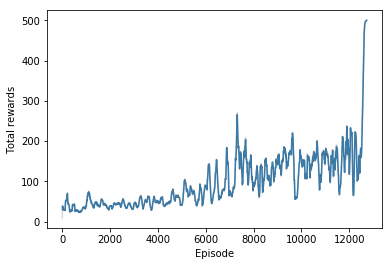

In [41]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

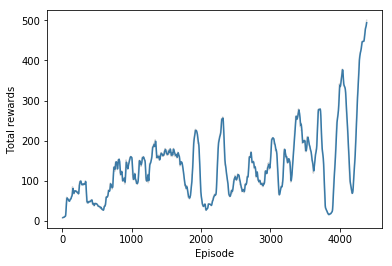

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

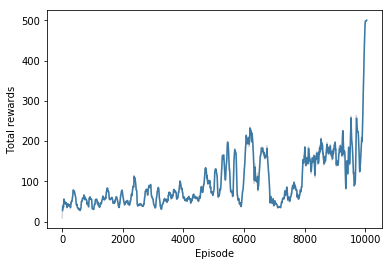

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

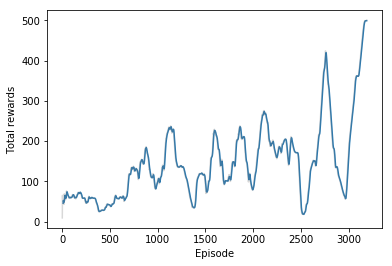

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

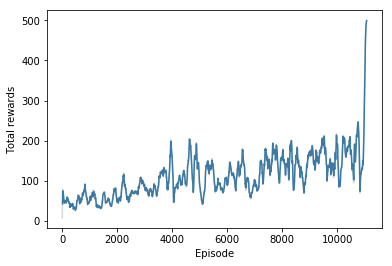

In [31]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

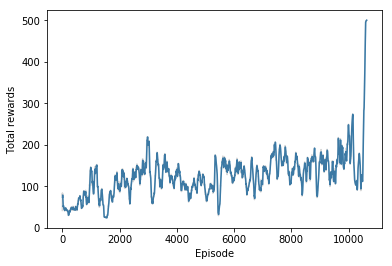

In [238]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

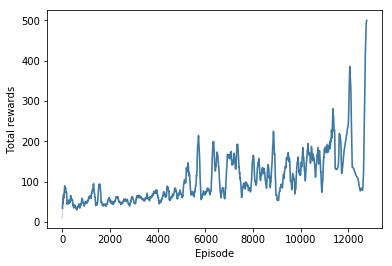

In [233]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

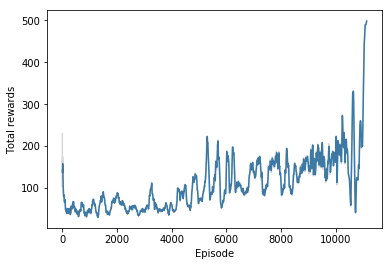

In [227]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

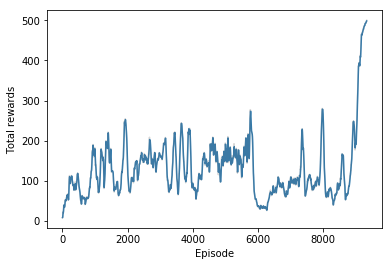

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

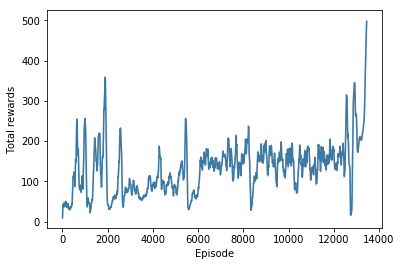

In [186]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

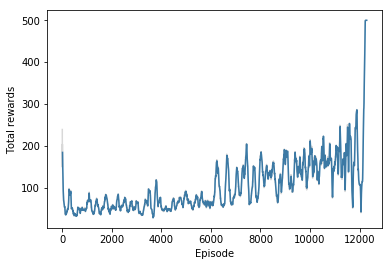

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

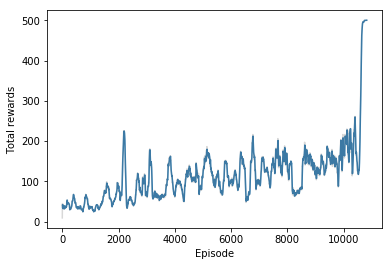

In [146]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

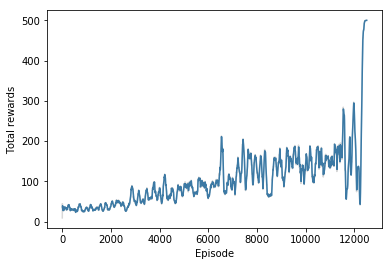

In [131]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

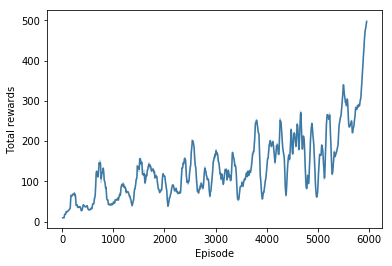

In [116]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

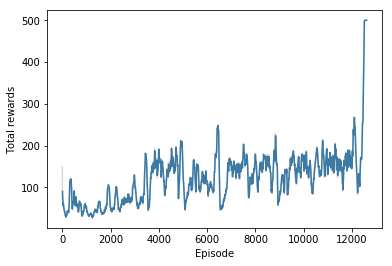

In [98]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

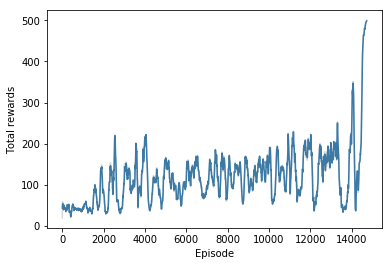

In [70]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

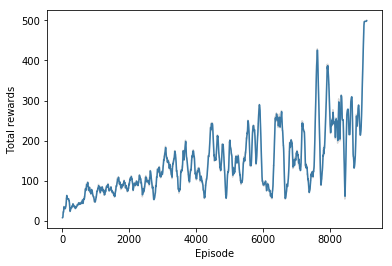

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

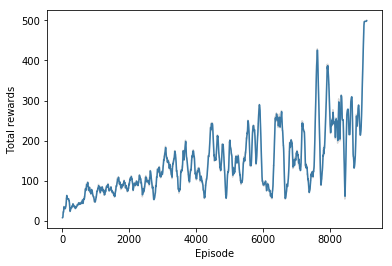

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

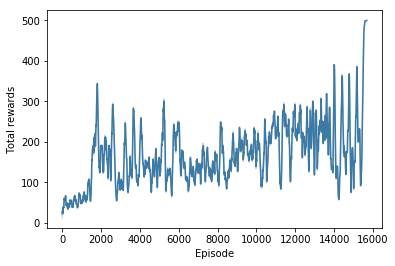

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

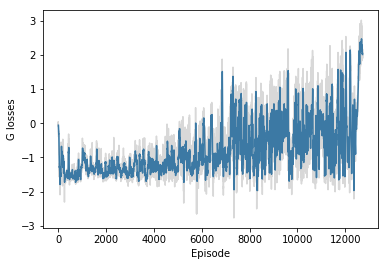

In [37]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

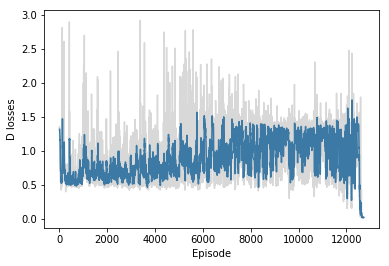

In [38]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

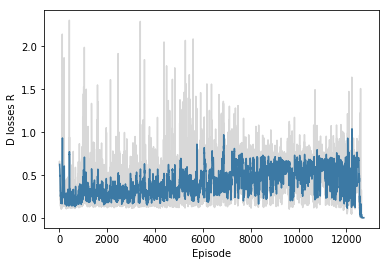

In [39]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

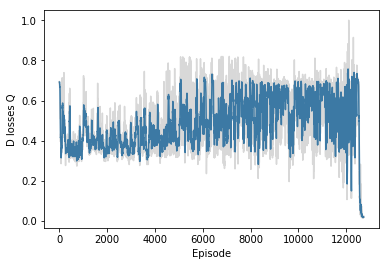

In [40]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.